# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [3]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [4]:
df_offers = pd.read_excel('WineKMC.xlsx', sheet_name=0)

/Users/deens/miniforge3/envs/tf_m1/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
#mannn why we always gotta talk about WINE?!

### 1b. Explore the data

In [5]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [6]:
df_transactions = pd.read_excel('WineKMC.xlsx', sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/deens/miniforge3/envs/tf_m1/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

In [7]:
df_transactions.shape

(324, 3)

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [8]:
#check for nans
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  324 non-null    object
 1   offer_id       324 non-null    int64 
 2   n              324 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


In [ ]:
# so no missings then??

In [9]:
len(df_transactions)

324

In [10]:
df_transactions.customer_name.value_counts()

Sanders    9
Fisher     7
Sanchez    7
Miller     7
Morales    6
          ..
Powell     1
Jones      1
Green      1
Torres     1
Ramirez    1
Name: customer_name, Length: 100, dtype: int64

In [ ]:
#easy way / their way (made easier / simplified; removed redundancy/waste)

In [11]:
pivot = df_transactions.pivot_table(index='customer_name', columns='offer_id', values='customer_name',fill_value=0)

pivot

offer_id       1   2   3   4   5   6   7   8   9   10  ...  23  24  25  26  \
customer_name                                          ...                   
Adams           0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
Allen           0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   
Anderson        0   0   0   0   0   0   0   0   0   0  ...   0   1   0   1   
Bailey          0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   
Baker           0   0   0   0   0   0   1   0   0   1  ...   0   0   0   0   
...            ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
Williams        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
Wilson          0   0   0   0   0   0   0   1   0   0  ...   0   0   0   0   
Wood            1   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   
Wright          0   0   0   1   0   1   0   0   0   0  ...   0   0   0   0   
Young           0   0   0   0   0   1   0   0   1   0  ...   0   0   0   0   

offer_id       27  28  29  30  31  32  
customer_name                          
Adams           0   0   1   1   0   0  
Allen           1   0   0   0   0   0  
Anderson        0   0   0   0   0   0  
Bailey          0   0   0   1   0   0  
Baker           0   0   0   0   1   0  
...            ..  ..  ..  ..  ..  ..  
Williams        0   0   0   0   1   0  
Wilson          0   0   0   1   0   0  
Wood            0   0   0   0   1   0  
Wright          1   0   0   0   0   0  
Young           0   0   0   0   1   1  

[100 rows x 32 columns]

In [ ]:
#SO THERE WAS NO NEED TO MERGE?!?! AND NO NEED FOR 'n' COLUMN?!?!

In [ ]:
#hard way / my way

In [13]:
# dummy_df = pd.get_dummies(df_transactions,columns=['offer_id'])
#ohhhh man! don't know how i forgot to DROP_FIRST!!!!
####################################################################
dummy_df = pd.get_dummies(df_transactions,columns=['offer_id'],drop_first=True)
dummy_df

customer_name  n  offer_id_1  offer_id_2  offer_id_3  offer_id_4  \
0           Smith  1           0           1           0           0   
1           Smith  1           0           0           0           0   
2         Johnson  1           0           0           0           0   
3         Johnson  1           0           0           0           0   
4         Johnson  1           0           0           0           0   
..            ... ..         ...         ...         ...         ...   
319        Fisher  1           0           0           0           0   
320        Fisher  1           0           0           0           0   
321        Fisher  1           0           0           0           0   
322        Fisher  1           0           0           0           0   
323        Fisher  1           0           0           0           0   

     offer_id_5  offer_id_6  offer_id_7  offer_id_8  ...  offer_id_23  \
0             0           0           0           0  ...            0   
1             0           0           0           0  ...            0   
2             0           0           0           0  ...            0   
3             0           0           0           0  ...            0   
4             0           0           0           0  ...            0   
..          ...         ...         ...         ...  ...          ...   
319           0           0           0           0  ...            0   
320           0           0           0           0  ...            0   
321           0           0           0           0  ...            0   
322           0           0           0           0  ...            0   
323           0           0           0           0  ...            0   

     offer_id_24  offer_id_25  offer_id_26  offer_id_27  offer_id_28  \
0              0            0            0            0            0   
1              1            0            0            0            0   
2              0            0            0            0            0   
3              1            0            0            0            0   
4              0            0            1            0            0   
..           ...          ...          ...          ...          ...   
319            0            0            0            0            0   
320            0            0            0            0            0   
321            0            0            0            0            1   
322            0            0            0            0            0   
323            0            0            0            0            0   

     offer_id_29  offer_id_30  offer_id_31  offer_id_32  
0              0            0            0            0  
1              0            0            0            0  
2              0            0            0            0  
3              0            0            0            0  
4              0            0            0            0  
..           ...          ...          ...          ...  
319            0            0            0            0  
320            0            0            0            0  
321            0            0            0            0  
322            0            1            0            0  
323            0            0            1            0  

[324 rows x 34 columns]

In [156]:
dummy_df.n.nunique()

1

In [14]:
dummy_df_trim=dummy_df.drop(['n'],axis=1)
dummy_df_trim

customer_name  offer_id_1  offer_id_2  offer_id_3  offer_id_4  offer_id_5  \
0           Smith           0           1           0           0           0   
1           Smith           0           0           0           0           0   
2         Johnson           0           0           0           0           0   
3         Johnson           0           0           0           0           0   
4         Johnson           0           0           0           0           0   
..            ...         ...         ...         ...         ...         ...   
319        Fisher           0           0           0           0           0   
320        Fisher           0           0           0           0           0   
321        Fisher           0           0           0           0           0   
322        Fisher           0           0           0           0           0   
323        Fisher           0           0           0           0           0   

     offer_id_6  offer_id_7  offer_id_8  offer_id_9  ...  offer_id_23  \
0             0           0           0           0  ...            0   
1             0           0           0           0  ...            0   
2             0           0           0           0  ...            0   
3             0           0           0           0  ...            0   
4             0           0           0           0  ...            0   
..          ...         ...         ...         ...  ...          ...   
319           0           0           0           0  ...            0   
320           0           0           0           0  ...            0   
321           0           0           0           0  ...            0   
322           0           0           0           0  ...            0   
323           0           0           0           0  ...            0   

     offer_id_24  offer_id_25  offer_id_26  offer_id_27  offer_id_28  \
0              0            0            0            0            0   
1              1            0            0            0            0   
2              0            0            0            0            0   
3              1            0            0            0            0   
4              0            0            1            0            0   
..           ...          ...          ...          ...          ...   
319            0            0            0            0            0   
320            0            0            0            0            0   
321            0            0            0            0            1   
322            0            0            0            0            0   
323            0            0            0            0            0   

     offer_id_29  offer_id_30  offer_id_31  offer_id_32  
0              0            0            0            0  
1              0            0            0            0  
2              0            0            0            0  
3              0            0            0            0  
4              0            0            0            0  
..           ...          ...          ...          ...  
319            0            0            0            0  
320            0            0            0            0  
321            0            0            0            0  
322            0            1            0            0  
323            0            0            1            0  

[324 rows x 33 columns]

In [15]:
df_transactions_trim=df_transactions.drop(['n'],axis=1)
df_transactions_trim

customer_name  offer_id
0           Smith         2
1           Smith        24
2         Johnson        17
3         Johnson        24
4         Johnson        26
..            ...       ...
319        Fisher        11
320        Fisher        22
321        Fisher        28
322        Fisher        30
323        Fisher        31

[324 rows x 2 columns]

In [16]:
dummy_df_trim.pivot_table(index='customer_name',aggfunc='sum')

offer_id_1  offer_id_10  offer_id_11  offer_id_12  offer_id_13  \
customer_name                                                                   
Adams                   0            0            0            0            0   
Allen                   0            0            0            0            0   
Anderson                0            0            0            0            0   
Bailey                  0            0            0            0            0   
Baker                   0            1            0            0            0   
...                   ...          ...          ...          ...          ...   
Williams                0            0            0            0            0   
Wilson                  0            0            0            0            0   
Wood                    1            1            0            0            0   
Wright                  0            0            0            0            0   
Young                   0            0            0            0            0   

               offer_id_14  offer_id_15  offer_id_16  offer_id_17  \
customer_name                                                       
Adams                    0            0            0            0   
Allen                    0            0            0            0   
Anderson                 0            0            0            0   
Bailey                   0            0            0            0   
Baker                    0            0            0            0   
...                    ...          ...          ...          ...   
Williams                 0            0            0            0   
Wilson                   0            0            0            0   
Wood                     1            0            0            0   
Wright                   0            0            0            0   
Young                    0            1            0            0   

               offer_id_18  ...  offer_id_3  offer_id_30  offer_id_31  \
customer_name               ...                                         
Adams                    1  ...           0            1            0   
Allen                    0  ...           0            0            0   
Anderson                 0  ...           0            0            0   
Bailey                   0  ...           0            1            0   
Baker                    0  ...           0            0            1   
...                    ...  ...         ...          ...          ...   
Williams                 1  ...           0            0            1   
Wilson                   0  ...           0            1            0   
Wood                     0  ...           0            0            1   
Wright                   0  ...           0            0            0   
Young                    0  ...           0            0            1   

               offer_id_32  offer_id_4  offer_id_5  offer_id_6  offer_id_7  \
customer_name                                                                
Adams                    0           0           0           0           0   
Allen                    0           0           0           0           0   
Anderson                 0           0           0           0           0   
Bailey                   0           0           0           0           1   
Baker                    0           0           0           0           1   
...                    ...         ...         ...         ...         ...   
Williams                 0           0           0           0           0   
Wilson                   0           0           0           0           0   
Wood                     0           0           0           0           0   
Wright                   0           1           0           1           0   
Young                    1           0           0           1           0   

               offer_id_8  offer_id_9  
customer_name                          
Adams             

In [17]:
#SUBHANALLAH WA BI HAMDI! SUBHANALLAHIL 'AUDHEEM
#now just order the columns! (don't know why it changes it out of order/
#a different kind of ordering here when before it did it perfectly fine??)

dummy_pivot_MASTER = dummy_df_trim.pivot_table(index='customer_name',aggfunc='sum')

ordered_cols = dummy_df_trim.columns[1:]

dummy_pivot_MASTER = dummy_pivot_MASTER[ordered_cols]

dummy_pivot_MASTER

offer_id_1  offer_id_2  offer_id_3  offer_id_4  offer_id_5  \
customer_name                                                               
Adams                   0           0           0           0           0   
Allen                   0           0           0           0           0   
Anderson                0           0           0           0           0   
Bailey                  0           0           0           0           0   
Baker                   0           0           0           0           0   
...                   ...         ...         ...         ...         ...   
Williams                0           0           0           0           0   
Wilson                  0           0           0           0           0   
Wood                    1           0           0           0           0   
Wright                  0           0           0           1           0   
Young                   0           0           0           0           0   

               offer_id_6  offer_id_7  offer_id_8  offer_id_9  offer_id_10  \
customer_name                                                                
Adams                   0           0           0           0            0   
Allen                   0           0           0           1            0   
Anderson                0           0           0           0            0   
Bailey                  0           1           0           0            0   
Baker                   0           1           0           0            1   
...                   ...         ...         ...         ...          ...   
Williams                0           0           0           0            0   
Wilson                  0           0           1           0            0   
Wood                    0           0           0           0            1   
Wright                  1           0           0           0            0   
Young                   1           0           0           1            0   

               ...  offer_id_23  offer_id_24  offer_id_25  offer_id_26  \
customer_name  ...                                                       
Adams          ...            0            0            0            0   
Allen          ...            0            0            0            0   
Anderson       ...            0            1            0            1   
Bailey         ...            0            0            0            0   
Baker          ...            0            0            0            0   
...            ...          ...          ...          ...          ...   
Williams       ...            0            0            0            0   
Wilson         ...            0            0            0            0   
Wood           ...            0            0            0            0   
Wright         ...            0            0            0            0   
Young          ...            0            0            0            0   

               offer_id_27  offer_id_28  offer_id_29  offer_id_30  \
customer_name                                                       
Adams                    0            0            1            1   
Allen                    1            0            0            0   
Anderson                 0            0            0            0   
Bailey                   0            0            0            1   
Baker                    0            0            0            0   
...                    ...          ...          ...          ...   
Williams                 0            0            0            0   
Wilson                   0            0            0            1   
Wood                     0            0            0            0   
Wright                   1            0            0            0   
Young                    0            0            0            0   

               offer_id_31  offer_id_32  
customer_name                            
Adams                    0            0  
Allen      

In [265]:
dummy_df_trim.columns[1:]

Index(['offer_id_1', 'offer_id_2', 'offer_id_3', 'offer_id_4', 'offer_id_5',
       'offer_id_6', 'offer_id_7', 'offer_id_8', 'offer_id_9', 'offer_id_10',
       'offer_id_11', 'offer_id_12', 'offer_id_13', 'offer_id_14',
       'offer_id_15', 'offer_id_16', 'offer_id_17', 'offer_id_18',
       'offer_id_19', 'offer_id_20', 'offer_id_21', 'offer_id_22',
       'offer_id_23', 'offer_id_24', 'offer_id_25', 'offer_id_26',
       'offer_id_27', 'offer_id_28', 'offer_id_29', 'offer_id_30',
       'offer_id_31', 'offer_id_32'],
      dtype='object')

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of SS do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing SS (>>intertia!) for each K and pick K using this plot. For simplicity, test k=2 to k=10 [for some reason in this cell, maybe others, formatting didn't go thru/parse as intended, so fixed up; like here i assume this is the meaning they were going for - fixed in other places too (esp where used '$' dollar signs! i tried asterisks for bolding/italics and no go :(].
<li> Make a bar chart showing the number of points in each cluster for k-means under the best K.
<li> What challenges did you experience using the Elbow method to pick K?
</ul>
</div>

In [21]:
#ahhh okay - so doing it my way, the columns/features already ARE the offer_ids!
#in their/original pivot table way, there aren't exactly colummns...
#in both tho, we don't have any extra columns to get rid of cuz again the customer name
#is actually the *INDEX* here which is a great hack cuz then we're 'separating off' the label
#without *ACTUALLY* separating it off!
#so for us, we just needa make it into a numpy array (required?)
dummy_pivot_MASTER_array = dummy_pivot_MASTER.to_numpy()
dummy_pivot_MASTER_array


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=uint8)

In [20]:
#doing their way - looks like still works out the same!
pivot_array = pivot.to_numpy()
pivot_array

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

In [ ]:
#except interestingly they don't have to deal w/ /worry about the 'dtype' annoyance lol which is good

In [22]:
#so the point was to make sure that we had ONLY the X data isolated for fitting/modeling ofc

#the customer name is sort of our label here (in stocks/FIFA sense, where this is open-ended -
# aka we don't know what clusters we want - we're totally relegating this to the findings
# of the model - like we'll see why they were CLUSTERED together, ie obviously because they
#had similar stats - but then the question is WHY did they have similar stats?
#or perhaps, in customer cases, we don't need to get that deep (but if we did, at least
#this is a starting point / this told us who to investigate together/what to investigate,
#but we simply wanna know what GROUPS aka CLUSTERS of customers are there, aka 'archetypes',
#>> principal/key components??/THEMES!?
#so yeah, maybe that's true w/ stocks & fifa too - like we get the companies/countries
#that are similar - maybe some we realized / some we didn't / some we could've gathered from
#looking at the data, others not cuz too much; or even if we COULD've, just way easier
#to let the computer do it - that's its specialty! what its built for! so don't waste our
#limited energy / resources and be prone to subjective error! lol let the "calculator"
#handle the "calculations"! that's literally its department. don't mess/interfere w/ that! lol
#but yeah - it's telling us who's similar.... then what?/so what? no prediction involved here,
#at least not directly, no testing performance, cuz no "answer key", but when/if we WISH
#to do predictions, we can keep these findings in mind!
#we can keep doing this analysis to *SEE IF THE PATTERNS REPEAT*!!!! like see if they
#continue to hold true!
#but yeah, in stocks/FIFA - you could possibly investigate further to see why specifically
#some organizations performed / behaved similarly. esp ones that were surprising - not obvious
# - could just be a coinc - i guess look at pval & how close they were in clustering
#w/ this tho - customer purchase data - how would you be able to delve deeper into
#WHY certain customers may be alike??
#well, remember - PCA and all the clustering techniques won't tell you *WHY* the things
#in a cluster are the similar, or why exactly 2 things are spaced as close or as far
#as they are - like maybe you could look at variance of the ORIGINAL features to see
#possibly how weighty they might've been? kinda like w/ explained variance of *PRINCIPAL
#COMPONENTS*! or, maybe better - you could look at the correlation between original
#features of *MEMBERS/SAMPLES OF THE *SAME* CLUSTER!!!*
#and so like say w/ customers, a big factor is *AGE* (obviously alot of this is gonna
#depend on *WHAT* data you have! NOW YOU SEE WHY COMPANIES WANT YOUR DATA SO BAD / ARE WILLING
#TO PAY BIG BUCKS FOR YOUR DATA!!!!) - so now you can be like aaaah!/aha! (lol not Rayyan - or maybe you can lol)
# - so like (making this very simple) like what these ppl all have in common is being YOUNG -
#so that's good for us to know cuz we see that young ppl CONSISTENTLY like the SAME types of
#products, for example


#and as always ofc don't JUST look at the clustering IDs but look at the *RAW VISUAL/RAW
#DISTANCE of where companies lied relative to each other! cuz ofc, can be that one's
#NEAREST NEIGHBOR IS THE *NEXT CLUSTER* / MUCH CLOSER TO (A MEMBER OF) *THE NEXT CLUSTER*
#THEN TO THE FURTHEST MEMBER (or def even less/even *CENTER*) OF THEIR *OWN* CLUSTER!!!!!!!!!


#so it's almost like this is just helping us to VISUALIZE, which, i guess we already knew;
#and speaking of that, in some cases, like the music genres MIT example, it's telling us
#stuff we already know, but it's just powerful when we can confirm that the computer can do
#the same - except, i guess the big difference is - it can do "QUANTITATIVELY/objectively"/cerebrally/logically
#what we can do *QUALITATIVELY/SUBJECTIVELY!!!!!/intuitively/emotionally
#TheComingTogether! #Man&Machine! // #Mind&Machine!

#but also tho - this is definitely different from stocks/fifa in the sense that these
#features are *ALL BINARY*!!! (again tho, they very well COULD'VE been non-binary/open-ended
#in this case, but, nonetheless, this shows that there IS a case where we can be dealing
#with binaries! true/falses)
##########################################################################################


In [269]:
#so we didn't needa DROP anything/don't needa drop customer name right cuz that's
#simply the INDEX!?!?
dummy_pivot_MASTER.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, Adams to Young
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   offer_id_1   100 non-null    uint8
 1   offer_id_2   100 non-null    uint8
 2   offer_id_3   100 non-null    uint8
 3   offer_id_4   100 non-null    uint8
 4   offer_id_5   100 non-null    uint8
 5   offer_id_6   100 non-null    uint8
 6   offer_id_7   100 non-null    uint8
 7   offer_id_8   100 non-null    uint8
 8   offer_id_9   100 non-null    uint8
 9   offer_id_10  100 non-null    uint8
 10  offer_id_11  100 non-null    uint8
 11  offer_id_12  100 non-null    uint8
 12  offer_id_13  100 non-null    uint8
 13  offer_id_14  100 non-null    uint8
 14  offer_id_15  100 non-null    uint8
 15  offer_id_16  100 non-null    uint8
 16  offer_id_17  100 non-null    uint8
 17  offer_id_18  100 non-null    uint8
 18  offer_id_19  100 non-null    uint8
 19  offer_id_20  100 non-null    uint8
 20  offer_id_

In [277]:
#JUST in case / JUST to be safe!! check the ones we can't see!
dummy_pivot_MASTER[dummy_pivot_MASTER.columns[20:]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, Adams to Young
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   offer_id_21  100 non-null    uint8
 1   offer_id_22  100 non-null    uint8
 2   offer_id_23  100 non-null    uint8
 3   offer_id_24  100 non-null    uint8
 4   offer_id_25  100 non-null    uint8
 5   offer_id_26  100 non-null    uint8
 6   offer_id_27  100 non-null    uint8
 7   offer_id_28  100 non-null    uint8
 8   offer_id_29  100 non-null    uint8
 9   offer_id_30  100 non-null    uint8
 10  offer_id_31  100 non-null    uint8
 11  offer_id_32  100 non-null    uint8
dtypes: uint8(12)
memory usage: 6.0+ KB


In [ ]:
#okay alhamdulillah!!!

In [ ]:
#btw - it's not a problem that these are 'uint8' right? doesn't make a diff?

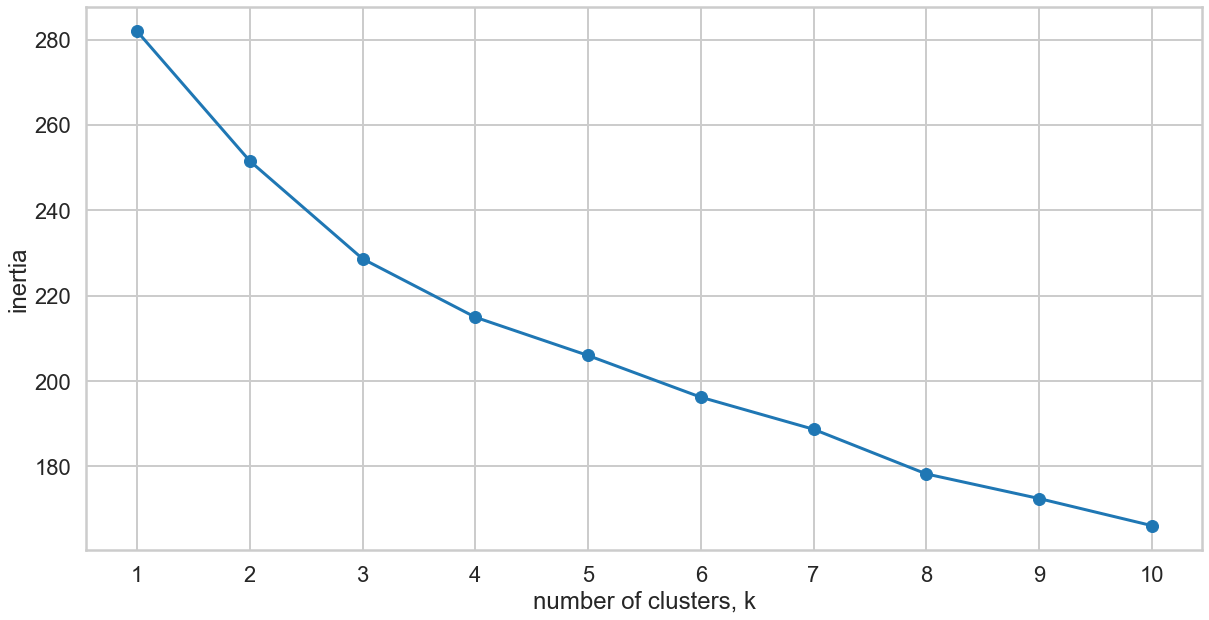

In [27]:
from sklearn.cluster import KMeans

ks=range(1,11)
inertias=[]

plt.figure(figsize=(20,10))

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(dummy_pivot_MASTER)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks);

In [ ]:
#oh wow! this is definitely different/tougher than the other elbow charts we've seen thus far
#the initial burst does slow down at k=3 tho, but the thing is, it doesn't PLATEAU!
#it CONTINUES to go down quite a bit, AND THIS IS ONLY SHOWING TO k=10!! out of possibly k=100!

#it almost seems to maybe *PICK UP* 'acceleration' lol @ k=7+!

#but if we had to pick from here we'd go with k=3 because we like smaller k's, though
#we'd be uneasy / not confident

#it's tough / heavy-hearted because we're used to seeing the 'decay' basically 'plateau' after
#a certain point, aka the inertia doesn't go down much after that till the end


#REMEMBER#! k can theoretically go ALL THE WAY THRU TO THE *NUMBER OF POINTS*!!!!
#/samples >> k=N so here, k=100! let's check it out just to see if / when this levels off!!

#*******************
#NOTE!!!/WARNING!!!!
#DON'T CONFUSE k CLUSTERS, which is related to #*SAMPLES*/POINTS*
#w/ like #FEATURES/#PRINCIPAL COMPONENTS!!!!!
#*******************

/var/folders/cr/9gwdd0wn43d9d1db4xfhyvpc0000gn/T/ipykernel_77975/4069983372.py:10: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (90). Possibly due to duplicate points in X.
  model.fit(dummy_pivot_MASTER)
/var/folders/cr/9gwdd0wn43d9d1db4xfhyvpc0000gn/T/ipykernel_77975/4069983372.py:10: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (91). Possibly due to duplicate points in X.
  model.fit(dummy_pivot_MASTER)
/var/folders/cr/9gwdd0wn43d9d1db4xfhyvpc0000gn/T/ipykernel_77975/4069983372.py:10: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (92). Possibly due to duplicate points in X.
  model.fit(dummy_pivot_MASTER)
/var/folders/cr/9gwdd0wn43d9d1db4xfhyvpc0000gn/T/ipykernel_77975/4069983372.py:10: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (93). Possibly due to duplicate points in X.
  model.fit(dummy_pivot_MASTER)
/var/folders/cr/9gwdd0wn43d9

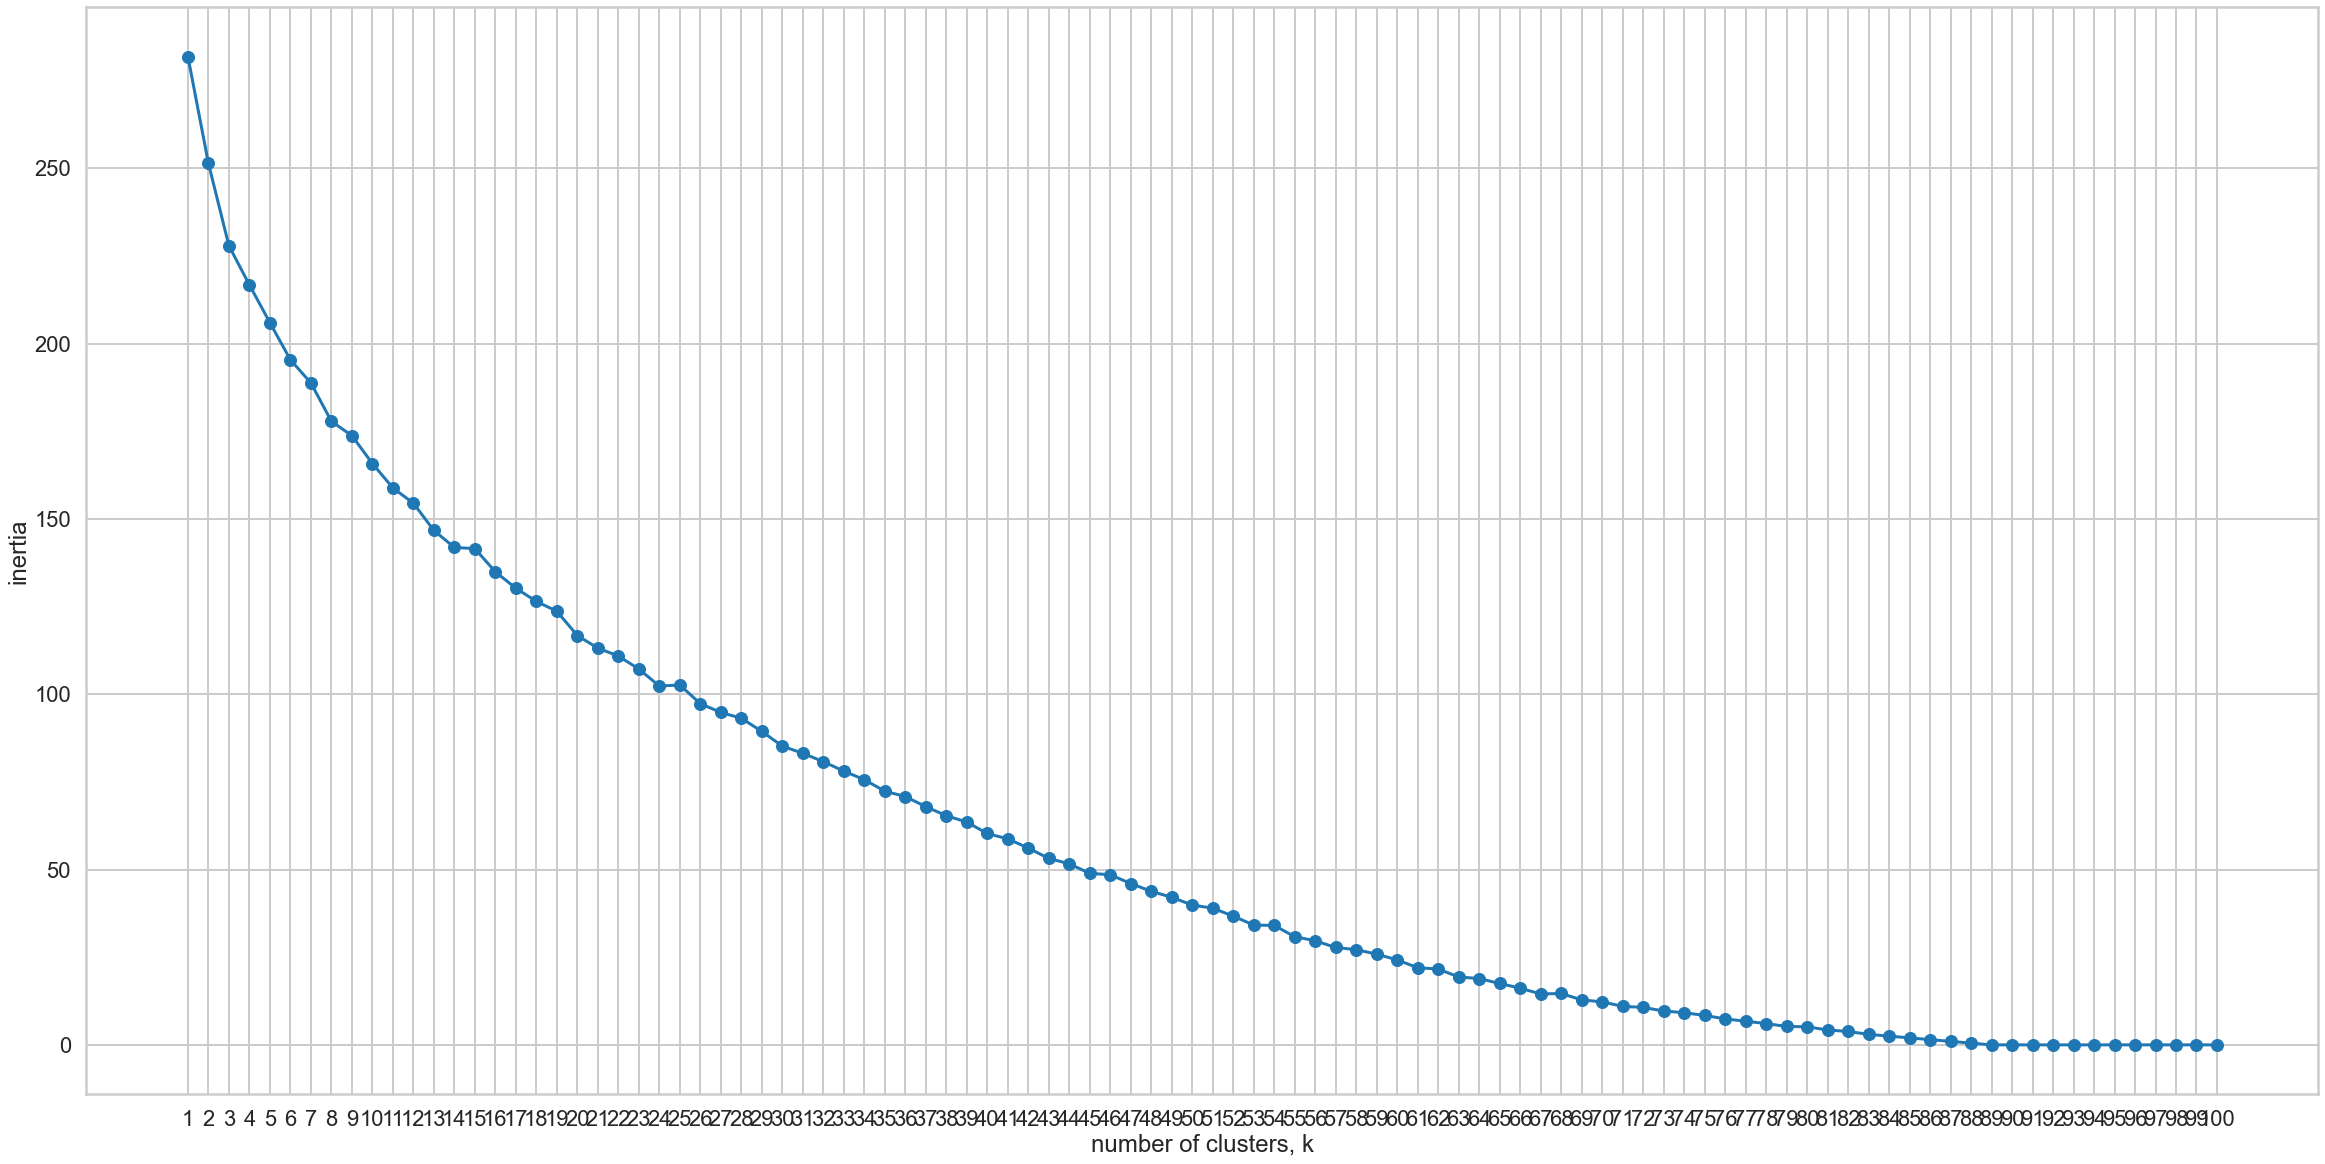

In [26]:
ks=range(1,101) #remem needa ++1plus cuz *end*excluxive*;P
inertias=[]

plt.figure(figsize=(40,20))

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(dummy_pivot_MASTER)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks);

In [ ]:
####################################################################################
#oh lol - so it's saying "ConvergenceWarning: Number of distinct clusters (89) found smaller
#than n_clusters. Possibly due to duplicate points in X."
#and it started doing this @ k=90, WHICH MAKES SENSE!
#so it's saying that there ARE only 89 distinct clusters, so errors when we have GREATER THAN
#89 CLUSTERS! but wait - *I THOUGHT IT COULD MAKE AS MANY CLUSTERS AS THERE ARE POINTS
#AKA k=N!!!!! unless - ... are these just "TOO close together"???
#you can see it's perfectly flat from 90-100!
#but yeah - you can see that REALLY IN THIS ELBOW VIEW THINGS REALLY DON'T LEVEL OFF
#LITERALLY *UNTIL* THIS WARNING! LOLLLLL! @k=*90*!!!!!!
####################################################################################

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351


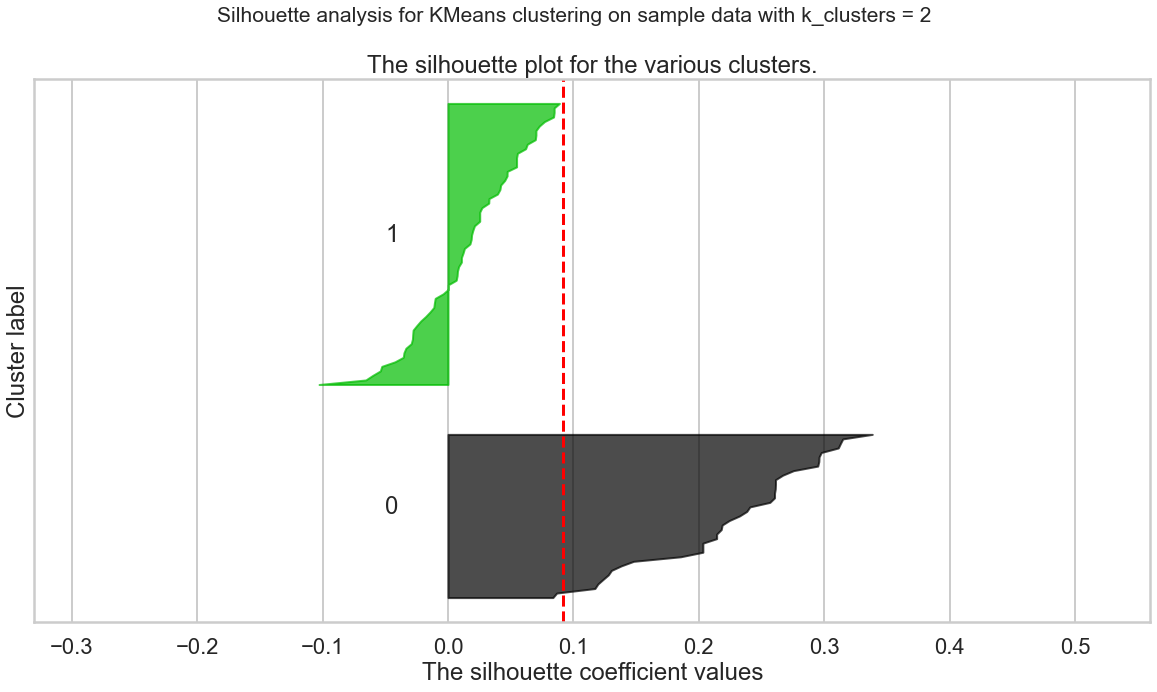

For n_clusters = 3 The average silhouette_score is : 0.11889942863638556


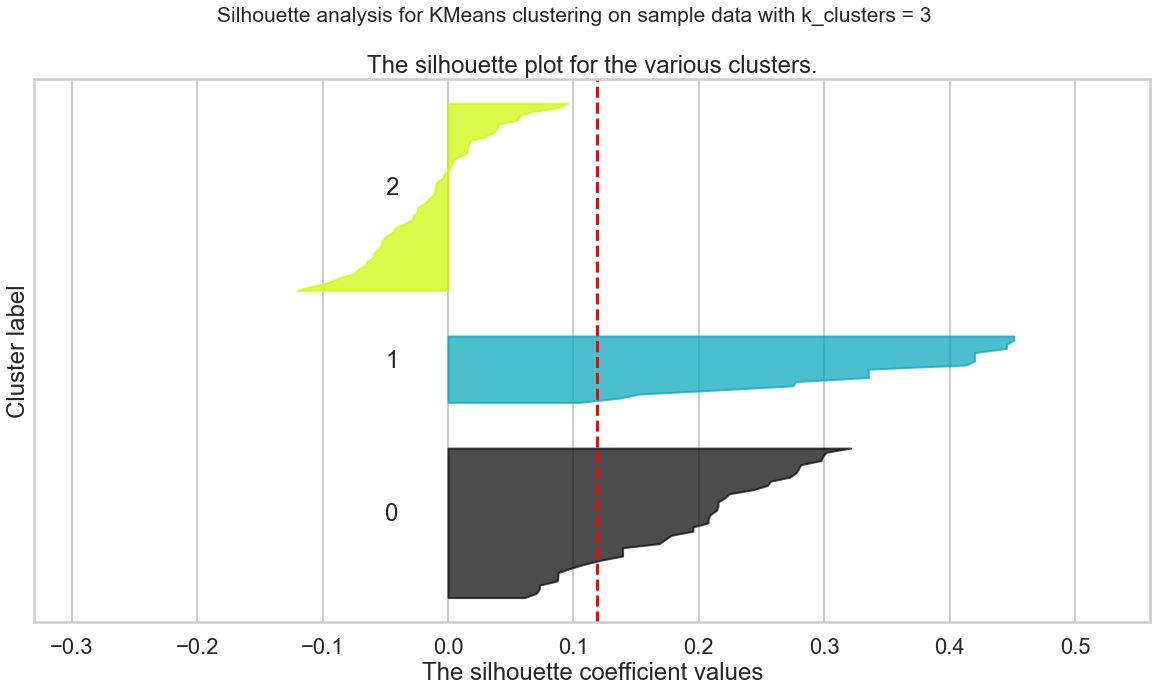

For n_clusters = 4 The average silhouette_score is : 0.12167039851355937


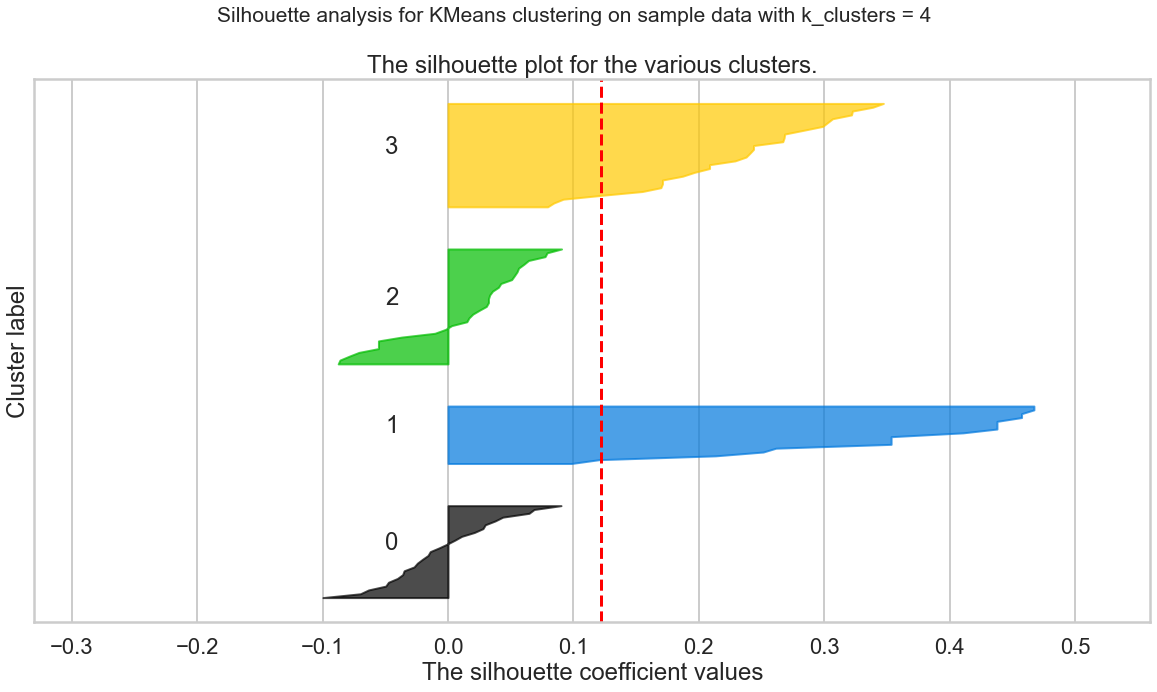

For n_clusters = 5 The average silhouette_score is : 0.13528618244904822


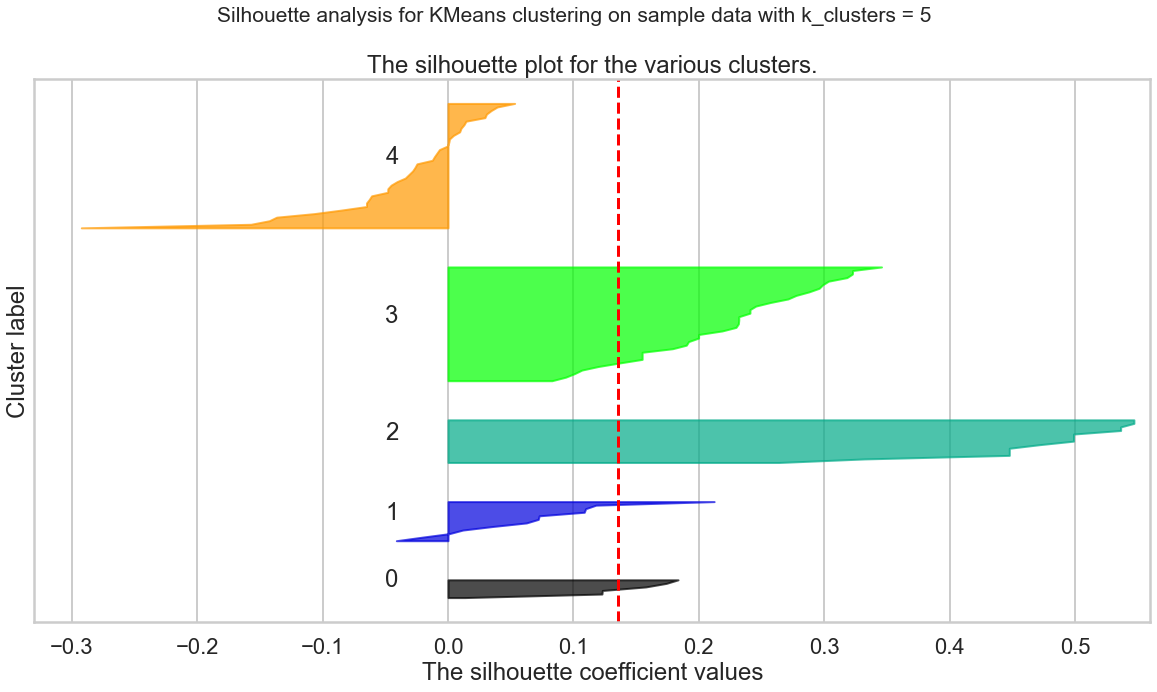

For n_clusters = 6 The average silhouette_score is : 0.13218209978013543


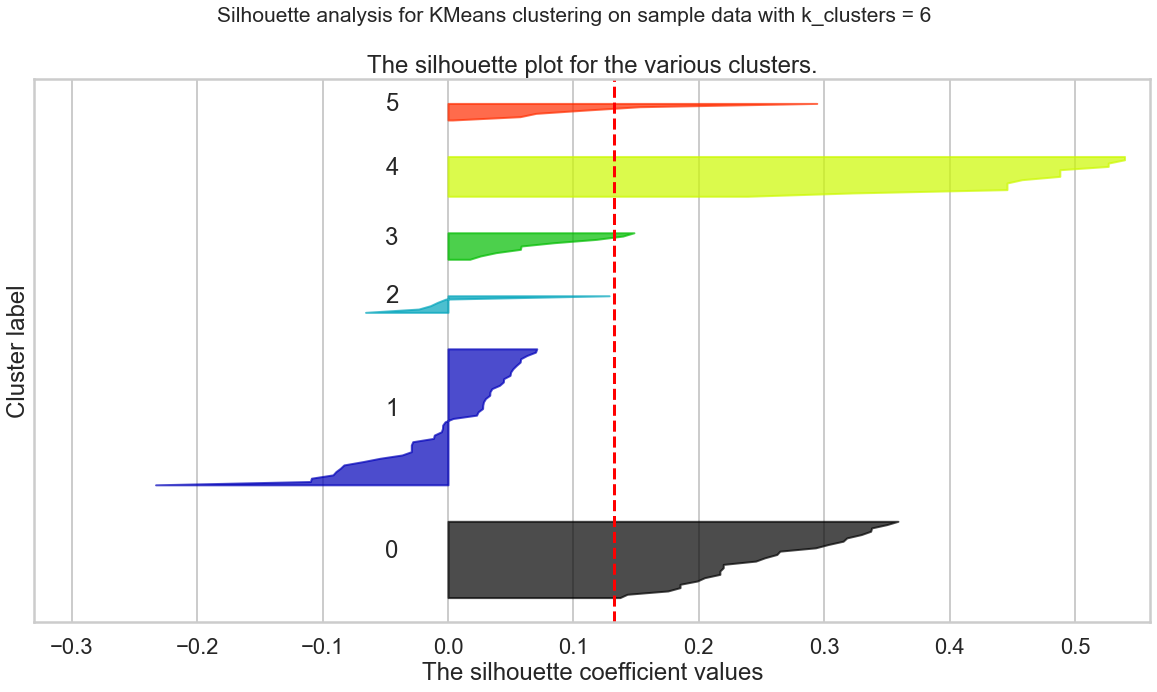

For n_clusters = 7 The average silhouette_score is : 0.13365227784322317


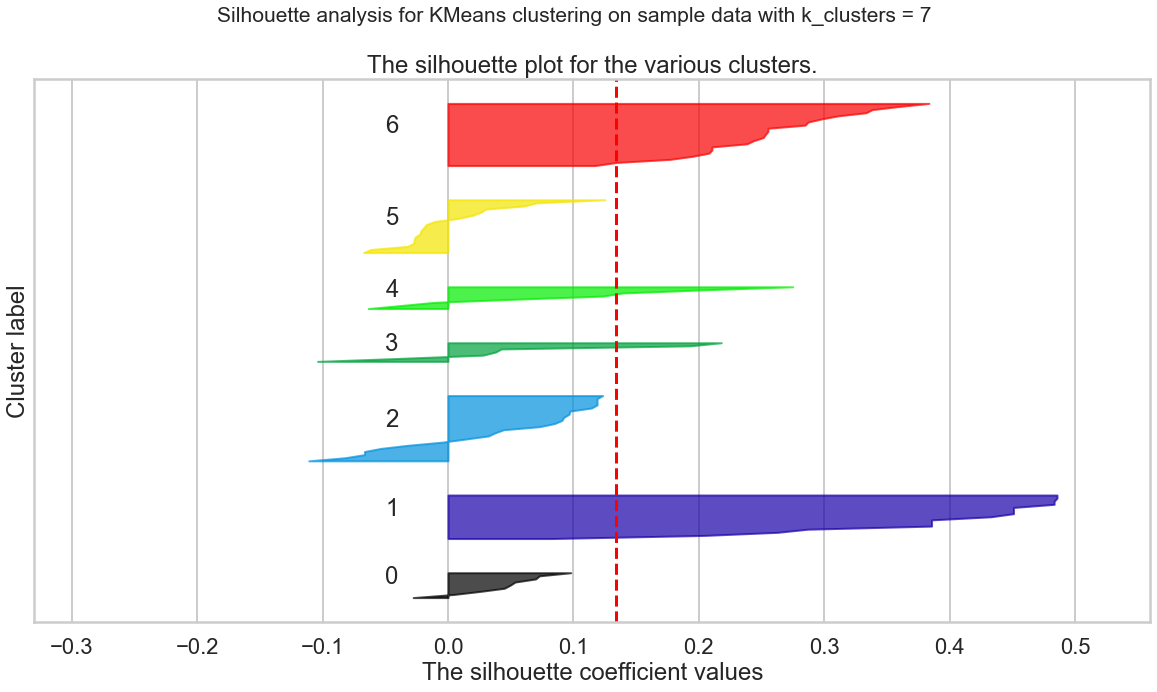

For n_clusters = 8 The average silhouette_score is : 0.12482407120722075


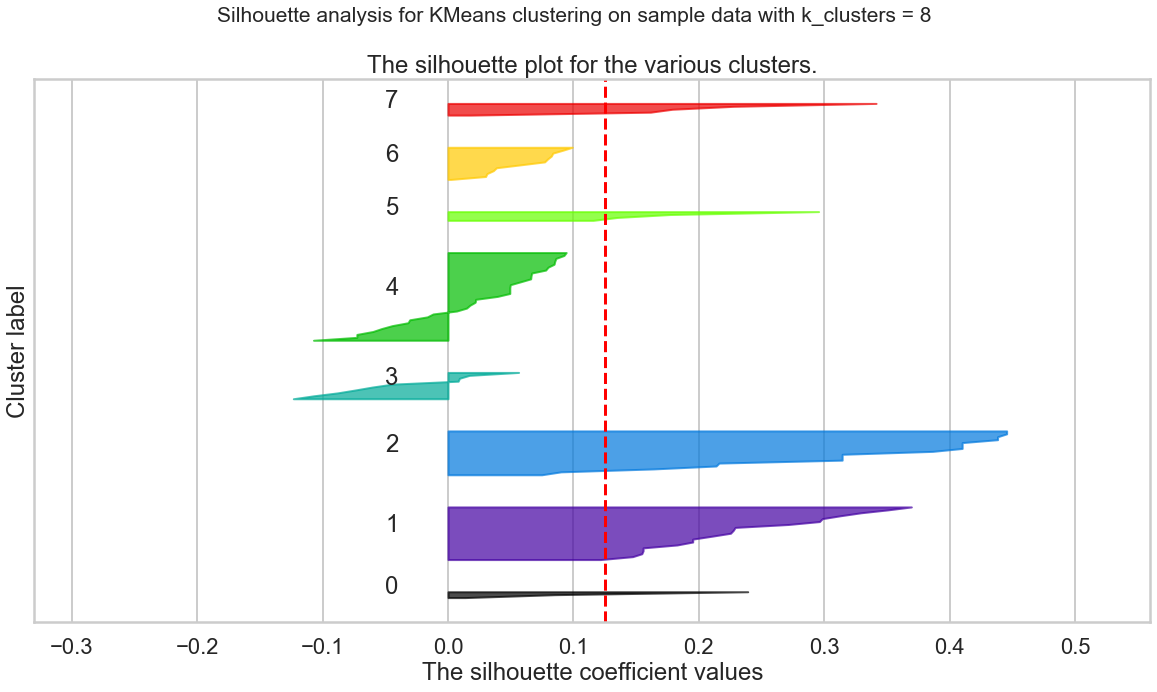

For n_clusters = 9 The average silhouette_score is : 0.11686562917000483


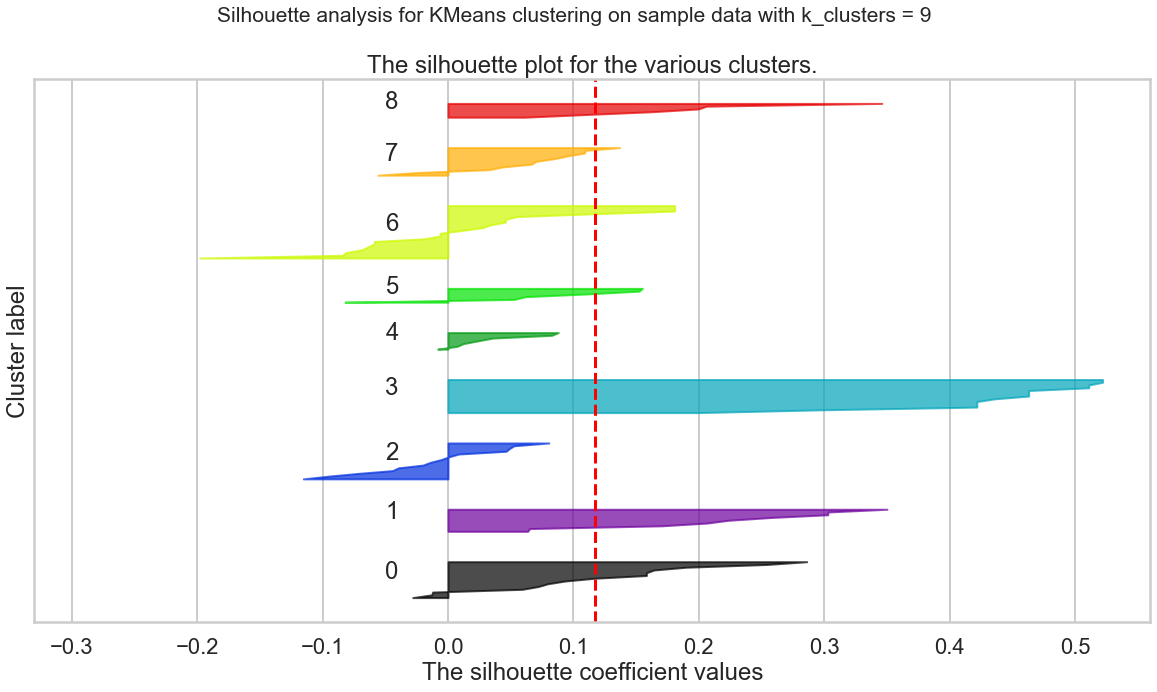

For n_clusters = 10 The average silhouette_score is : 0.10889477148379977


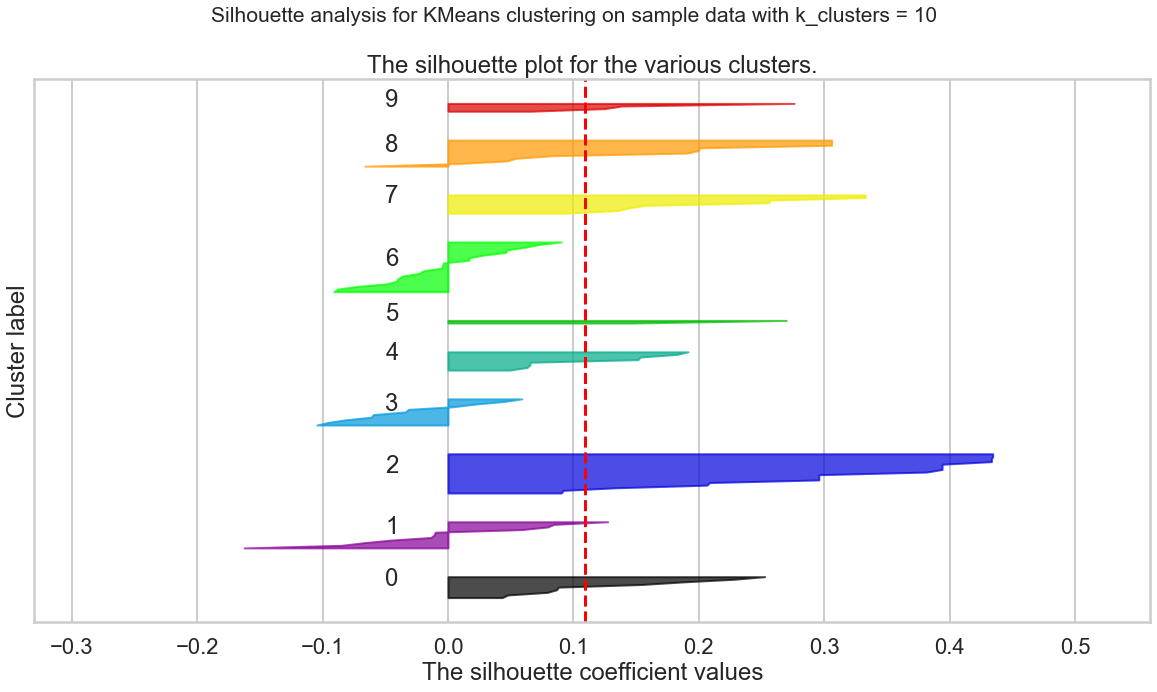

In [34]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = range(2,11) #gonna stick w/ the range they said! for simplicity, for now, hehe

for n_clusters in range_n_clusters:
    plt.figure(figsize=(20,10)) #ohhhh dang! gotta set/specify it for EACH plot!
    
    plt.xlim([-.33,.56])

    # plt.ylim([0, len(dummy_X_array2) + (n_clusters + 1) * 10])
    #need this??

    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    # clusterer = KMeans(n_clusters=n_clusters, n_init='auto',random_state=1)
    #n_init auto still doesn't work even w/ everything else (iA) being right?!
    ###############################################################

    cluster_labels = clusterer.fit_predict(dummy_pivot_MASTER_array)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    #SO THIS IS THE *AVERAGE* SCORE FOR *ALL* SAMPLES FOR/@ THIS k CUZ REMEM -
    #SILHOUETTE IS CALCULATED FOR *EACH INDIVIDUAL SAMPLE*!!!!
    ###############################################################
    silhouette_avg = silhouette_score(dummy_pivot_MASTER_array, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg)

    # Compute the silhouette scores for each sample
    #LIKE LITERALLY FOR EACH *INDIVIDUAL* SAMPLE
    ###############################################################
    sample_silhouette_values = silhouette_samples(dummy_pivot_MASTER_array, cluster_labels)
    
    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper), 0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot

        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    # plt.xticks([-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([-.3, -.2, -.1, 0, .1, .2, .3, .4, .5])


    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with k_clusters = %d"
        % n_clusters, fontsize=21)

    plt.show()

In [ ]:
#SUBHANALLAH WA BI HAMDI SUBHANALLAHIL 'AUDHEEM!!!!!!!!!!!!!!!!!!!
#LAA ILLAHA ILLA ANT, SUBHANAK, INNEE KUNTU MIN-ADH-DHAALIMEEN!!!!!!!!!!!!!!

In [306]:
#let's look at JUST the list of scores!

range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=1)

    cluster_labels = clusterer.fit_predict(dummy_pivot_MASTER_array)

    silhouette_avg = silhouette_score(dummy_pivot_MASTER_array, cluster_labels)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12167039851355937
For n_clusters = 5 The average silhouette_score is : 0.13528618244904822
For n_clusters = 6 The average silhouette_score is : 0.13218209978013543
For n_clusters = 7 The average silhouette_score is : 0.13365227784322317
For n_clusters = 8 The average silhouette_score is : 0.12482407120722075
For n_clusters = 9 The average silhouette_score is : 0.11686562917000483
For n_clusters = 10 The average silhouette_score is : 0.10889477148379977


In [307]:
#okay let's see what the best is!

range_n_clusters = range(2,11)

k = []
silhouette_averages=[]


for n_clusters in range_n_clusters:

    k.append(n_clusters)

    clusterer = KMeans(n_clusters=n_clusters, random_state=1)

    cluster_labels = clusterer.fit_predict(dummy_pivot_MASTER_array)

    silhouette_avg = silhouette_score(dummy_pivot_MASTER_array, cluster_labels)

    silhouette_averages.append(silhouette_avg)


df = pd.DataFrame({'k':k, 'silhouette_average':silhouette_averages})
df.query( 'silhouette_average == silhouette_average.max()' )

k  silhouette_average
3  5            0.135286

In [308]:
#okay let's see what the best is!

range_n_clusters = range(2,101)

k = []
silhouette_averages=[]


for n_clusters in range_n_clusters:

    k.append(n_clusters)

    clusterer = KMeans(n_clusters=n_clusters, random_state=1)

    cluster_labels = clusterer.fit_predict(dummy_pivot_MASTER_array)

    silhouette_avg = silhouette_score(dummy_pivot_MASTER_array, cluster_labels)

    silhouette_averages.append(silhouette_avg)


df = pd.DataFrame({'k':k, 'silhouette_average':silhouette_averages})
df.query( 'silhouette_average == silhouette_average.max()' )

/Users/deens/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (90). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/deens/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (91). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/deens/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (92). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/deens/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (89) found

k  silhouette_average
66  68            0.229798

In [ ]:
#hmm beyond our initial target/focus range
#should i drop index? lol

In [ ]:
#oh wait lol - just realized - does it even work that way where the
#'best' is the HIGHEST or am i just ASSHYUMING?!? lol

#OK so aH yes it seems so - and i assume we DO go by highest AVERAGE silhou score,
#not highest ABSO/SINGLE!
#remember these are like DISTS so that's why you see them KRAGGLY jutting out!
#lol look like a cruise ship/cruiseliner or train!
#but yeah seems like pretty LOW averages! even tho some jut out towards
#a good bit higher
#but even the highest ABSO silhou scores aren't that high...
#and remem some are NEGATIVE!
#why's that?? >> OH YEAH!! Documentation says: "Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar."
#got it!

#but do we look at *TRADE-OFF* here for the NUMBER OF k's/CLUSTERS?!?!
################################################################################

#but remem what silhou score is: *EVERY SINGLE POINT* has a score. it looks at:
    #(a)how close the point is to ALL POINTS IN *ITS* CLUSTER - so this point we
        #WANT to be LOW/SMALL!! lower the better
    #(b)the MINIMUM of the AVERAGE distance to each OTHER cluster
        #(meaning, it takes the distance to all points OUTSIDE of its cluster,
        #and for all points of a single cluster, it gets the AVERAGE distance
        #for those, and then takes the MINIMUM of those averages! sound like
        #the 'SINGLE' measurement method in Hierarchical Clustering!!!!!)
        #so this value we WANT to be high - higher the better
    #this subtracts the first in the numerator (b-a), so we want the numerator to be HIGH
    #then the denom is simply the GREATER of these two^
        #which means that SHOULD be b
    #thus, as b got higher and a got lower, a would essentially become 0
    #and/thus this equation (b-a)/b would basically become b/b ≈ 1!!!!!
    #HENCE WHY 1 IS THE *IDEAL* / BEST / HIGHEST!!!!!
    #and remember it's SPECIFICALLY *+1* aka POSITIVE 1!!!!
    #not 'equivalent' cuz of magnitude like in other applications! lol
    #negative is ALWAYS BAD!!!
    #don't know if like the HIGHER mag the negative the worse?
    #Like is -1 worst or *0*??????

    #and these scores are ALL relatively low tho aren't they?! like even the INDVIDUAL
    #sample point highs don't get that high?!
    ###############################################################
    

In [43]:
#let's limit it down to just thru k=10!

#okay let's see what the best is!

ks = range(2,11)

k = []
silhouette_averages=[]


for k_clusters in ks:

    k.append(k_clusters)

    clusterer = KMeans(n_clusters=k_clusters, random_state=1)

    cluster_labels = clusterer.fit_predict(dummy_pivot_MASTER_array)

    silhouette_avg = silhouette_score(dummy_pivot_MASTER_array, cluster_labels)

    silhouette_averages.append(silhouette_avg)


df = pd.DataFrame({'k':k, 'silhouette_average':silhouette_averages})
df.query( 'silhouette_average == silhouette_average.max()' ).style.hide_index()

k  silhouette_average
3  5            0.135286

In [46]:
#hmm interesting!

#let's see the others! ranked!
df.sort_values('silhouette_average', ascending=False).style.hide_index()
########################################################################


In [ ]:
#SUBHANALLAH WA BI HAMDI SUBHANALLAHIL 'AUDHEEM!!!!!!

#interesting tho that k=3 is towards the BOTTOM!!!
####################################################

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351


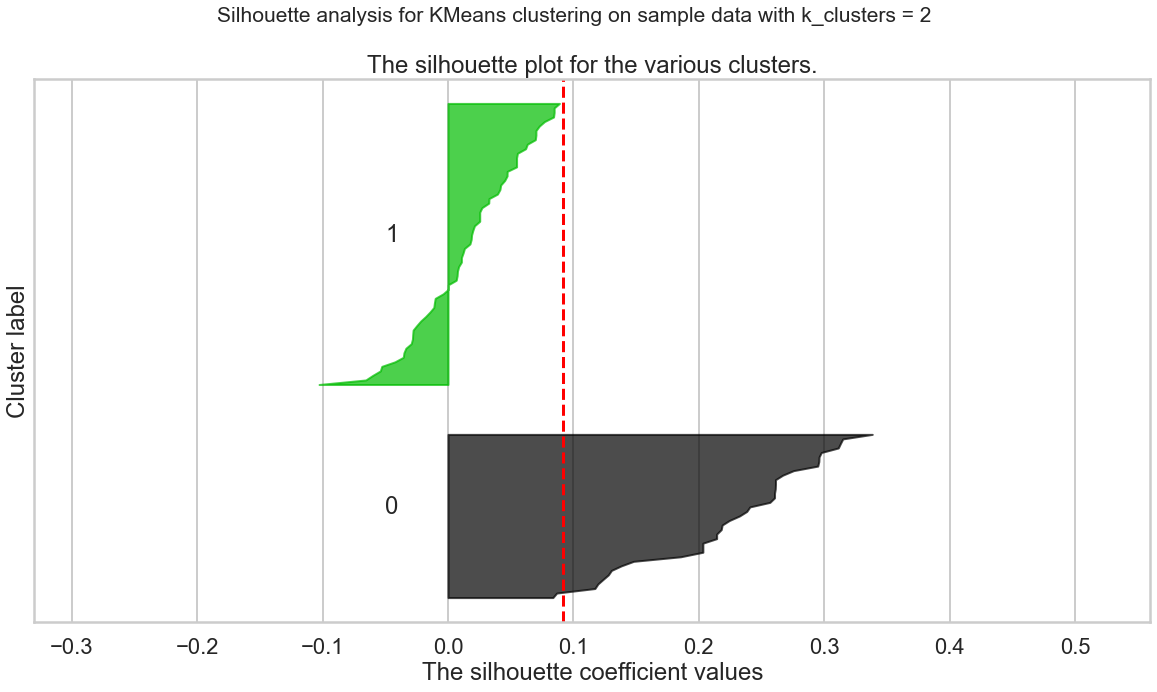

For n_clusters = 3 The average silhouette_score is : 0.11889942863638556


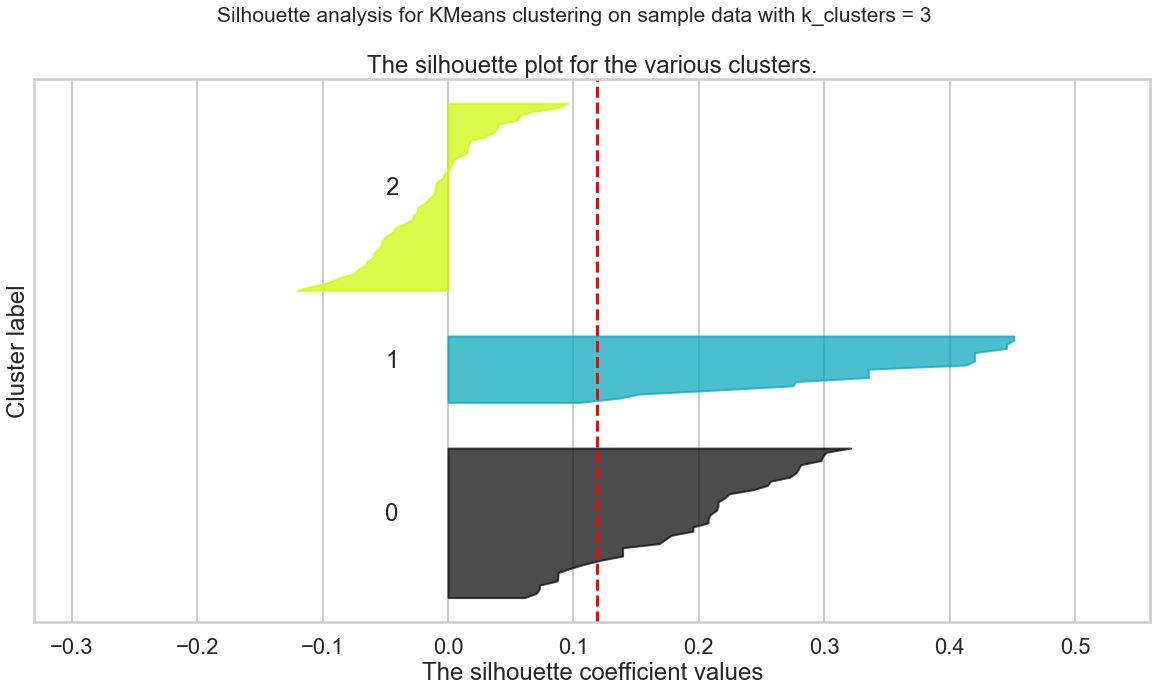

For n_clusters = 4 The average silhouette_score is : 0.12167039851355937


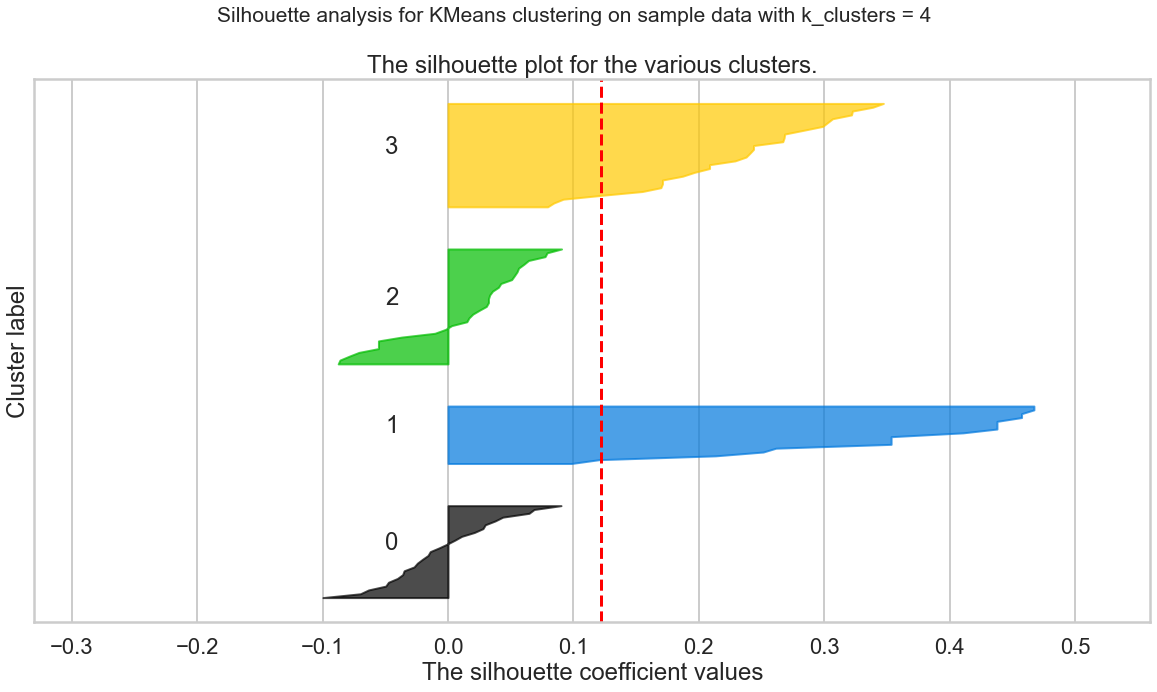

For n_clusters = 5 The average silhouette_score is : 0.13528618244904822


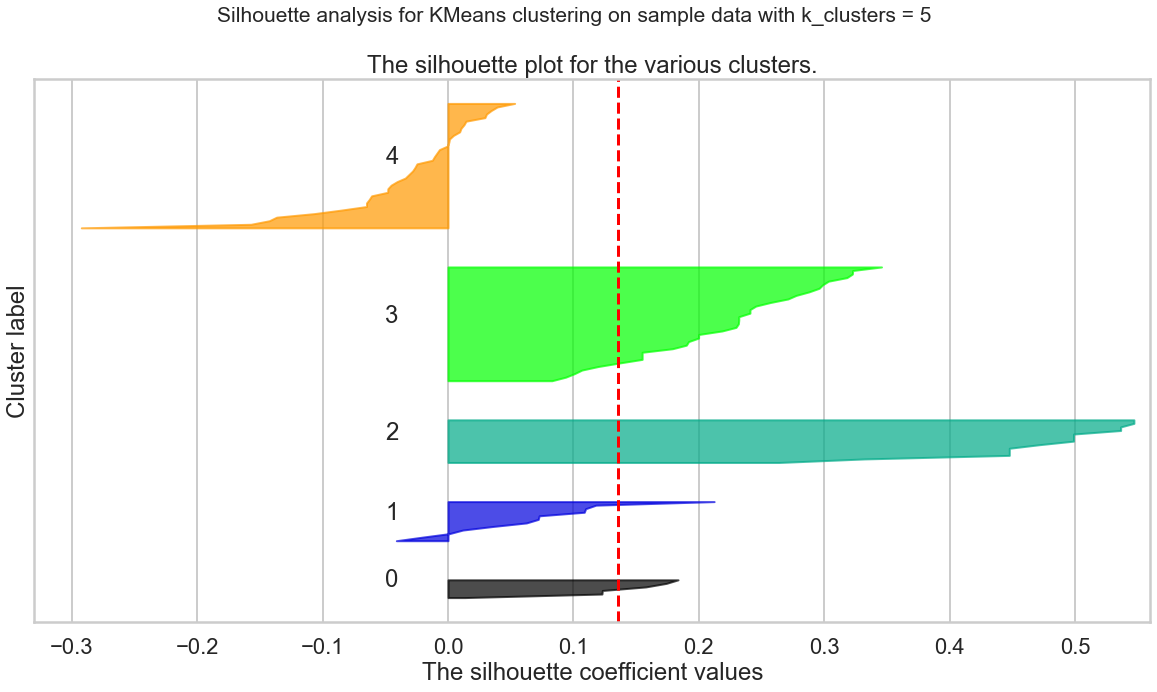

For n_clusters = 6 The average silhouette_score is : 0.13218209978013543


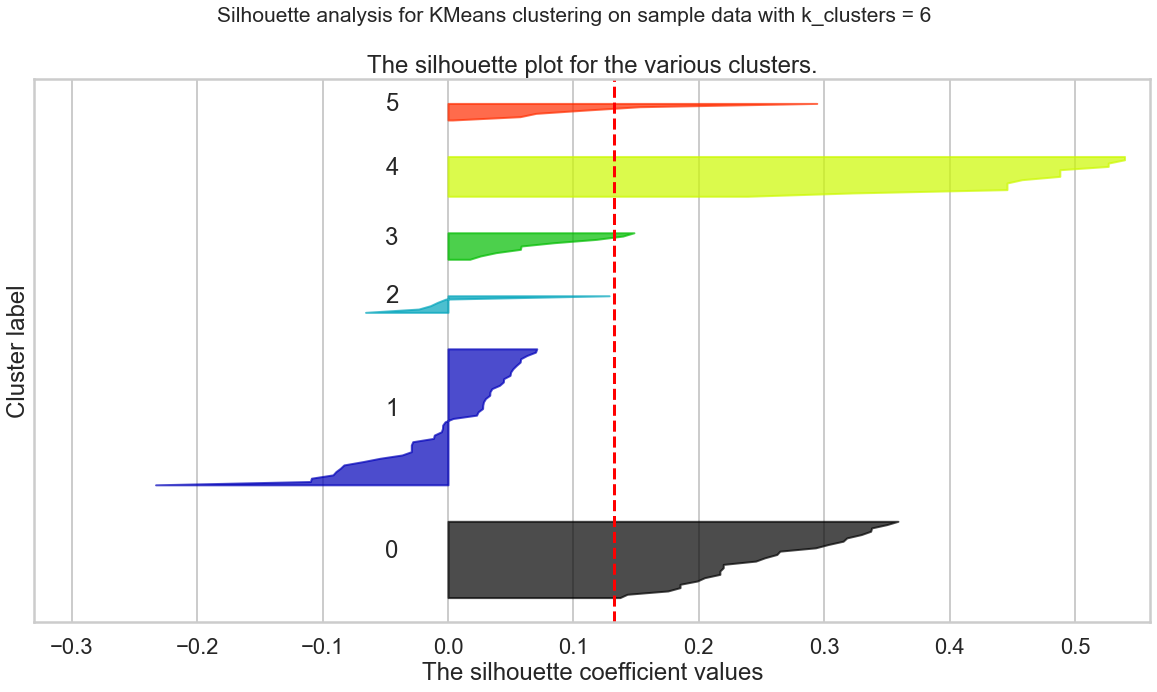

For n_clusters = 7 The average silhouette_score is : 0.13365227784322317


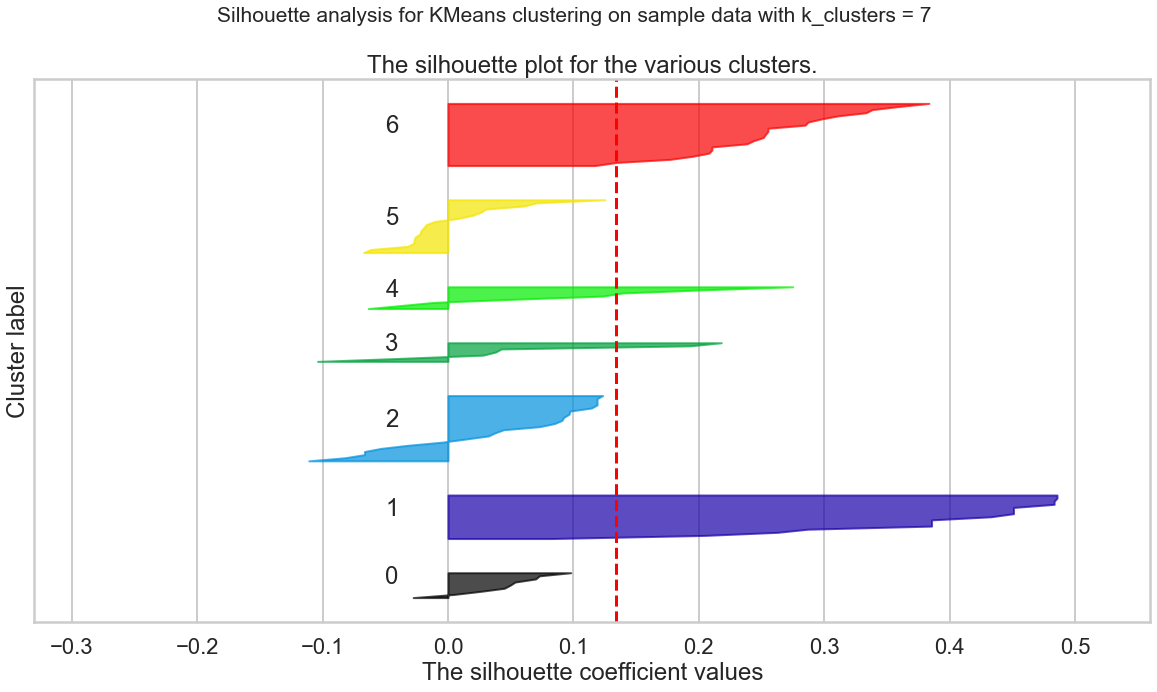

For n_clusters = 8 The average silhouette_score is : 0.12482407120722075


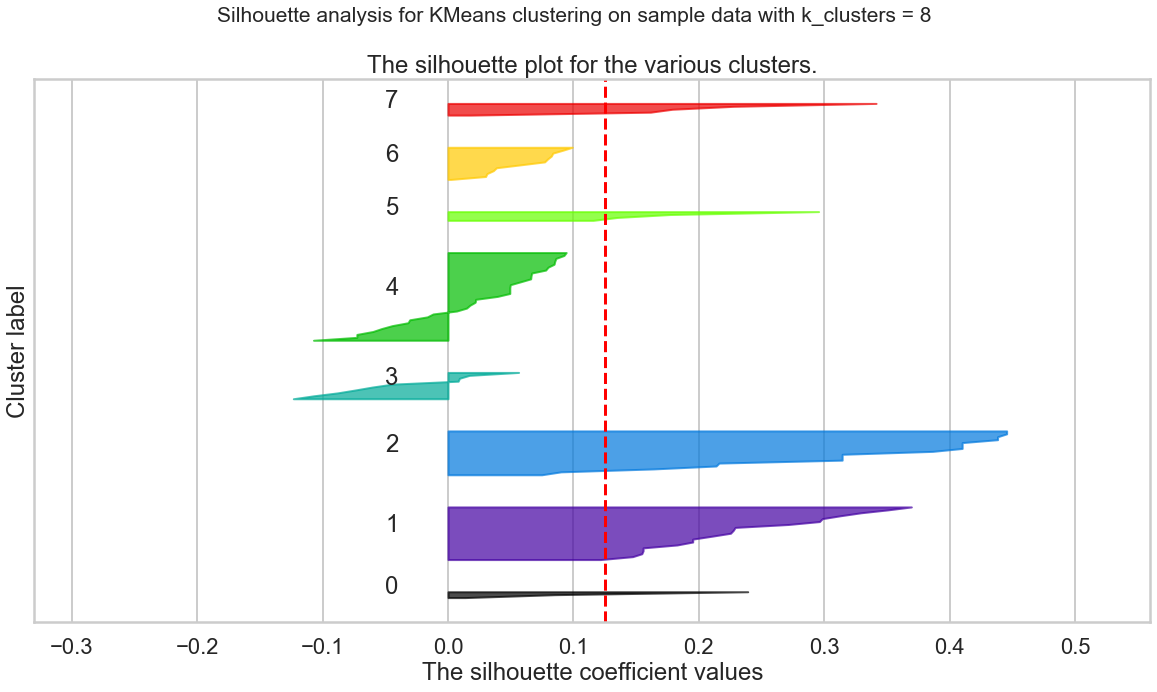

For n_clusters = 9 The average silhouette_score is : 0.11686562917000483


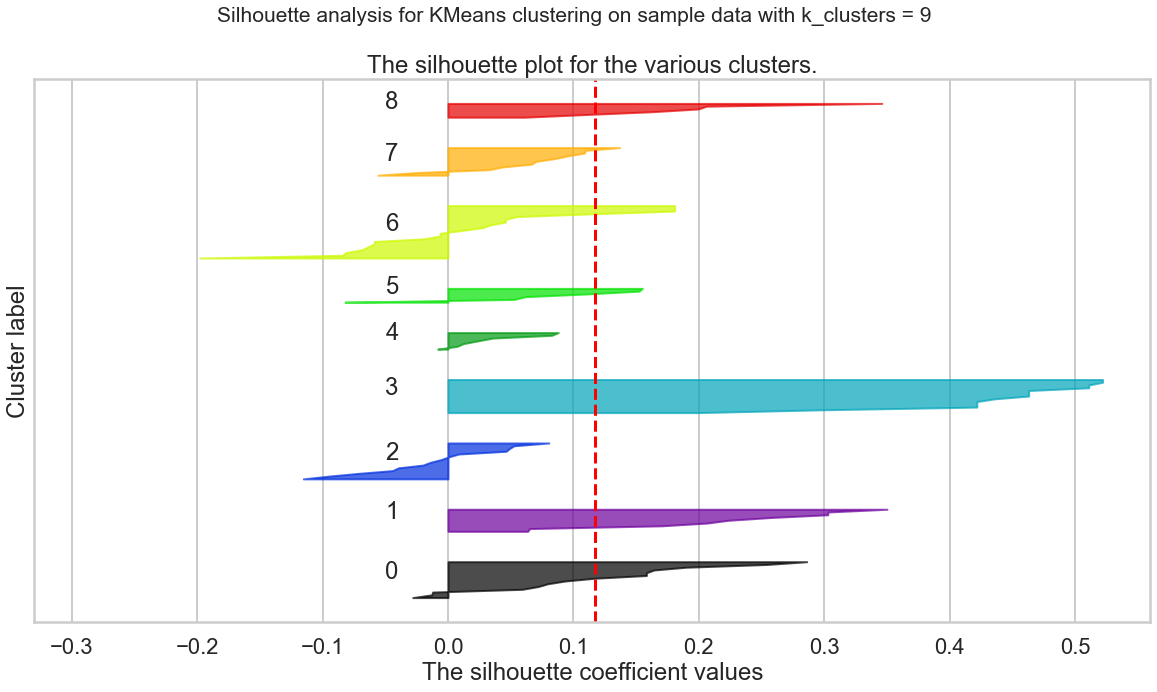

For n_clusters = 10 The average silhouette_score is : 0.10889477148379977


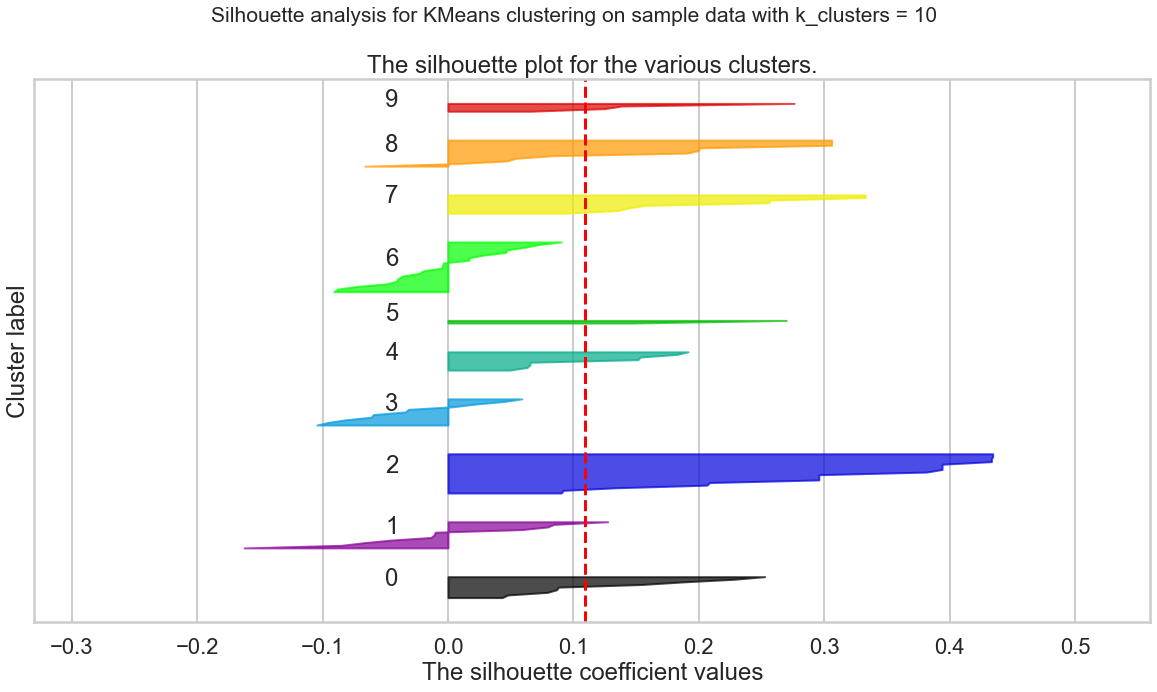

For n_clusters = 11 The average silhouette_score is : 0.1286779208894978


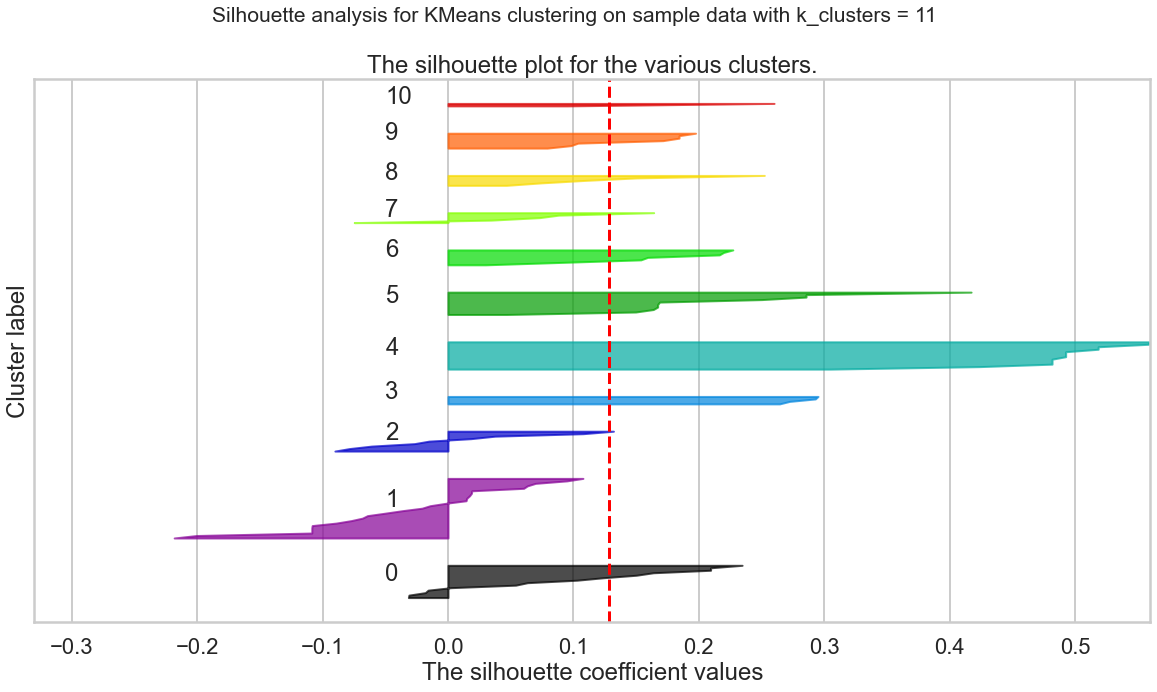

For n_clusters = 12 The average silhouette_score is : 0.13343099846782644


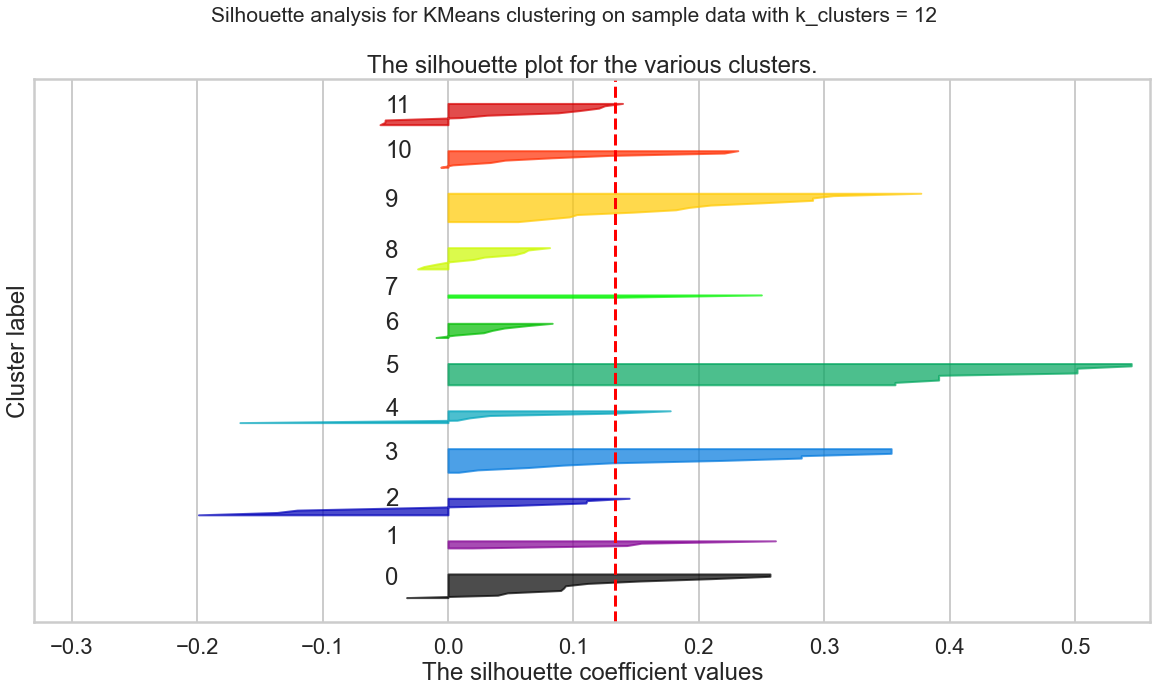

For n_clusters = 13 The average silhouette_score is : 0.12245338425177626


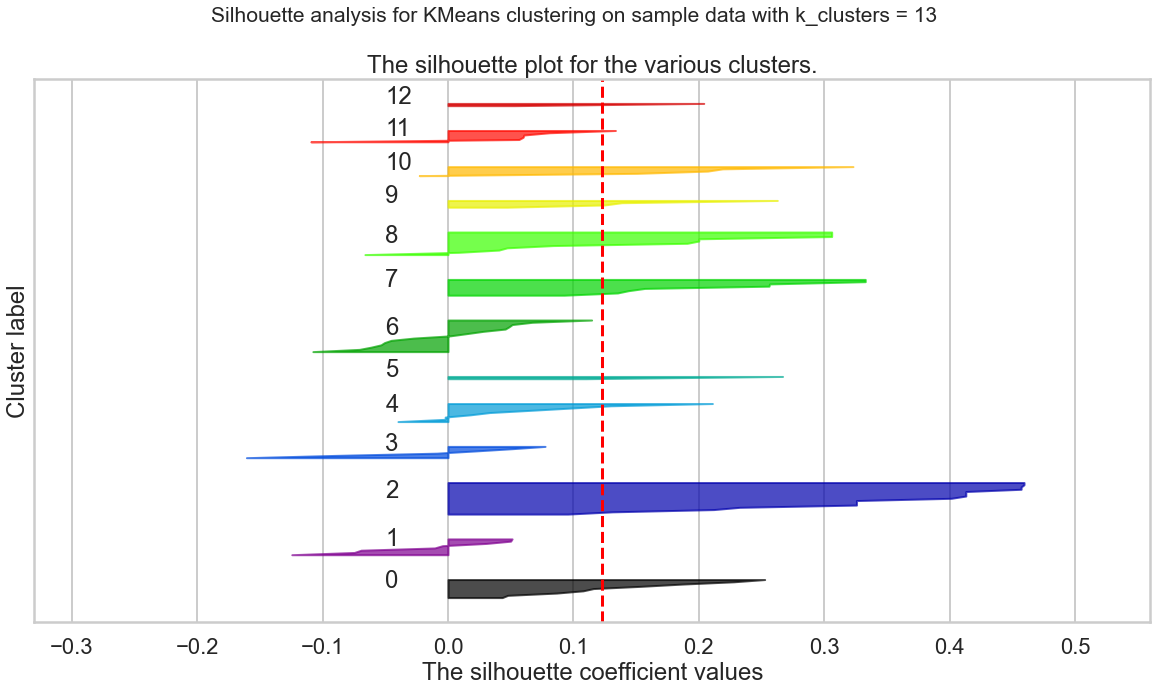

For n_clusters = 14 The average silhouette_score is : 0.14891411990661507


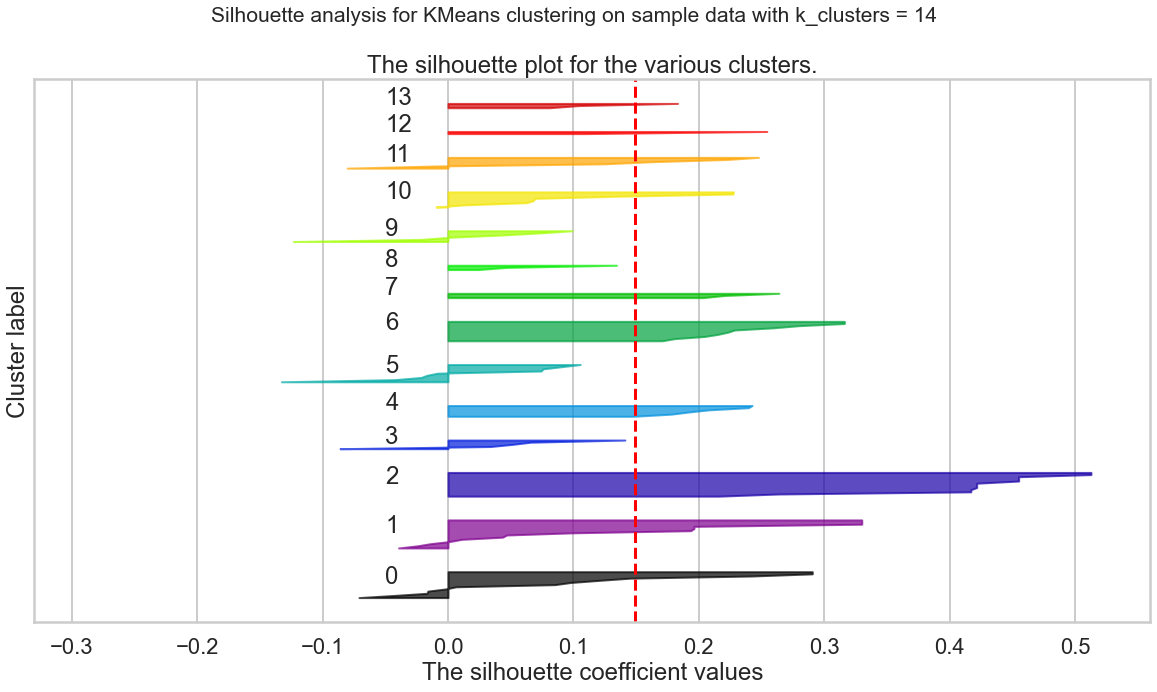

For n_clusters = 15 The average silhouette_score is : 0.12820342411206484


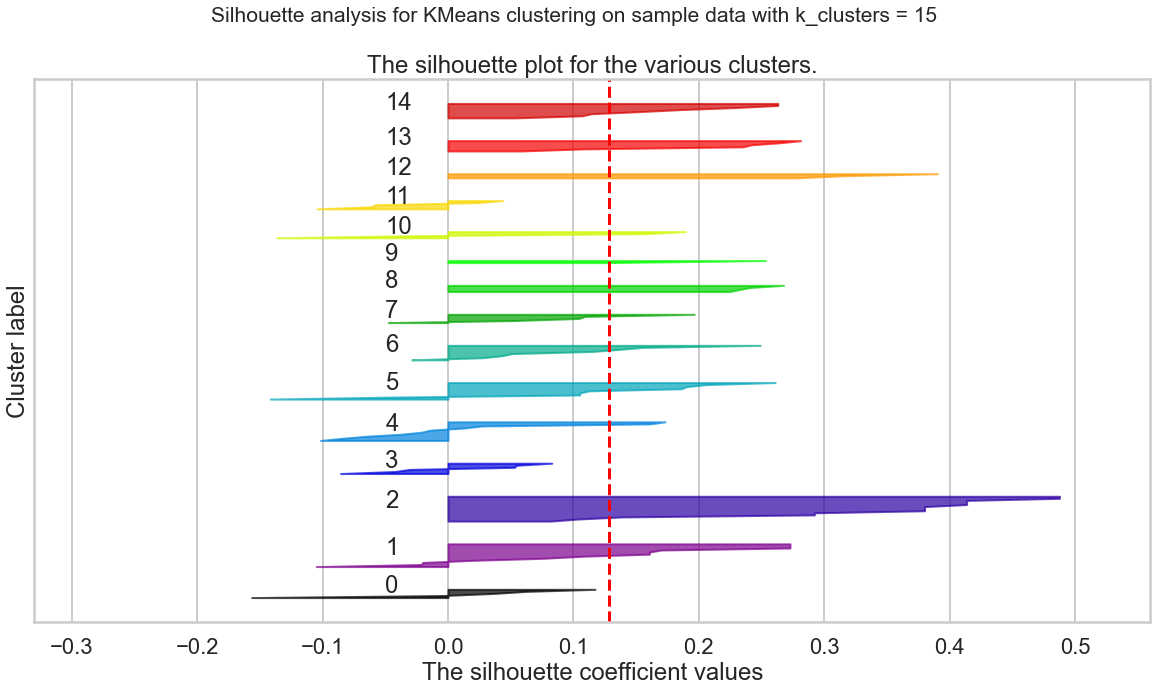

For n_clusters = 16 The average silhouette_score is : 0.14228498256022612


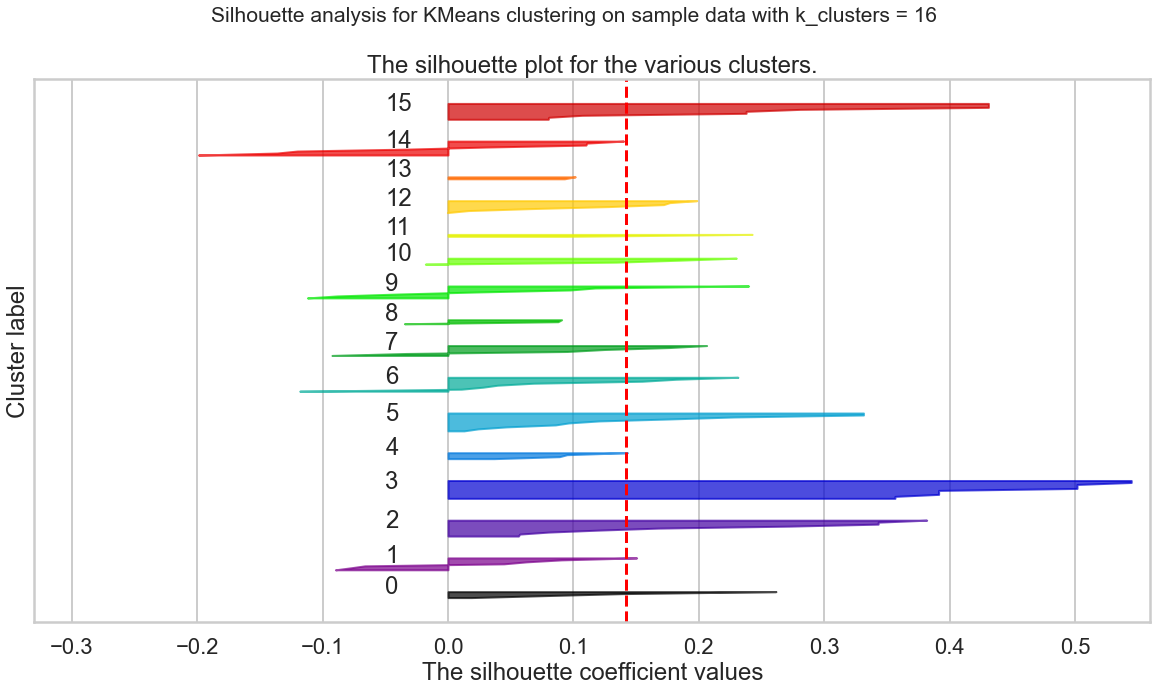

For n_clusters = 17 The average silhouette_score is : 0.1311703875908173


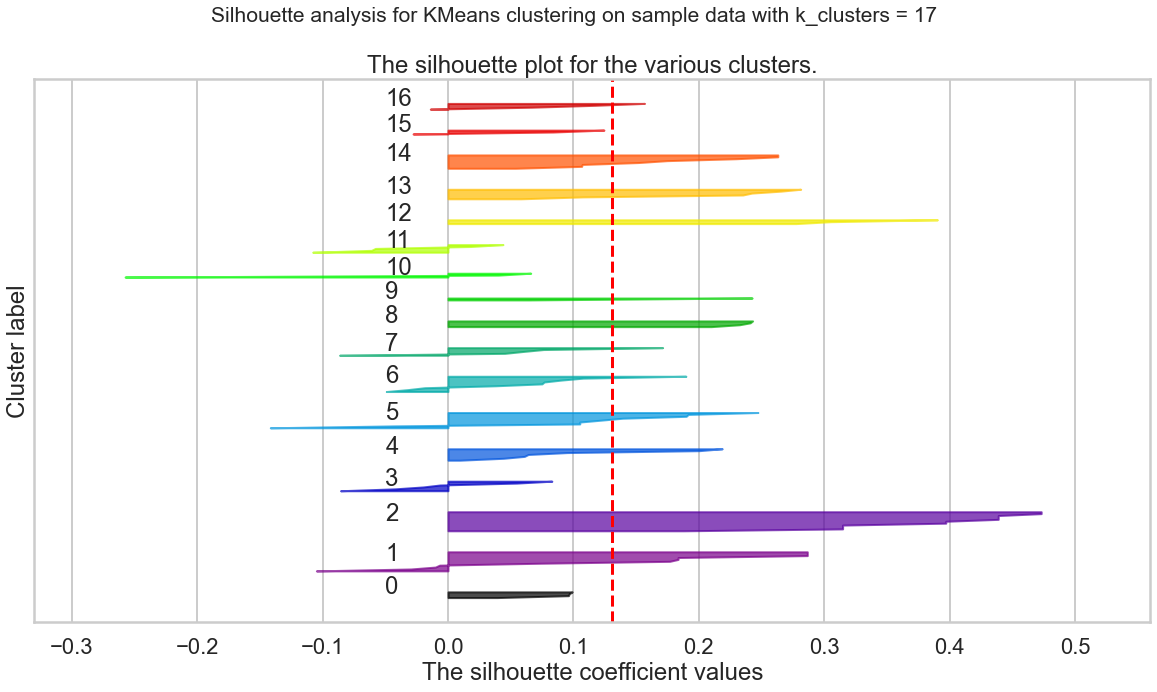

For n_clusters = 18 The average silhouette_score is : 0.12814092964696572


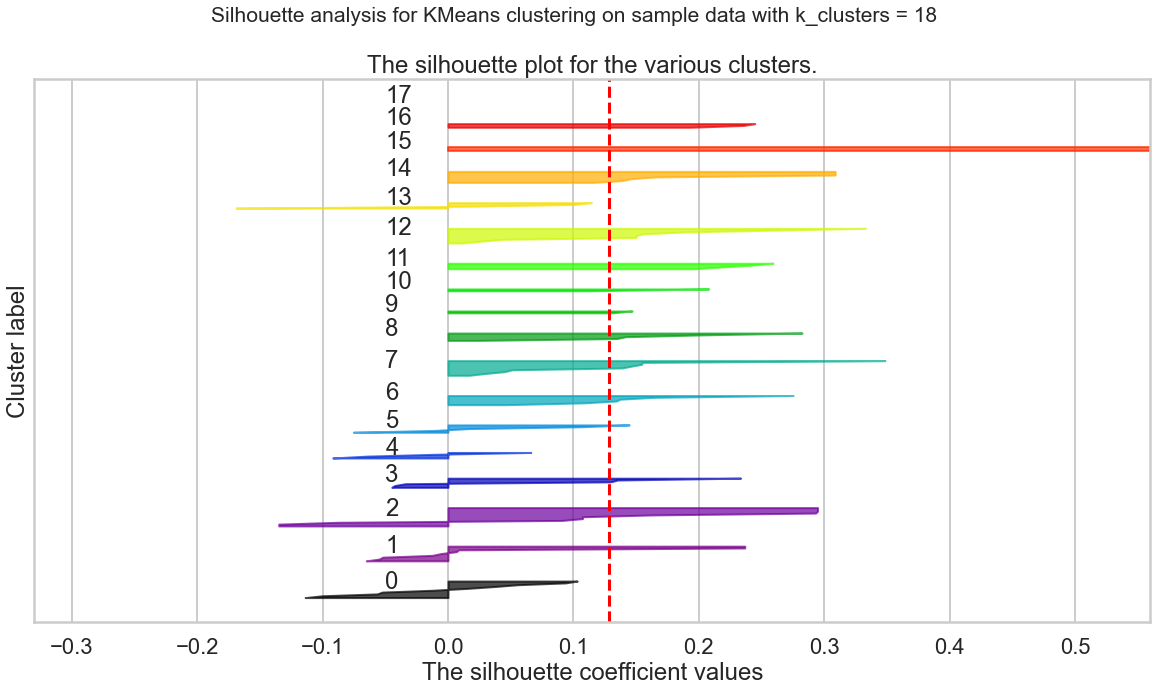

For n_clusters = 19 The average silhouette_score is : 0.13726449480720382


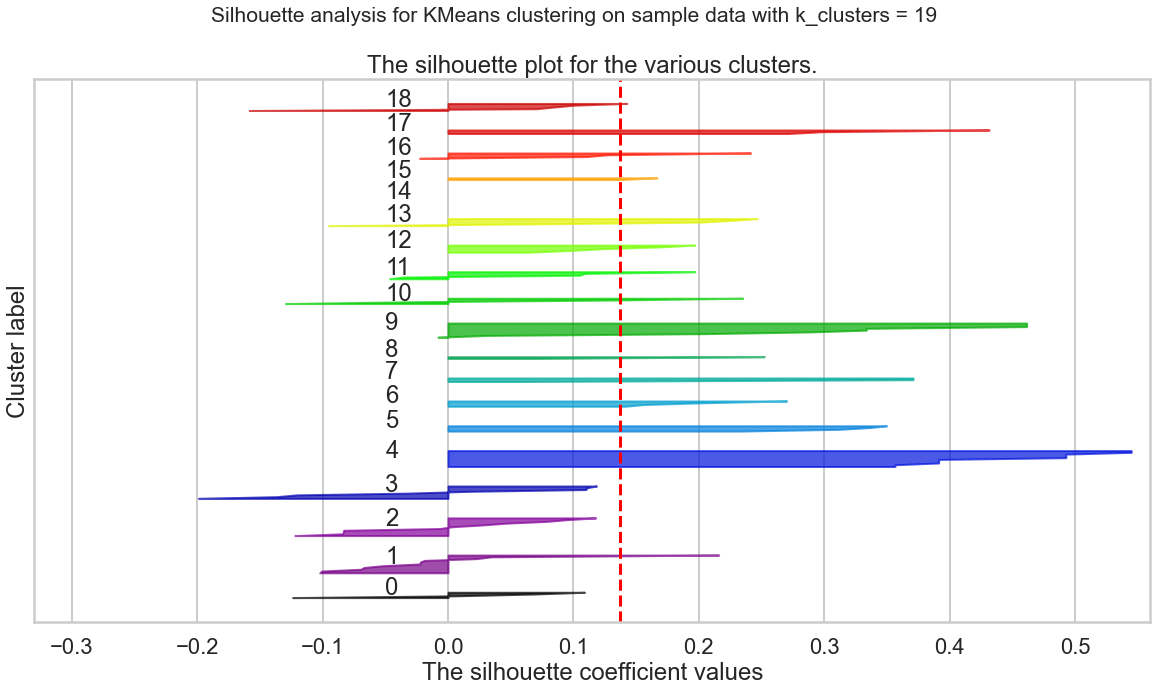

For n_clusters = 20 The average silhouette_score is : 0.13019931912638144


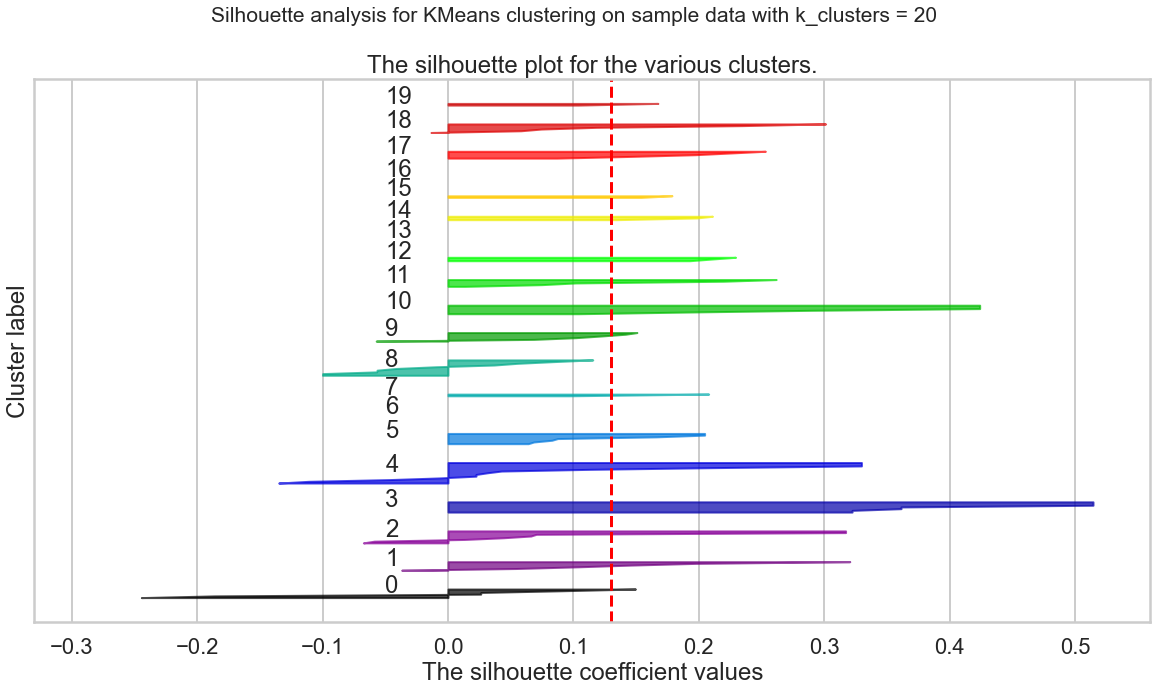

For n_clusters = 21 The average silhouette_score is : 0.12179096415791235


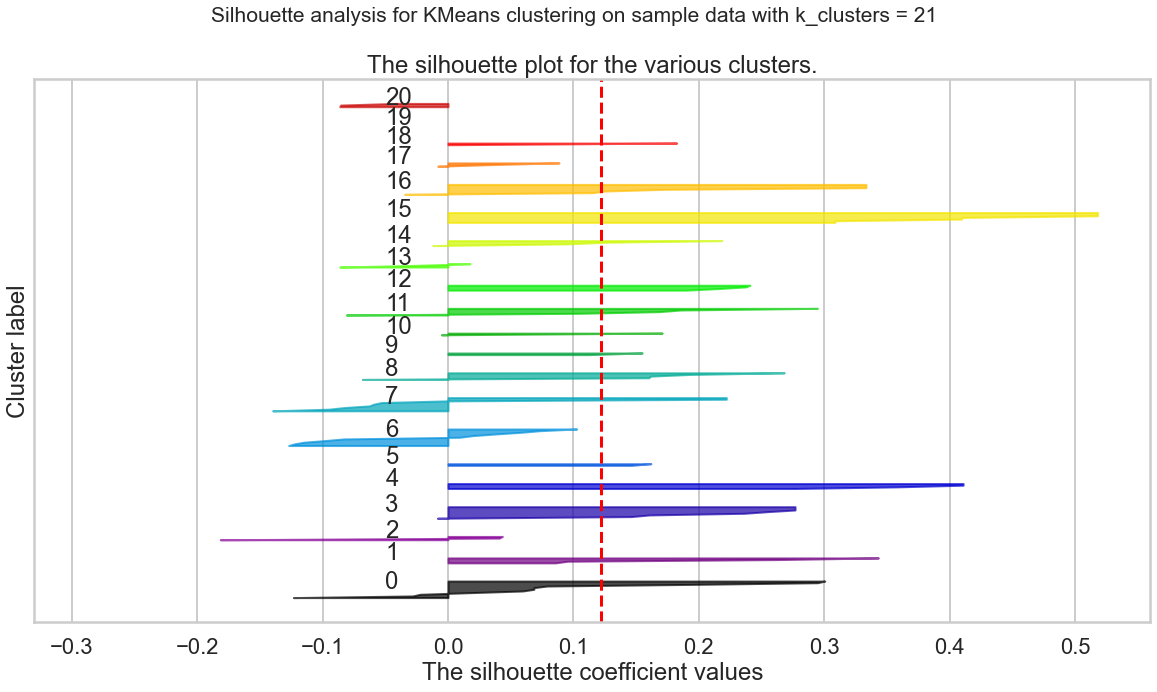

For n_clusters = 22 The average silhouette_score is : 0.14522472271471973


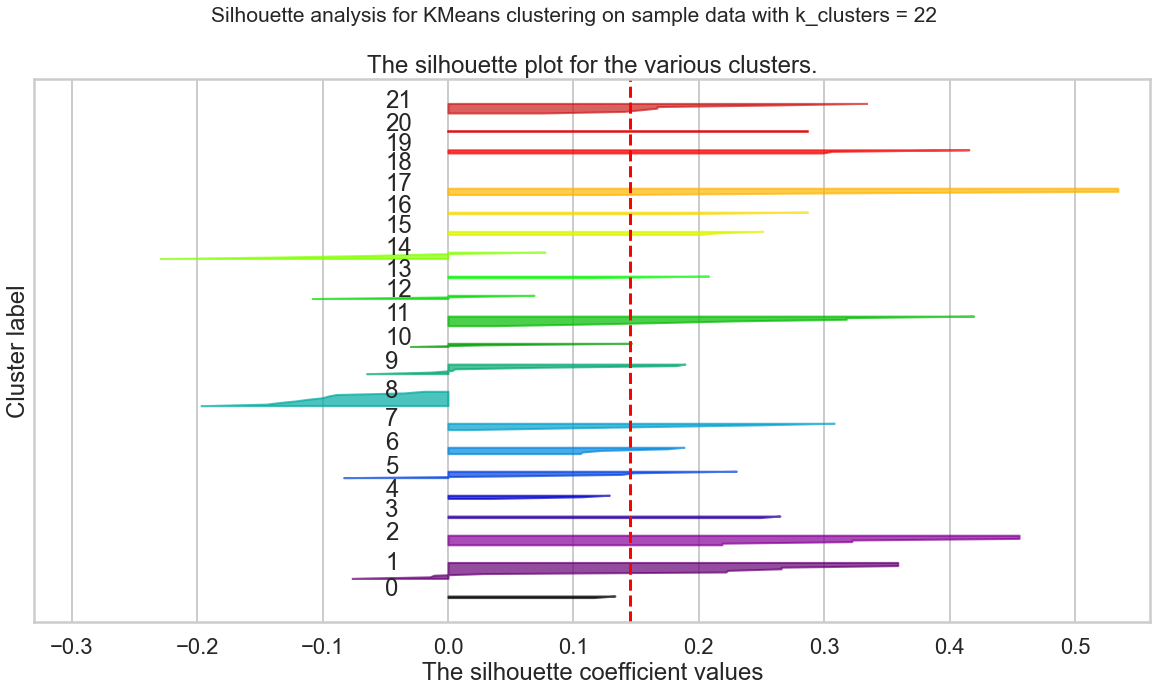

For n_clusters = 23 The average silhouette_score is : 0.10851112867170816


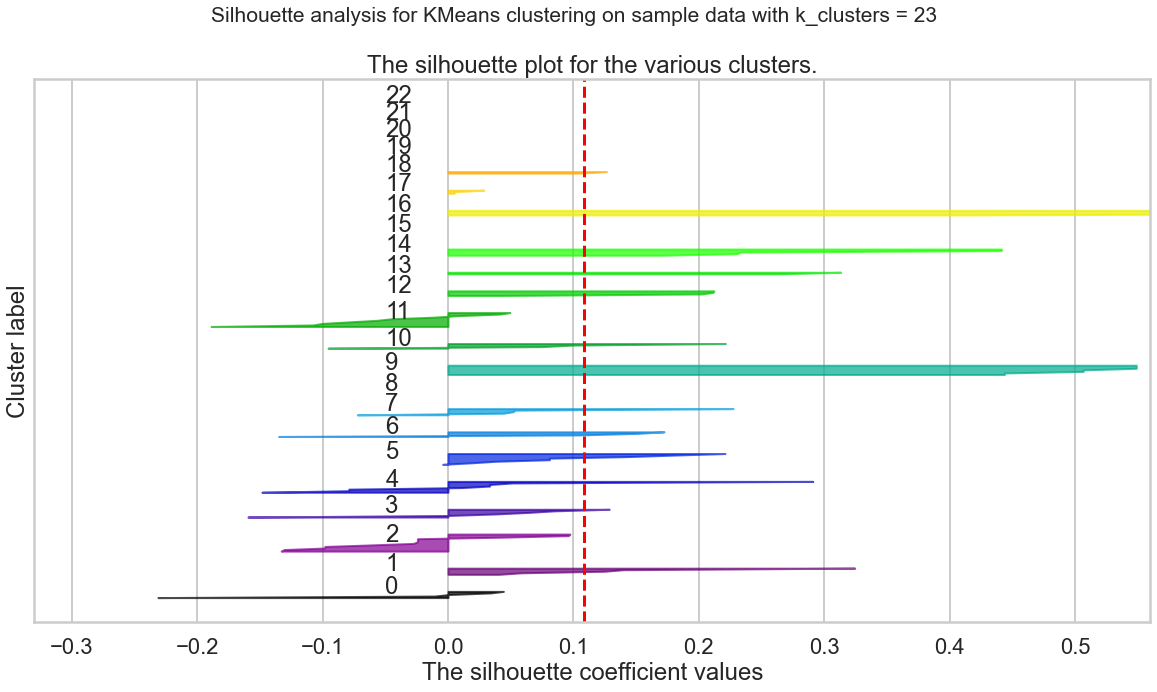

For n_clusters = 24 The average silhouette_score is : 0.1310073952675098


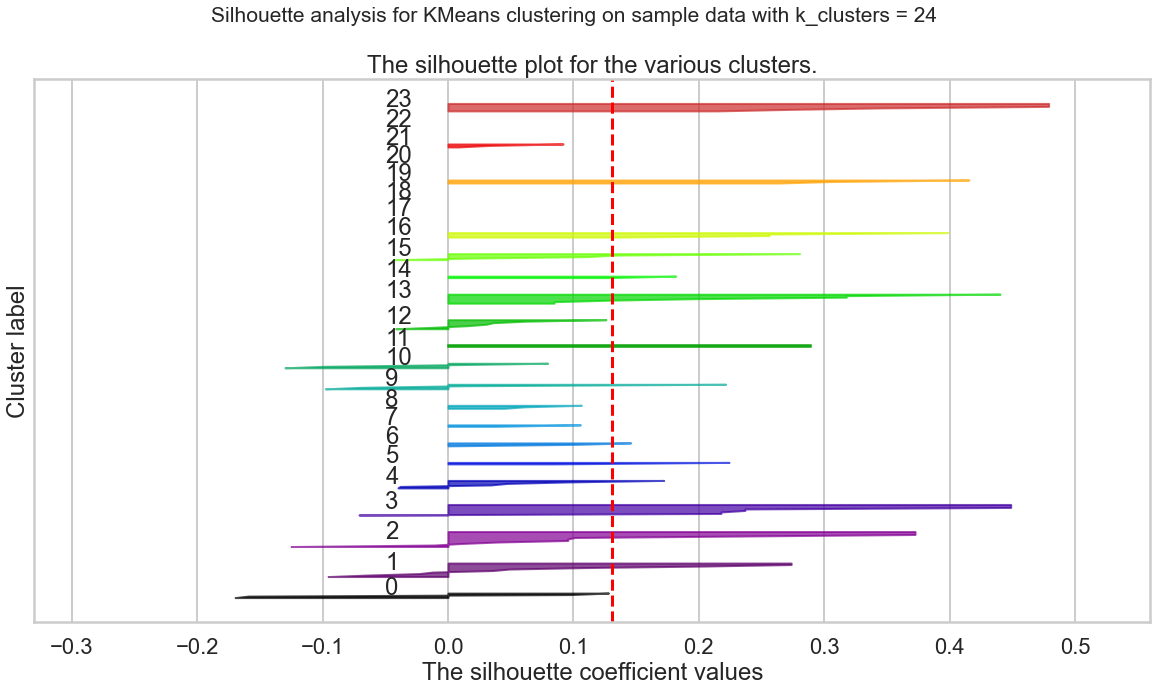

For n_clusters = 25 The average silhouette_score is : 0.1379133695147251


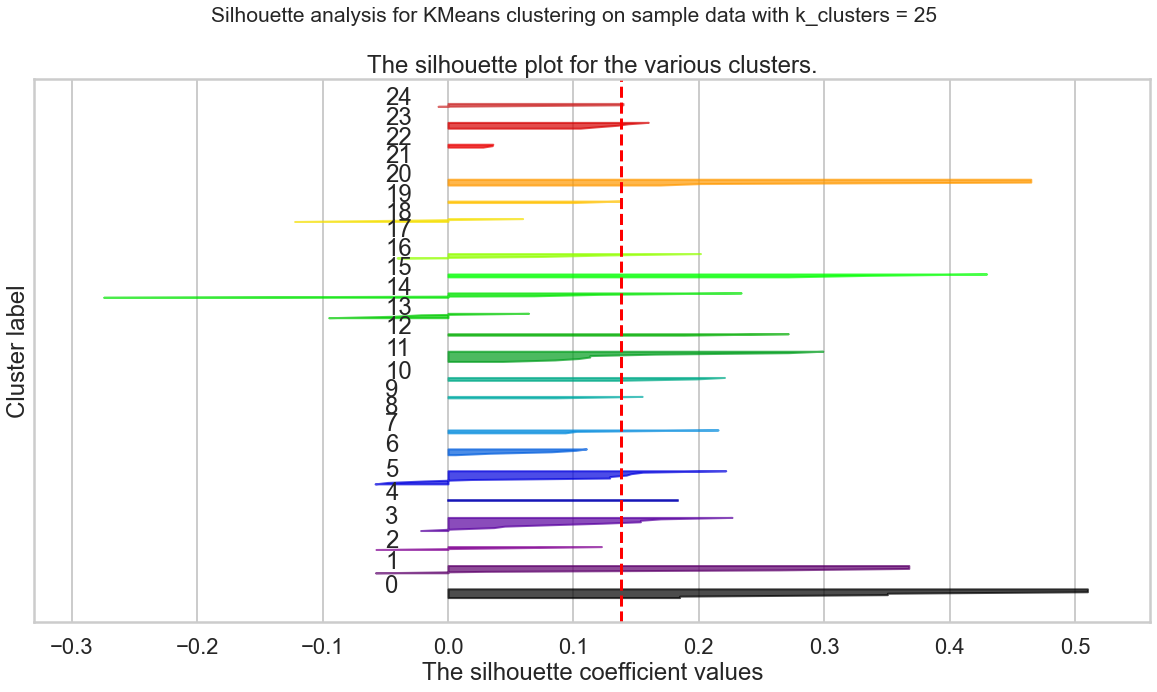

For n_clusters = 26 The average silhouette_score is : 0.12322101832615637


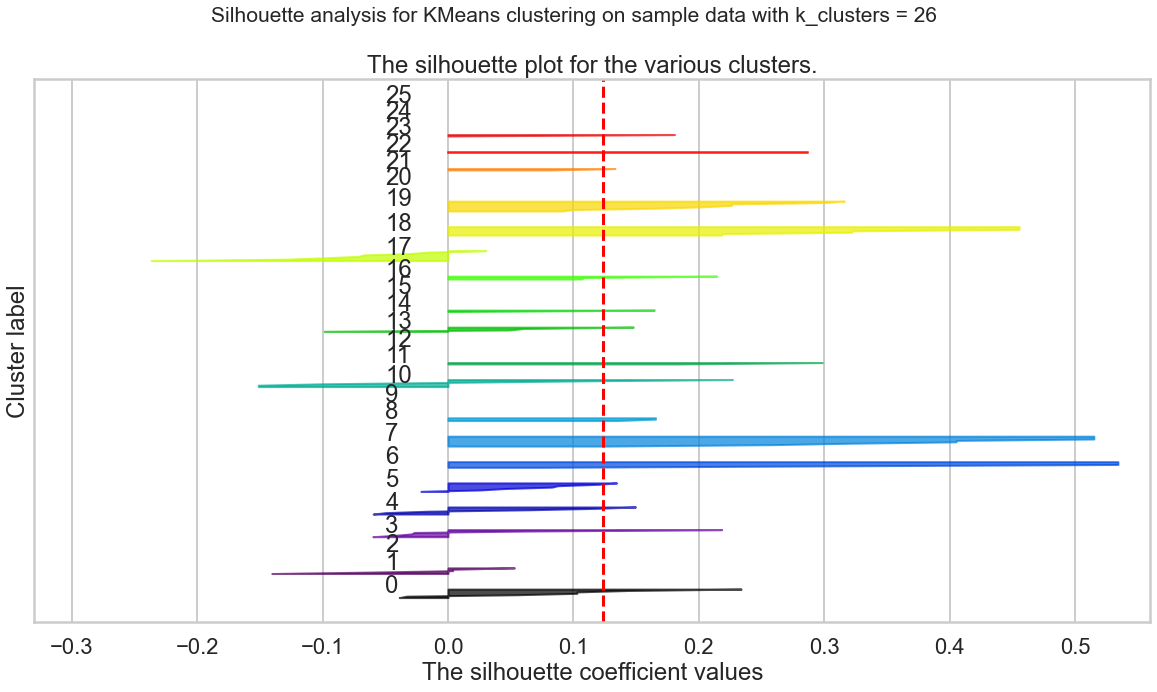

For n_clusters = 27 The average silhouette_score is : 0.13192867171390793


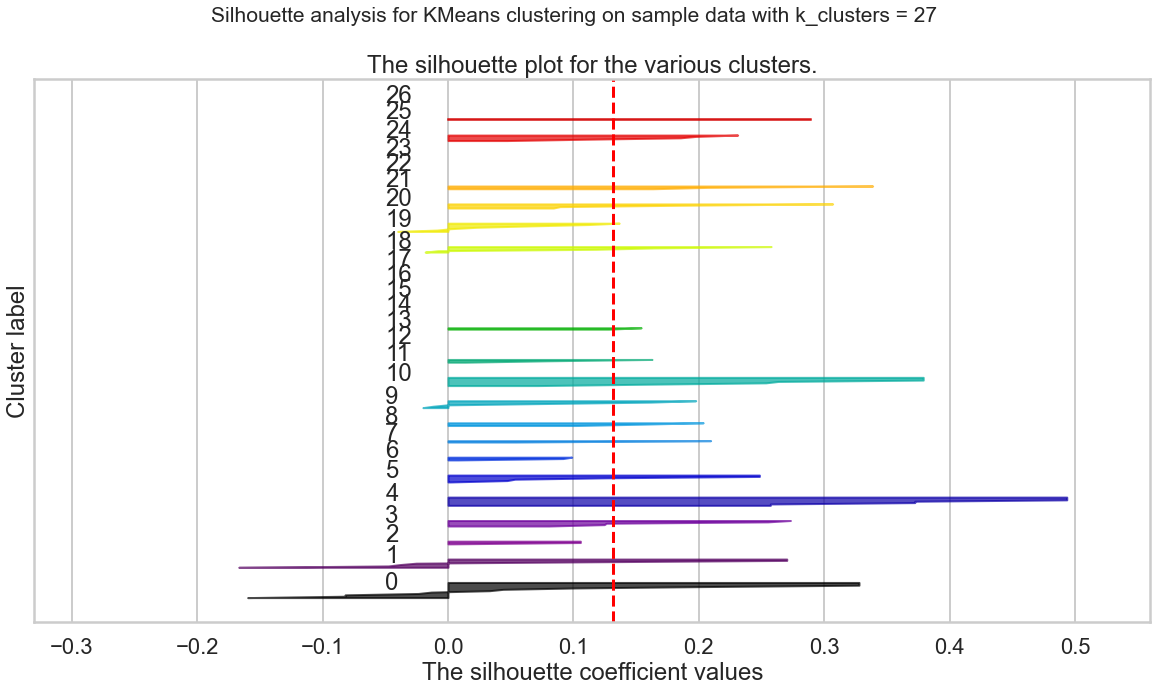

For n_clusters = 28 The average silhouette_score is : 0.13002384154801436


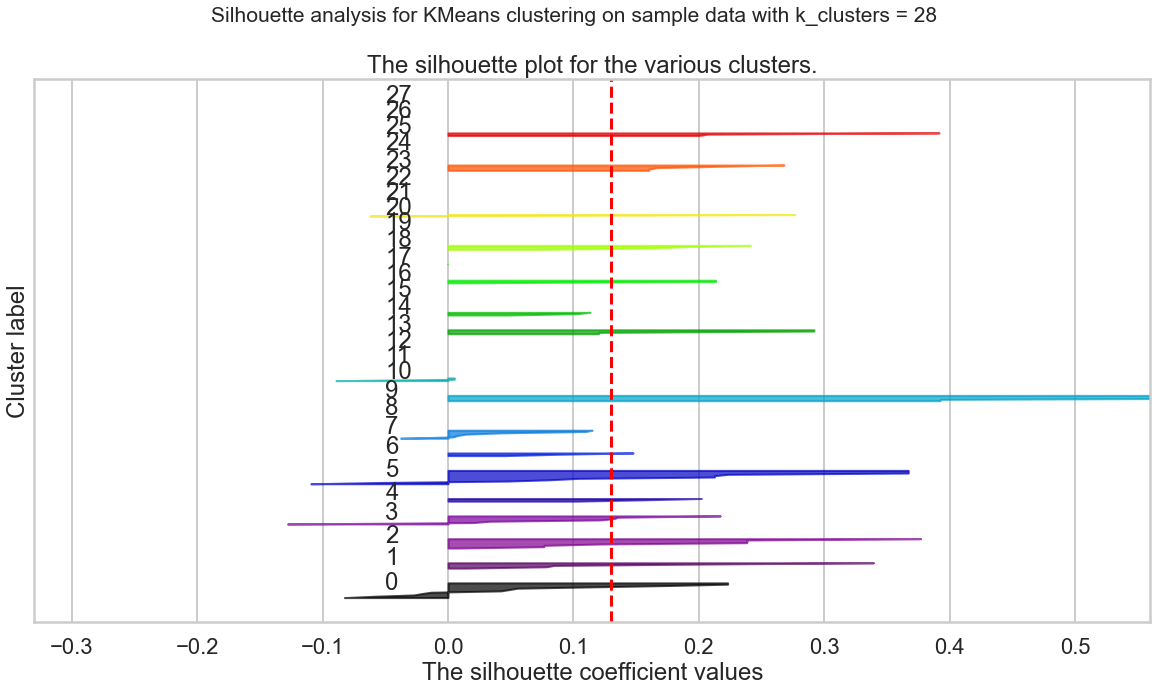

For n_clusters = 29 The average silhouette_score is : 0.1351543158719866


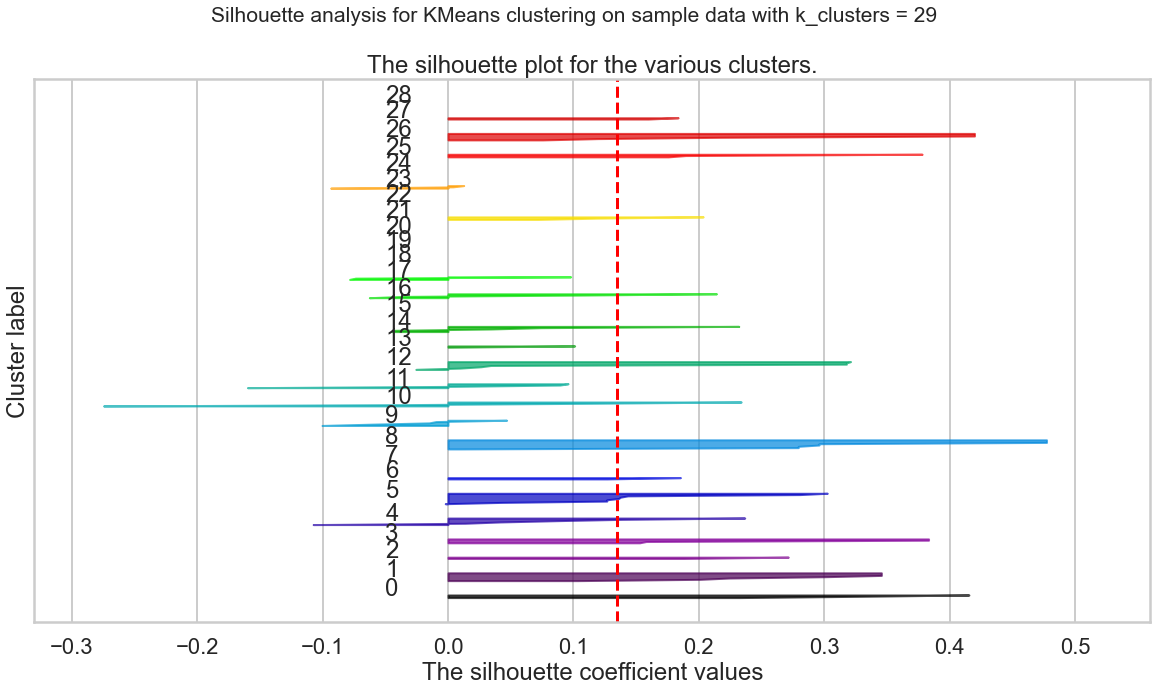

For n_clusters = 30 The average silhouette_score is : 0.1319821395848968


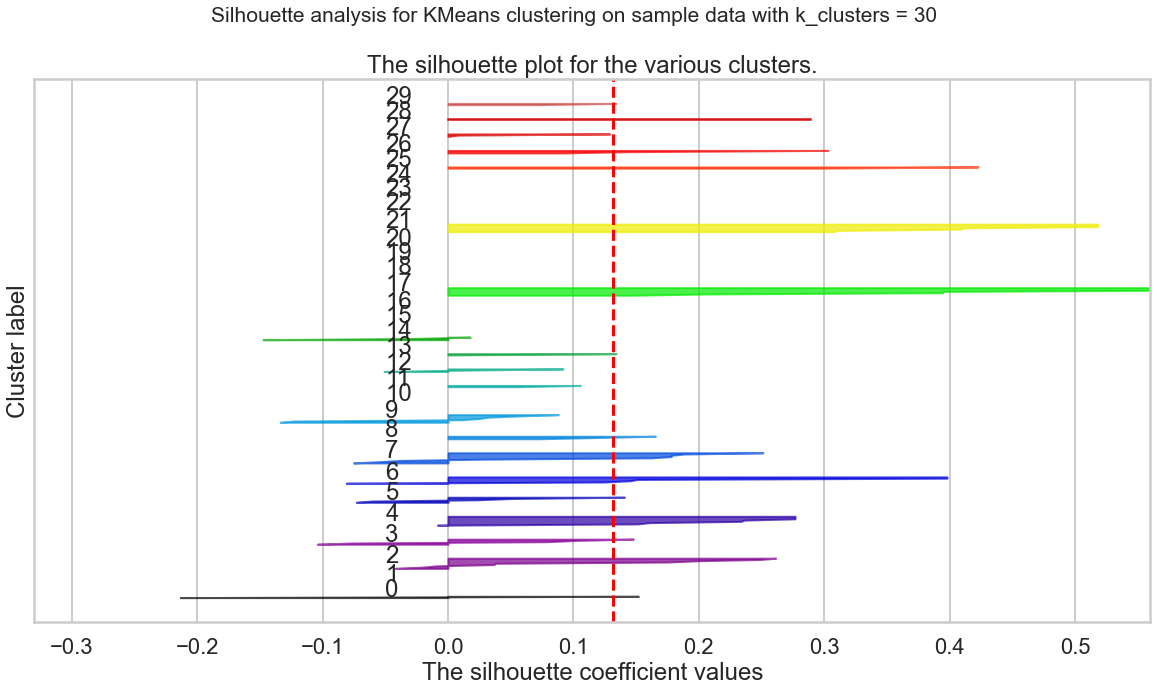

For n_clusters = 31 The average silhouette_score is : 0.14188745008341053


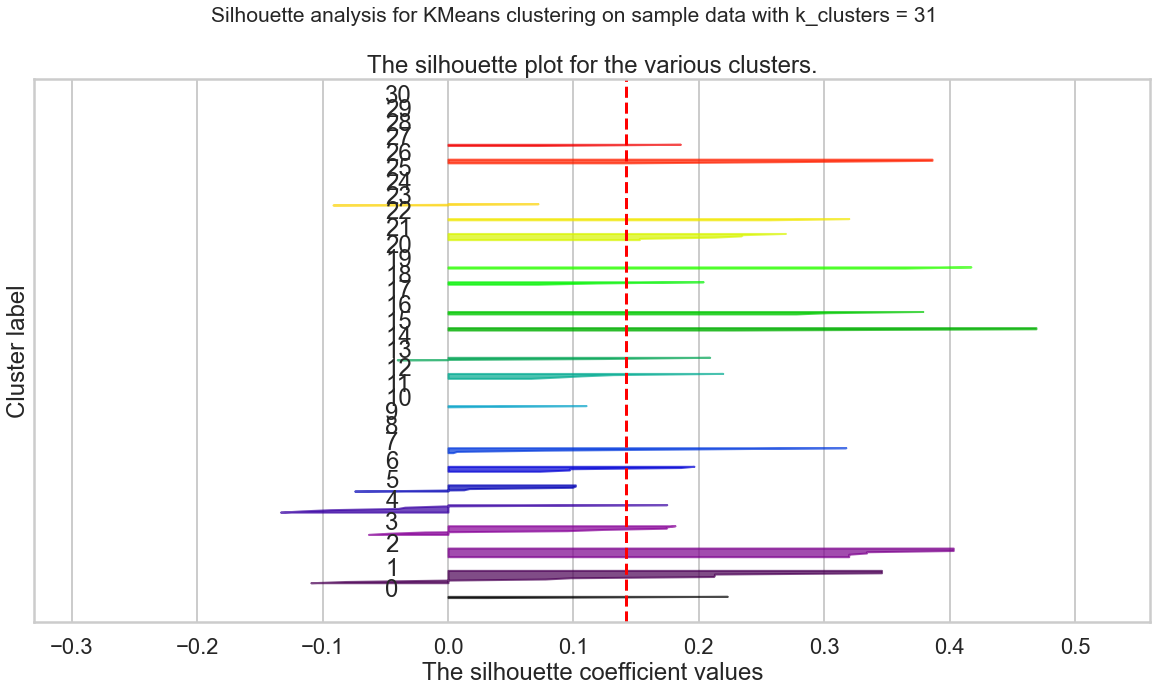

For n_clusters = 32 The average silhouette_score is : 0.14164352541560132


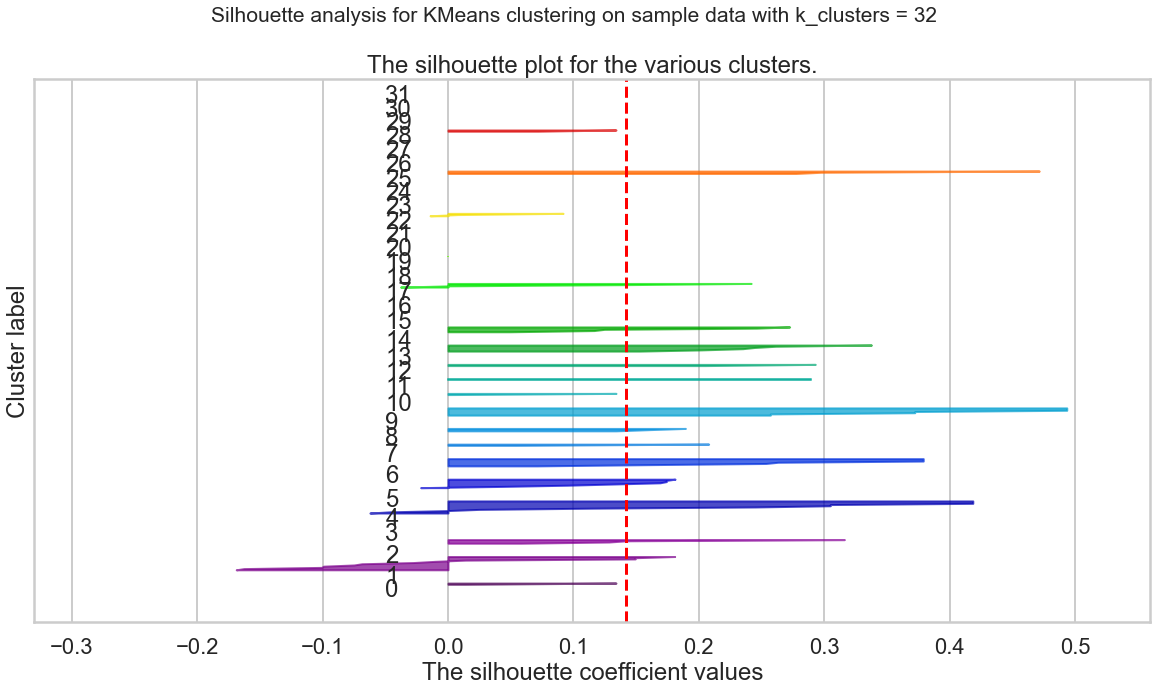

In [35]:
#let's look at MORE

#first convert to array lol

dummy_pivot_MASTER_array = dummy_pivot_MASTER.to_numpy()
#aH! i like how it BUMPS TO TOP the match that i guess it predicts
#you actually WANT based on i guess frequent/recent use!!! cuz soo many
#dummys but this is the new one of choice!!!! and it knowwwwwsssss! aH!

#just for fun, try going up to the number of offers lol
range_n_clusters = range(2,33)

for n_clusters in range_n_clusters:
    plt.figure(figsize=(20,10))
    
    plt.xlim([-.33,.56])

    # plt.ylim([0, len(dummy_X_array2) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    # clusterer = KMeans(n_clusters=n_clusters, n_init='auto',random_state=1)
    #lol DANNNNGG IT! this^ n_init auto still doesn't work even w/ everything else (iA) being right

    cluster_labels = clusterer.fit_predict(dummy_pivot_MASTER_array)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    #SO THIS IS THE *AVERAGE* SCORE FOR *ALL* SAMPLES FOR/@ THIS k CUZ REMEM -
    #SILHOUETTE IS CALCULATED FOR *EACH INDIVIDUAL SAMPLE*!!!!
    ###############################################################
    silhouette_avg = silhouette_score(dummy_pivot_MASTER_array, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg)

    # Compute the silhouette scores for each sample
    #LIKE LITERALLY FOR EACH *INDIVIDUAL* SAMPLE
    ###############################################################
    sample_silhouette_values = silhouette_samples(dummy_pivot_MASTER_array, cluster_labels)
    
    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper), 0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot

        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    # plt.xticks([-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([-.3, -.2, -.1, 0, .1, .2, .3, .4, .5])


    plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with k_clusters = %d"
    % n_clusters, fontsize=21)

    plt.show()


In [303]:
df.style.hide_index()

k  silhouette_average
0    2            0.091749
1    3            0.118899
2    4            0.121670
3    5            0.135286
4    6            0.132182
5    7            0.133652
6    8            0.124824
7    9            0.116866
8   10            0.108895
9   11            0.128678
10  12            0.133431
11  13            0.122453
12  14            0.148914
13  15            0.128203
14  16            0.142285
15  17            0.131170
16  18            0.128141
17  19            0.137264
18  20            0.130199
19  21            0.121791
20  22            0.145225
21  23            0.108511
22  24            0.131007
23  25            0.137913
24  26            0.123221
25  27            0.131929
26  28            0.130024
27  29            0.135154
28  30            0.131982
29  31            0.141887
30  32            0.141644

In [310]:
df.sort_values('silhouette_average', ascending=False).style.hide_index()

k  silhouette_average
12  14            0.148914
20  22            0.145225
14  16            0.142285
29  31            0.141887
30  32            0.141644
23  25            0.137913
17  19            0.137264
3    5            0.135286
27  29            0.135154
5    7            0.133652
10  12            0.133431
4    6            0.132182
28  30            0.131982
25  27            0.131929
15  17            0.131170
22  24            0.131007
18  20            0.130199
26  28            0.130024
9   11            0.128678
13  15            0.128203
16  18            0.128141
6    8            0.124824
24  26            0.123221
11  13            0.122453
19  21            0.121791
2    4            0.121670
1    3            0.118899
7    9            0.116866
8   10            0.108895
21  23            0.108511
0    2            0.091749

In [ ]:
#so is it that something with a HIGH silhouette avg overall will also necessarily
#have 'even'ish juts, like ~all's at least max at least hitting the line?
#but why is that what we want - what does that signify? that that's the best
#balance/trade-off of high silhouette value, which means tight clustering *AND*
#gapped clustering, to "evenness" of good clustering across the board/clusters?
#hmm, so/well yeah - if a high silhouette score means/can only be achieved by *OVERALL* GOOD
#CLUSTERING, then too can't overall good clustering and thus SILHOUETTE SCORE only
#be achieved by "EVEN CLUSTERING"?!?!?!?

#cuz documentation says we go w/ one w/ as said most even jutting / juts ~all hitting
#avg - so, let's see how k=2->11 compare/look like on that front! we've seen
#kmeans elbowing seems to suggest going w/ k=3, but really don't know, raw silly avg
#puts k=5 at tops, and k=3 as actually one of the lowest / sinkers/stinkers,
#so let's see what our EYES tell us!

#okay i looked and tbh based off that test / subjective/visual metric i'd probably
#say k=*10* BUT LOL THAT'S ONE OF THE WORST, EVEN WORSE THAN K=3!!!!! so dang! what gives??

#k=5 def doesn't look like the best - either in terms of OVERALL avg  or evenness -
#though only thing i can think of is that it's got 4/5 crossing line? but then k=10
#has 8/10?!?!
#as far as overall avg, tbh ALL from 5+ to 10 look strong! i mean the diff in avg as you
#can see isn't a whole lot, all low numbers at end of day lol - but i mean w/ 5 having
#LESS clusters ofc, it's got some *THICK* ones and one is pretty thick AND long,
#so i'm guessing that helps carry it thru? lots of MASS? short and stout lol
#like a small/short glass that actually has SAME if not MORE holding capacity/internal volume
#as MUCH TALLER GLASS!!!!!!!/cup
#but how can it be that something can have overall highest silhouette score from having
#pretty UNEVEN scoring clustering?? like if silhouette score factors in ALL THE OTHER CLUSTERS,
#then how can some clusters score really well and others NOT?? maybe some clusters are
#just NOT DENSE?!?!
##########################################################################################
##########################################################################################

In [ ]:
#And so REMEMBER the idea is that we wanna go for the one that has ideally
#NO SHIPS/FISH (lol lookin like those BIG WHALES! blubber nuggets) lookin
#like the ships above em!
#BEHIND THE RED/AVG LINE!!!!! lol in this case DON'T STAY BEHIND THE RED LINE! lol
#or obvy go w/ the one w/ the LEAST behind the line!
#and basically CANCEL the NEGATIVE direction ones as not counting lol! invalid!

#so the red line, remember, is the OVERALL AVERAGE SILHOUETTE VALUE FOR
#ALL POINTS FOR THAT k!!!
#DON'T GET CONFUSED!!!! WE'RE NOT GIVEN A *SEPARATE* AVG SILHOUETTE VALUE
#FOR *EACH GROUP/LABEL* WITHIN THAT k!
#Remember, all the possible groups for each k are listed out, '0' thru k-1 -
#simply to show the BREAKOUTS FOR *EACH* CLUSTER/LABEL!!!!!
#so all the points/samples that were labeled as that label are
#BAGGED TOGETHER!!!!!
#so *DON'T CONFUSE 'k#' OF THAT RUN w/ the *GROUP LABEL/CLUSTER#*!!!!!
#SO YEAH WE WANT TO GO W/ THE k THAT GIVES THE *HIGHEST* AVG SILHOUETTE
#SCORE OVERALL / OUT OF ALL k's!!!!! CUZ THAT INDICATES THE BEST CLUSTERING,
#CUZ IT MAXIMIZES *BOTH* TIGHTNESS OF CLUSTERS *&AND&* DISTANCE/GAP/SEPARATION
#*BETWEEN* CLUSTERS!!!!!!!
#SO NO NEED TO PICK A 'TRADE-OFF'!!!!! FUMBLE AROUND W/ AN 'ELBOW' LOLLL!
#sometimes ambiguous/subjective as in here/this case!!!!! instead
#go w/ a more DEFINITIVE/OBJECTIVE!
#so maybe would be good to run the silly EVEN IF WE FEEL CONFIDENT ABOUT WHAT
#THE ELBOW SAYS!!!!! JUST TO GET A GOOD/PROFESSIONAL/QUALIFIED/QUALITY/
#RESPECTABLE LOL SECOND OPINION!!!!!

In [ ]:
#so if we go based off the 'behind the red line' criteria,
#(would be nice to like filter out n only plot the lines for groups
#that had an avg ABOVE 0!) >> OH!!! just noticed!!! so many, if not all,
#categories that have negative yielding points, ALSO have positive ones!!!!
#remem - there's no k value for which the OVERALL AVERAGE WAS NEGATIVE!!!!
#worst was the LOWEST k aka k=2!!!! w/ avg_silly=.09!
#notice how they display it - w/ a little 'vertical split', i guess to make
#a little easier
#so again, won't know EXACTLY the GROUP/LABEL average, but can usually tell
#from just rough looking - like look @ k=14 (aka our BESTIE! :D): GroupLabel 1 (purple) is very clearly
#positive overall; but group *2 or 4* on the other hand are HARD TO TELL!!
#So again, the spread for each grouplabel is cuz we're plotting every
#INDIVIDUAL POINT cuz each point has its own silly score!
#and so some points within that cluster/label/group may have scored
#negatively cuz, as it said, THAT JUST MEANS THAT THOSE POINTS ARE *MISFITS*
#WITHIN THEIR GROUP!!!!! WOULD BE BETTER GROUPED ELSEWHERE, ACCORDING TO
#THESE MEASURES!!!!


#but yeah, so we wanna find the k that, overall, the GROUPS are mostly
#BEYOND the red line!
#what does this mean? well i guess for one this would mean that
#the groups are relatively more like EVEN and not so many EXTREMES?!
#cuz that would force more of them to protrude OUTWARD??
#i guess would also mean less negatives overall?
#but anyway, if you look at the leader of the pack - not that it's by a LONG SHOT,
#but k=14, you can kinda see why, relative to other choices - nice and even
#if you look, ALL BUT *2* GROUPS MAKE THE LINE!!! AND EVEN THOSE ONES ARE PRETTY CLOSE!!!!
#so their reasoning for that then lines up
#however, isn't that only going based on the HIGHEST value?? cuz again,
#we're not saying that grouplabel's AVERAGE value is beyond the OVERALL avg -
#but at the same time - OBVIOUSLY IT WOULDN'T BE POSSIBLE / PRACTICAL FOR *ALL*
#GROUP AVERAGES TO BE BEYOND THE OVERALL AVERAGE!!!!
#and also, isn't it like unfair cuz the LOWER k's have FEWER to try to get to!?

#and if you look at the next best k, k=22, it doesn't look as 'even'...
#so maybe that's not the criteria, or maybe like we can't look at it like that
#cuz too many, like we said? but i guess overall most things are well over
#or pretty close. but yeah on my postulated criteria of like 'evenness' seems
#like others might do better
#OH! BUT WHY I'M SAYING ME THAT?! CUZ OBVY IT'S IN ORDER OF *OVERALL AVG*,
#AND OVERALL AVG IS GONNA JUST MEAN *OVERALL HAS THE *HIGHEST* VALUE!
#So k=14 makes sense cuz the HIGHEST AVG. SCORING BAR, k=2,
# *IS ALSO THE *THICKEST* BAR!!!!!!

#so yeah then, when we pick a k based off Silhouette, if we're
#going for the BIGGEST avg silly val, then we'd just WANT em to overall
#be pushed out!!!

#BUT READING THE DOCUMENTATION IT *DOES* TALK ABOUT THE MORE *EVENNESS*
#THING AND *NOT* NECESS ABOUT THE *HIGHEST* OVERALL!!!!
#SO YES THEN, IT *IS* SUBJECTIVE HERE TOO!!!! LOLLLLL
#*NOT* OBJECTIVE!!!! but yeah DOESN'T TALK ABOUT LOOKING FOR *LOW k's* THO
#EITHER!!!! lolll

#okay, so one more time - if we're choosing based on nice jutting out/*peaking
#"peeping" over overall avg, then the ones (k's) that look good are:
#7, 9, 10, 11 except for 1 big negative lol,
#11 - 13 are good except for a big negative or two,
#but 14 DOES top those cuz definitely mitigates the negative issue
#where it looks like there's possibly NO group with a negative AVG! or at least
#not like OVERWHELMINGLY so!!!
#then 15-17 are good but not as good as 14
#18 seems very good, also 19 though 19 has some strongish negative presences
#20-30 you see this continuation of strong negative presences, even if they're
#only few in number. so that's why again it's kinda surprising to see that
#k=22 comes out as 2nd highest scoring,
#but again, it makes sense from the standpoint of SO MANY STRONG POSITIVES
#TO MORE THAN MAKE UP FOR IT!!! like so many are *WELLLL* BEYOND THE LINE!!!!

#31,32 don't have super weak/negative presences ESP given how many categories
#they have lol, just that - even tho they have plenty of avg.beaters/peakers,
#it's still too 'thin' a spread i guess - cuz REMEM! the point isn't
#to have a FEW *WAY BEYOND* avg, but rather ***MANY just at least TOUCHING avg*!!!!

#****tbh, if you look - after 25, aka from 26 thru the end 32, IT GET'S REALLY SPARSE!!!!****
#like it's like some categories are just STRAIGHT UP MISSING/EMPTY?!?!
#but you start to see that trickle in even earlier, like w/ 21,23

#so THUS, if we had to judge on this #EVENNESS IN PEAK REACHING AVG#, we'd go with:
#19, 25, 24, 22, 20, 

#OH YEAH! JUST REALIZED! so yeah, don't go by negative presence maybe cuz we're
#going by *PEAKERS* REACHING OVERALL AVG!!!!!! so like look @k=19, GroupLabel 3!
#(BTW! MY LABELING OF THE LABELS LOL IS TOTALLY OFF!!!! DOESN'T LINE UP W/ ITS PLOT!
#IT'S LIKE *ONE OFF, *HIGHER*!!!!) >> THERE'S WAY MORE NEGATIVE THAN POSITIVE,
#YET, PEAK JUST ABOUT REACHES OVERALL AVG!!!!!! so i guess that passes!

#though still not clear why this is the criteria? just a rule of thumb i guess?
#i mean i guess it's saying if AT LEAST all the PEAKS hit the average
#THEN WE CAN SAY OVERALL WE'RE IN GOOD SHAPE, AKA THAT SHOULD INDICATE THE
#BEST *OVERALL STATE FOR *ALL* CLUSTER'S WELLFARE/WELL-BEING!!!!!!
#well-fare/fare-well!
#18,17,16,15,14,12,11, 7, even 3 or TECHNICALLY EVEN 2!!!!!

#ALSO REMEM HOW ORIGINALLY WHEN I DID IT *WRONG* LOL I SAID
#TO MAKE THE CUTOFF SOMEHWERE IN THAT MIDDLE LIKE 14-16 RANGE!
#but lol in this updated/correct version, i gave a diff answer/
#much smaller, lol and DON'T think i'd say that!

For k = 10 The average silhouette_score is : 0.10889477148379977


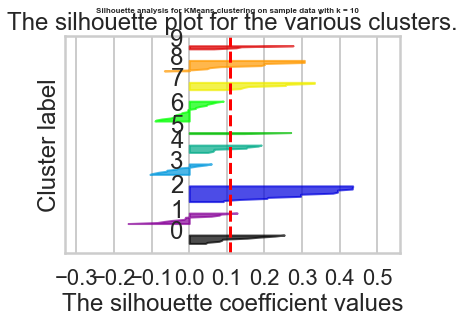

For k = 9 The average silhouette_score is : 0.11686562917000483


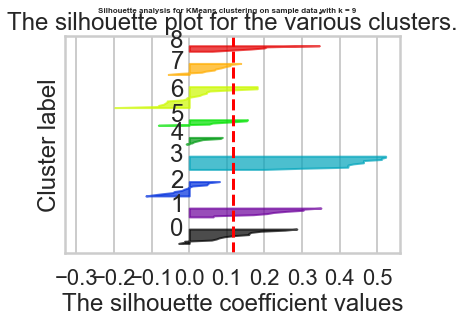

For k = 8 The average silhouette_score is : 0.12482407120722075


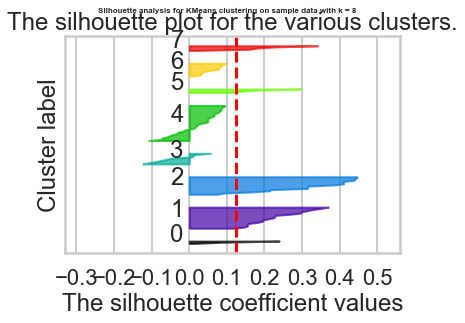

For k = 7 The average silhouette_score is : 0.13365227784322317


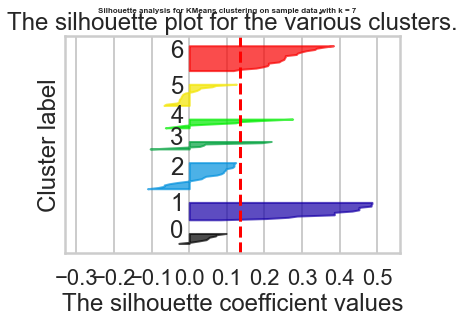

In [48]:
#lol final round

#let me also start to order in the order I THINK is best! like as far as
#OVERALL EVENNESS!!!! aka TEAM PERFORMANCE!!!!

#i know that we had k=3 & k=5 as winners, but again, this is for my own 'visual'
#selection/determination!

plt.figure(figsize=(20,10))
 
range_n_clusters = [10,9,8,7]

for k in range_n_clusters:
    plt.xlim([-.33,.56])


    clusterer = KMeans(n_clusters=k, random_state=1)

    cluster_labels = clusterer.fit_predict(dummy_pivot_MASTER_array)


    silhouette_avg = silhouette_score(dummy_pivot_MASTER_array, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg)


    sample_silhouette_values = silhouette_samples(dummy_pivot_MASTER_array, cluster_labels)
    
    y_lower = 10

    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper), 0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot

        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    # plt.xticks([-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([-.3, -.2, -.1, 0, .1, .2, .3, .4, .5])


    plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with k_clusters = %d"
    % n_clusters, fontsize=21)

    plt.show()


In [ ]:
#OHHH, btw, just rememd we don't necess need a random state (in silhouette)?
#like that was what they did in DOCS just for OUR REPRODUCIBILITY!!!
###########################################################################################

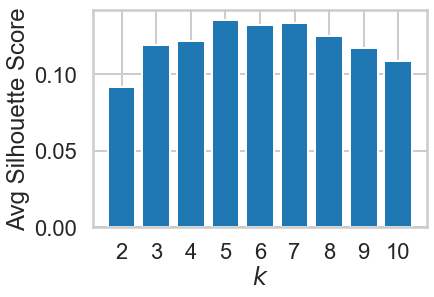

In [102]:
#here's what they recommended to do, w/ my own additions aH :D
#simply a visual like we said/saw, k=5 is tops
plt.bar(range(2,11), silhouette_averages)
plt.xlabel('$k$')
plt.ylabel("Avg Silhouette Score")
plt.xticks(range(2,11));

In [ ]:
#BUT HMMMMM! CAN WE SAY FROM HERE THAT ACTUALLY
#THIS INDICATES k=3 IS BEST CUZ THERE'S ONLY A SIGNIF
#JUMP FROM 2 TO 3 THEN AFTER THAT IT BARELY GOES UP!?!??!?!!?
#AND ALSO IS IT *SUPPOSED TO* FOLLOW THIS GENERAL PATTERN OF GOING UP
#THEN BACK DOWN?!?!
################################################

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [ ]:
#################################################
#okay so one thing we didn't do was look back at the
#original data to see if the clustering corresponded
#to anything interesting!!!

#so basically, we'd just plot the PCA again, but this time,
#instead of color by the MACHINE'S LABELS/CLUSTERS, we can
#cluster using our OWN labels!!!!!! choosing from the OTHER
#DATASET THEY PROVIDED US!!!!! SO *THAT'S* THE PURPOSE
#OF THAT OTHER DATASET!!!!!!* give us some options to try!!!!
#so this is like how Iris etc type clustering had like SPECIES to cross-ref with!
#in those cases, they had some preconceived notions about what
#the clustering might be based on and it was confirmed
#but in the real world, IT MAY NOT BE SO EASY!
#WE MAY HAVE TO DO EXACTLY THIS TO FIND OUT *WHAT IS IT
#THAT THE MACHINE IS FINDING THAT THESE SAMPLES *SPLIT* ON!!!!
#could it be that it doesn't correspond to ANY of the data
#we have? >> NO! THE PCA IS JUST A 'ROTATED' VERSION OF
#OUR DATA!!!!/THE DATA WE GAVE IT! SO IT'S JUST SHOWING US
#HOW TO LOOK AT IT, BUT IT'S UP TO US TO FIGURE OUT THE REST!!!!
#JUST GOTTA SEE WHAT FEATURE (OR FEATURES) ARE CAUSING THIS SEPARATION!!!!!!!

#################################################

In [118]:
df_transactions

customer_name  offer_id  n
0           Smith         2  1
1           Smith        24  1
2         Johnson        17  1
3         Johnson        24  1
4         Johnson        26  1
..            ...       ... ..
319        Fisher        11  1
320        Fisher        22  1
321        Fisher        28  1
322        Fisher        30  1
323        Fisher        31  1

[324 rows x 3 columns]

In [103]:
df_offers

offer_id   campaign            varietal  min_qty  discount        origin  \
0          1    January              Malbec       72        56        France   
1          2    January          Pinot Noir       72        17        France   
2          3   February           Espumante      144        32        Oregon   
3          4   February           Champagne       72        48        France   
4          5   February  Cabernet Sauvignon      144        44   New Zealand   
5          6      March            Prosecco      144        86         Chile   
6          7      March            Prosecco        6        40     Australia   
7          8      March           Espumante        6        45  South Africa   
8          9      April          Chardonnay      144        57         Chile   
9         10      April            Prosecco       72        52    California   
10        11        May           Champagne       72        85        France   
11        12        May            Prosecco       72        83     Australia   
12        13        May              Merlot        6        43         Chile   
13        14       June              Merlot       72        64         Chile   
14        15       June  Cabernet Sauvignon      144        19         Italy   
15        16       June              Merlot       72        88    California   
16        17       July          Pinot Noir       12        47       Germany   
17        18       July           Espumante        6        50        Oregon   
18        19       July           Champagne       12        66       Germany   
19        20     August  Cabernet Sauvignon       72        82         Italy   
20        21     August           Champagne       12        50    California   
21        22     August           Champagne       72        63        France   
22        23  September          Chardonnay      144        39  South Africa   
23        24  September          Pinot Noir        6        34         Italy   
24        25    October  Cabernet Sauvignon       72        59        Oregon   
25        26    October          Pinot Noir      144        83     Australia   
26        27    October           Champagne       72        88   New Zealand   
27        28   November  Cabernet Sauvignon       12        56        France   
28        29   November        Pinot Grigio        6        87        France   
29        30   December              Malbec        6        54        France   
30        31   December           Champagne       72        89        France   
31        32   December  Cabernet Sauvignon       72        45       Germany   

    past_peak  
0       False  
1       False  
2        True  
3        True  
4        True  
5       False  
6        True  
7       False  
8       False  
9       False  
10      False  
11      False  
12      False  
13      False  
14      False  
15      False  
16      False  
17      False  
18      False  
19      False  
20      False  
21      False  
22      False  
23      False  
24       True  
25      False  
26      False  
27       True  
28      False  
29      False  
30      False  
31       True

In [ ]:
#okay, so...
#our original data is about:
    #1. each of the 32 offers
    #2. each of the 324 customer transactions (offers taken) of the
       #100 customers
#the PCA clusters are ONLY based on the transactions/offers taken of each of these 100 individual CUSTOMERS
#so we can't add any other label data to these PCA clusters ie we can't color them
#by a different label, cuz none of the other data corresponds uniquely to the
#customer, but rather is about the OFFER!
#.... unless, we can maybe COMBINE the data about the OFFERS with the customer data?
#but then it wouldn't just be one line/row per customer right?
#or could it? like if a customer took both offers 1 & 2,...
#hmm, well, we already have that yes/no BINARY data, but that doesn't factor in
#WHAT those offers were for...

#hmmm, so maybe we could do another PCA on the other df... or, simply PULL IN
#the 'varietal' data that corresponds to the offer_id, and then see how the breakdowns are and color by variety

#or, can we just CONVERT the offer_id labels to their corresponding varietals


In [ ]:
#hmmm, okay, so far nothing good w/ these guys

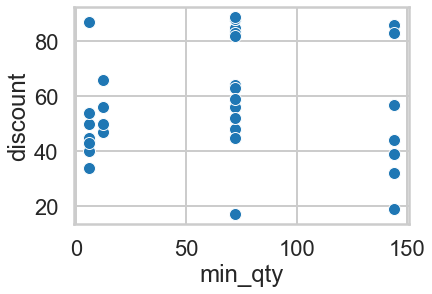

In [106]:
sns.scatterplot(x=df_offers.min_qty, y=df_offers.discount);

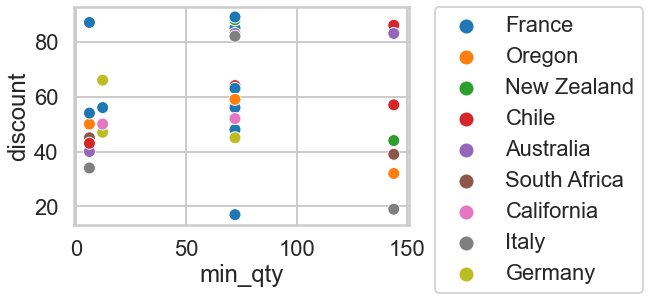

In [112]:
sns.scatterplot(data=df_offers,x='min_qty',y='discount',hue='origin')
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.7, 1));

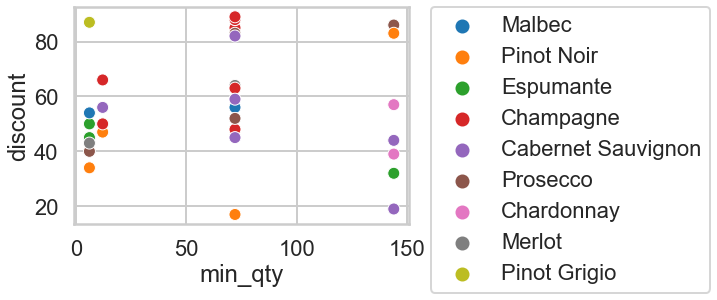

In [114]:
sns.scatterplot(data=df_offers,x='min_qty',y='discount',hue='varietal')
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.9, 1));

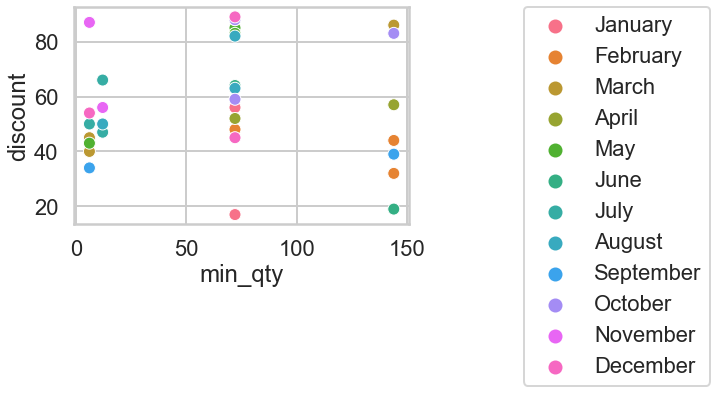

In [115]:
sns.scatterplot(data=df_offers,x='min_qty',y='discount',hue='campaign')
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.9, 1));

In [126]:
df_offers.origin.value_counts()

France          9
Chile           4
Oregon          3
Australia       3
California      3
Italy           3
Germany         3
New Zealand     2
South Africa    2
Name: origin, dtype: int64

In [127]:
df_offers.varietal.value_counts()

Champagne             7
Cabernet Sauvignon    6
Pinot Noir            4
Prosecco              4
Espumante             3
Merlot                3
Malbec                2
Chardonnay            2
Pinot Grigio          1
Name: varietal, dtype: int64

In [136]:
#what do the clusters correspond to?
#well, okay - let's first of all JOIN the two datas!

# df_transactions_trim.join(df_offers,on='offer_id',rsuffix='_new')

#man, okay - confusing - i have to go back n review, but .join is really weird for joining, ironically,
#but .merge works great!:
join=df_transactions_trim.merge(df_offers)
join

customer_name  offer_id campaign    varietal  min_qty  discount  origin  \
0           Smith         2  January  Pinot Noir       72        17  France   
1       Rodriguez         2  January  Pinot Noir       72        17  France   
2          Martin         2  January  Pinot Noir       72        17  France   
3         Jackson         2  January  Pinot Noir       72        17  France   
4        Campbell         2  January  Pinot Noir       72        17  France   
..            ...       ...      ...         ...      ...       ...     ...   
319          Hill        13      May      Merlot        6        43   Chile   
320        Carter        13      May      Merlot        6        43   Chile   
321         James        13      May      Merlot        6        43   Chile   
322        Hughes        13      May      Merlot        6        43   Chile   
323      Sullivan        13      May      Merlot        6        43   Chile   

     past_peak  
0        False  
1        False  
2        False  
3        False  
4        False  
..         ...  
319      False  
320      False  
321      False  
322      False  
323      False  

[324 rows x 8 columns]

In [131]:
#okay, so now we can try to pivot table this?


#or actually, let's just see how the OFFERS are divided up?

df_offers.pivot_table(index='varietal',columns='campaign',values='offer_id',aggfunc='count')

campaign            April  August  December  February  January  July  June  \
varietal                                                                     
Cabernet Sauvignon    NaN     1.0       1.0       1.0      NaN   NaN   1.0   
Champagne             NaN     2.0       1.0       1.0      NaN   1.0   NaN   
Chardonnay            1.0     NaN       NaN       NaN      NaN   NaN   NaN   
Espumante             NaN     NaN       NaN       1.0      NaN   1.0   NaN   
Malbec                NaN     NaN       1.0       NaN      1.0   NaN   NaN   
Merlot                NaN     NaN       NaN       NaN      NaN   NaN   2.0   
Pinot Grigio          NaN     NaN       NaN       NaN      NaN   NaN   NaN   
Pinot Noir            NaN     NaN       NaN       NaN      1.0   1.0   NaN   
Prosecco              1.0     NaN       NaN       NaN      NaN   NaN   NaN   

campaign            March  May  November  October  September  
varietal                                                      
Cabernet Sauvignon    NaN  NaN       1.0      1.0        NaN  
Champagne             NaN  1.0       NaN      1.0        NaN  
Chardonnay            NaN  NaN       NaN      NaN        1.0  
Espumante             1.0  NaN       NaN      NaN        NaN  
Malbec                NaN  NaN       NaN      NaN        NaN  
Merlot                NaN  1.0       NaN      NaN        NaN  
Pinot Grigio          NaN  NaN       1.0      NaN        NaN  
Pinot Noir            NaN  NaN       NaN      1.0        1.0  
Prosecco              2.0  1.0       NaN      NaN        NaN

In [134]:
df_offers.pivot_table(index='offer_id',columns='varietal',values='campaign',aggfunc='count')

varietal  Cabernet Sauvignon  Champagne  Chardonnay  Espumante  Malbec  \
offer_id                                                                 
1                        NaN        NaN         NaN        NaN     1.0   
2                        NaN        NaN         NaN        NaN     NaN   
3                        NaN        NaN         NaN        1.0     NaN   
4                        NaN        1.0         NaN        NaN     NaN   
5                        1.0        NaN         NaN        NaN     NaN   
6                        NaN        NaN         NaN        NaN     NaN   
7                        NaN        NaN         NaN        NaN     NaN   
8                        NaN        NaN         NaN        1.0     NaN   
9                        NaN        NaN         1.0        NaN     NaN   
10                       NaN        NaN         NaN        NaN     NaN   
11                       NaN        1.0         NaN        NaN     NaN   
12                       NaN        NaN         NaN        NaN     NaN   
13                       NaN        NaN         NaN        NaN     NaN   
14                       NaN        NaN         NaN        NaN     NaN   
15                       1.0        NaN         NaN        NaN     NaN   
16                       NaN        NaN         NaN        NaN     NaN   
17                       NaN        NaN         NaN        NaN     NaN   
18                       NaN        NaN         NaN        1.0     NaN   
19                       NaN        1.0         NaN        NaN     NaN   
20                       1.0        NaN         NaN        NaN     NaN   
21                       NaN        1.0         NaN        NaN     NaN   
22                       NaN        1.0         NaN        NaN     NaN   
23                       NaN        NaN         1.0        NaN     NaN   
24                       NaN        NaN         NaN        NaN     NaN   
25                       1.0        NaN         NaN        NaN     NaN   
26                       NaN        NaN         NaN        NaN     NaN   
27                       NaN        1.0         NaN        NaN     NaN   
28                       1.0        NaN         NaN        NaN     NaN   
29                       NaN        NaN         NaN        NaN     NaN   
30                       NaN        NaN         NaN        NaN     1.0   
31                       NaN        1.0         NaN        NaN     NaN   
32                       1.0        NaN         NaN        NaN     NaN   

varietal  Merlot  Pinot Grigio  Pinot Noir  Prosecco  
offer_id                                              
1            NaN           NaN         NaN       NaN  
2            NaN           NaN         1.0       NaN  
3            NaN           NaN         NaN       NaN  
4            NaN           NaN         NaN       NaN  
5            NaN           NaN         NaN       NaN  
6            NaN           NaN         NaN       1.0  
7            NaN           NaN         NaN       1.0  
8            NaN           NaN         NaN       NaN  
9            NaN           NaN         NaN       NaN  
10           NaN           NaN         NaN       1.0  
11           NaN           NaN         NaN       NaN  
12           NaN           NaN         NaN       1.0  
13           1.0           NaN         NaN       NaN  
14           1.0           NaN         NaN       NaN  
15           NaN           NaN         NaN       NaN  
16           1.0           NaN         NaN       NaN  
17           NaN           NaN         1.0       NaN  
18           NaN           NaN         NaN       NaN  
19           NaN           NaN         NaN       NaN  
20           NaN           NaN         NaN       NaN  
21           NaN           NaN         NaN       NaN  
22           NaN           NaN         NaN       NaN  
23           NaN           NaN         NaN       NaN  
24           NaN           NaN         1.0       NaN  
25           NaN           NaN         NaN       NaN 

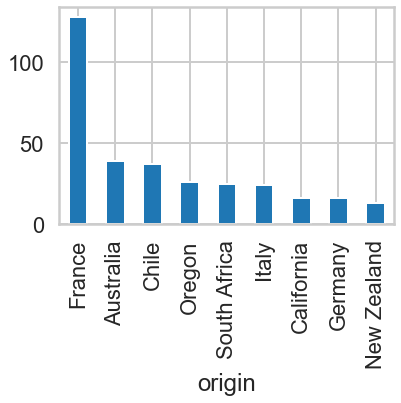

In [150]:
join.value_counts('origin').plot(kind='bar');

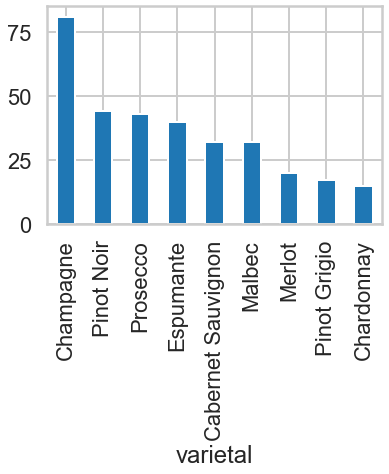

In [151]:
join.value_counts('varietal').plot(kind='bar');

In [154]:
join.pivot_table(index='origin', columns='varietal',values='past_peak',aggfunc='count')

varietal      Cabernet Sauvignon  Champagne  Chardonnay  Espumante  Malbec  \
origin                                                                       
Australia                    NaN        NaN         NaN        NaN     NaN   
California                   NaN        4.0         NaN        NaN     NaN   
Chile                        NaN        NaN        10.0        NaN     NaN   
France                       6.0       63.0         NaN        NaN    32.0   
Germany                      4.0        5.0         NaN        NaN     NaN   
Italy                       12.0        NaN         NaN        NaN     NaN   
New Zealand                  4.0        9.0         NaN        NaN     NaN   
Oregon                       6.0        NaN         NaN       20.0     NaN   
South Africa                 NaN        NaN         5.0       20.0     NaN   

varietal      Merlot  Pinot Grigio  Pinot Noir  Prosecco  
origin                                                    
Australia        NaN           NaN        15.0      24.0  
California       5.0           NaN         NaN       7.0  
Chile           15.0           NaN         NaN      12.0  
France           NaN          17.0        10.0       NaN  
Germany          NaN           NaN         7.0       NaN  
Italy            NaN           NaN        12.0       NaN  
New Zealand      NaN           NaN         NaN       NaN  
Oregon           NaN           NaN         NaN       NaN  
South Africa     NaN           NaN         NaN       NaN

In [157]:
#well, France dominated the popularity, countries wise
#type wise, it was champagne, which, of course, is overwhelmingly dominated too by France
#talk about the world 'cup'! or maybe world 'glass'!/bottle!

#okay so like %of french-related

join.pivot_table(index='customer_name',columns='origin',values='past_peak',aggfunc='count')

origin         Australia  California  Chile  France  Germany  Italy  \
customer_name                                                         
Adams                NaN         NaN    NaN     2.0      NaN    NaN   
Allen                NaN         NaN    1.0     NaN      NaN    NaN   
Anderson             1.0         NaN    NaN     NaN      NaN    1.0   
Bailey               1.0         NaN    NaN     1.0      NaN    NaN   
Baker                1.0         1.0    NaN     1.0      1.0    NaN   
...                  ...         ...    ...     ...      ...    ...   
Williams             NaN         NaN    NaN     2.0      NaN    NaN   
Wilson               NaN         NaN    NaN     1.0      NaN    NaN   
Wood                 NaN         1.0    1.0     2.0      NaN    NaN   
Wright               NaN         1.0    1.0     1.0      NaN    NaN   
Young                NaN         NaN    2.0     2.0      1.0    1.0   

origin         New Zealand  Oregon  South Africa  
customer_name                                     
Adams                  NaN     1.0           NaN  
Allen                  1.0     NaN           NaN  
Anderson               NaN     NaN           NaN  
Bailey                 NaN     NaN           NaN  
Baker                  NaN     NaN           NaN  
...                    ...     ...           ...  
Williams               NaN     1.0           NaN  
Wilson                 NaN     NaN           1.0  
Wood                   NaN     NaN           NaN  
Wright                 1.0     NaN           NaN  
Young                  NaN     NaN           NaN  

[100 rows x 9 columns]

In [159]:
origin = join.pivot_table(index='customer_name',columns='origin',values='past_peak',aggfunc='count')

origin['France'].value_counts()

1.0    34
2.0    29
3.0     4
4.0     3
5.0     1
7.0     1
Name: France, dtype: int64

In [161]:
#check TOTAL amount bought!
#1, 2, 3+!!!

totals = join.pivot_table(index='customer_name',columns='offer_id',values='past_peak',aggfunc='count',margins=True)

totals

offer_id          1     2    3     4    5     6     7     8     9   10  ...  \
customer_name                                                           ...   
Adams           NaN   NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN  NaN  ...   
Allen           NaN   NaN  NaN   NaN  NaN   NaN   NaN   NaN   1.0  NaN  ...   
Anderson        NaN   NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN  NaN  ...   
Bailey          NaN   NaN  NaN   NaN  NaN   NaN   1.0   NaN   NaN  NaN  ...   
Baker           NaN   NaN  NaN   NaN  NaN   NaN   1.0   NaN   NaN  1.0  ...   
...             ...   ...  ...   ...  ...   ...   ...   ...   ...  ...  ...   
Wilson          NaN   NaN  NaN   NaN  NaN   NaN   NaN   1.0   NaN  NaN  ...   
Wood            1.0   NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN  1.0  ...   
Wright          NaN   NaN  NaN   1.0  NaN   1.0   NaN   NaN   NaN  NaN  ...   
Young           NaN   NaN  NaN   NaN  NaN   1.0   NaN   NaN   1.0  NaN  ...   
All            10.0  10.0  6.0  12.0  4.0  12.0  19.0  20.0  10.0  7.0  ...   

offer_id         24   25    26   27   28    29    30    31   32  All  
customer_name                                                         
Adams           NaN  NaN   NaN  NaN  NaN   1.0   1.0   NaN  NaN    3  
Allen           NaN  NaN   NaN  1.0  NaN   NaN   NaN   NaN  NaN    2  
Anderson        1.0  NaN   1.0  NaN  NaN   NaN   NaN   NaN  NaN    2  
Bailey          NaN  NaN   NaN  NaN  NaN   NaN   1.0   NaN  NaN    2  
Baker           NaN  NaN   NaN  NaN  NaN   NaN   NaN   1.0  NaN    4  
...             ...  ...   ...  ...  ...   ...   ...   ...  ...  ...  
Wilson          NaN  NaN   NaN  NaN  NaN   NaN   1.0   NaN  NaN    2  
Wood            NaN  NaN   NaN  NaN  NaN   NaN   NaN   1.0  NaN    4  
Wright          NaN  NaN   NaN  1.0  NaN   NaN   NaN   NaN  NaN    4  
Young           NaN  NaN   NaN  NaN  NaN   NaN   NaN   1.0  1.0    6  
All            12.0  6.0  15.0  9.0  6.0  17.0  22.0  17.0  4.0  324  

[101 rows x 33 columns]

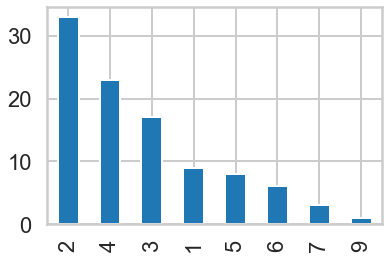

In [168]:
totals.All[:-1].value_counts().plot(kind='bar');

In [167]:
totals.All[:-1]

customer_name
Adams       3
Allen       2
Anderson    2
Bailey      2
Baker       4
           ..
Williams    3
Wilson      2
Wood        4
Wright      4
Young       6
Name: All, Length: 100, dtype: int64

In [178]:
total_bought = totals.All[:-1].values
total_bought


array([3, 2, 2, 2, 4, 4, 4, 2, 4, 3, 5, 3, 4, 4, 2, 2, 4, 4, 2, 3, 4, 2,
       2, 7, 2, 5, 2, 4, 2, 3, 1, 4, 2, 6, 2, 4, 3, 5, 5, 5, 2, 3, 1, 4,
       4, 5, 3, 3, 5, 3, 3, 7, 2, 2, 6, 2, 3, 2, 2, 4, 2, 1, 5, 2, 4, 6,
       2, 1, 4, 1, 2, 2, 3, 2, 1, 2, 2, 6, 2, 1, 7, 9, 3, 2, 3, 3, 4, 6,
       4, 1, 4, 2, 1, 2, 4, 3, 2, 4, 4, 6])

In [ ]:
#okay i think i'm just gonna go w/ my idea of fitting on COUNTRY & then another one on VARIETAL!



In [179]:
type(total_bought)

numpy.ndarray

In [175]:
type(labels)

numpy.ndarray

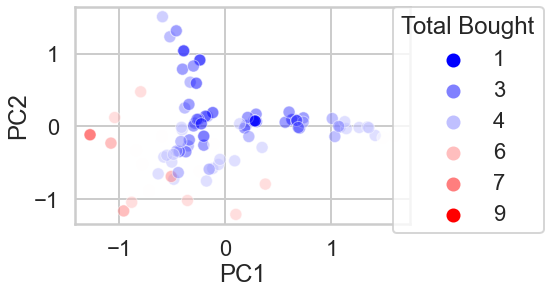

In [190]:
############################################################
###REALIZED!!!! you don't even need kmeans here!!! *JUST* NEED PCA!!!!
#THEN CAN COLOR ON HOWEVER YOU LIKE!!!!

#this is still using the same original PCA of course

model=PCA()
transformed=model.fit_transform(dummy_pivot_MASTER_array)
X = transformed[:,0]
y = transformed[:,1]
customer_name = dummy_pivot_MASTER.index

df_pca = pd.DataFrame({'customer_name':customer_name, 'PC1':X, 'PC2':y, 'total_bought':total_bought})


sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,hue='total_bought',palette='bwr')

# plt.colorbar() >> #MAN! wanted a colorbar! lol
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.4, 1),title='Total Bought') #ALHAMDULILLAH!!!!
plt.show();



In [ ]:
#INTERESTINGLY THERE *IS* SOMETHING TO THIS!
#it's split into people who just but a couple vs ppl who bought SEVERAL!
#It makes sense that the customers who were grouped together were ones who simply bought
#the same TOTAL AMOUNT as each other! Because with this data, all we have is WHETHER
#an offer was used, nothing else about it

#We cannot really color on anything else, at least not without bringing in information
#from the other table and adding our own columns, such as "% French bought", which we could then
#do a new PCA on, or use the existing and color accordingly, similar to what we did
#here with TOTAL bought
#Instead of doing PCA the way we did, based on offer_id, we could do it on the basis
#of country of origin, or variety, and see the groupings, but then again, we are
#limited in how we can color/label the CUSTOMERS, since we really don't have any additional
#information on them
#That's why the alternativ is to do another PCA that's NOT based on the 100 customers, but rather
#on the 324 TRANSACTIONS, or the 32 OFFERS, and come up with clusterings accordingly,
#however, those would have their OWN sets of clusterings



In [209]:
#We could also take a look at the breakdown of each cluster!

#Again, all we really have else that we can go off of, short of doing anything new/drastic,
#is the offer_ids

#So let's see if there's anything there

#So we can sum up the offer id's per cluster to get an idea of WHICH OFFER_ID'S DID
#EACH GROUP TAKE! cuz it's very likely that they were grouped according to that!

kmeans=KMeans(n_clusters=3)
labels=kmeans.fit_predict(dummy_pivot_MASTER_array)

pivot_pca = dummy_pivot_MASTER
pivot_pca['ClusterID'] = labels

pivot_pca
################################################################

offer_id_1  offer_id_2  offer_id_3  offer_id_4  offer_id_5  \
customer_name                                                               
Adams                   0           0           0           0           0   
Allen                   0           0           0           0           0   
Anderson                0           0           0           0           0   
Bailey                  0           0           0           0           0   
Baker                   0           0           0           0           0   
...                   ...         ...         ...         ...         ...   
Williams                0           0           0           0           0   
Wilson                  0           0           0           0           0   
Wood                    1           0           0           0           0   
Wright                  0           0           0           1           0   
Young                   0           0           0           0           0   

               offer_id_6  offer_id_7  offer_id_8  offer_id_9  offer_id_10  \
customer_name                                                                
Adams                   0           0           0           0            0   
Allen                   0           0           0           1            0   
Anderson                0           0           0           0            0   
Bailey                  0           1           0           0            0   
Baker                   0           1           0           0            1   
...                   ...         ...         ...         ...          ...   
Williams                0           0           0           0            0   
Wilson                  0           0           1           0            0   
Wood                    0           0           0           0            1   
Wright                  1           0           0           0            0   
Young                   1           0           0           1            0   

               ...  offer_id_24  offer_id_25  offer_id_26  offer_id_27  \
customer_name  ...                                                       
Adams          ...            0            0            0            0   
Allen          ...            0            0            0            1   
Anderson       ...            1            0            1            0   
Bailey         ...            0            0            0            0   
Baker          ...            0            0            0            0   
...            ...          ...          ...          ...          ...   
Williams       ...            0            0            0            0   
Wilson         ...            0            0            0            0   
Wood           ...            0            0            0            0   
Wright         ...            0            0            0            1   
Young          ...            0            0            0            0   

               offer_id_28  offer_id_29  offer_id_30  offer_id_31  \
customer_name                                                       
Adams                    0            1            1            0   
Allen                    0            0            0            0   
Anderson                 0            0            0            0   
Bailey                   0            0            1            0   
Baker                    0            0            0            1   
...                    ...          ...          ...          ...   
Williams                 0            0            0            1   
Wilson                   0            0            1            0   
Wood                     0            0            0            1   
Wright                   0            0            0            0   
Young                    0            0            0            1   

               offer_id_32  ClusterID  
customer_name                          
Adams                    0          2  
Allen            

In [218]:
#now we want the counts of offer_id per clusterID!

#here's OVERALL clusterID counts btw
pivot_pca.pivot_table(index='ClusterID',aggfunc='count')

offer_id_1  offer_id_10  offer_id_11  offer_id_12  offer_id_13  \
ClusterID                                                                   
0                  49           49           49           49           49   
1                  16           16           16           16           16   
2                  35           35           35           35           35   

           offer_id_14  offer_id_15  offer_id_16  offer_id_17  offer_id_18  \
ClusterID                                                                    
0                   49           49           49           49           49   
1                   16           16           16           16           16   
2                   35           35           35           35           35   

           ...  offer_id_3  offer_id_30  offer_id_31  offer_id_32  offer_id_4  \
ClusterID  ...                                                                  
0          ...          49           49           49           49          49   
1          ...          16           16           16           16          16   
2          ...          35           35           35           35          35   

           offer_id_5  offer_id_6  offer_id_7  offer_id_8  offer_id_9  
ClusterID                                                              
0                  49          49          49          49          49  
1                  16          16          16          16          16  
2                  35          35          35          35          35  

[3 rows x 32 columns]

In [216]:
df_transactions_trim.pivot_table(index=['customer_name','offer_id'])

Empty DataFrame
Columns: []
Index: [(Adams, 18), (Adams, 29), (Adams, 30), (Allen, 9), (Allen, 27), (Anderson, 24), (Anderson, 26), (Bailey, 7), (Bailey, 30), (Baker, 7), (Baker, 10), (Baker, 19), (Baker, 31), (Barnes, 10), (Barnes, 21), (Barnes, 22), (Barnes, 31), (Bell, 2), (Bell, 17), (Bell, 24), (Bell, 26), (Bennett, 8), (Bennett, 29), (Brooks, 3), (Brooks, 8), (Brooks, 11), (Brooks, 22), (Brown, 7), (Brown, 29), (Brown, 30), (Butler, 1), (Butler, 4), (Butler, 22), (Butler, 28), (Butler, 30), (Campbell, 2), (Campbell, 24), (Campbell, 26), (Carter, 7), (Carter, 13), (Carter, 29), (Carter, 30), (Clark, 4), (Clark, 11), (Clark, 28), (Clark, 31), (Collins, 11), (Collins, 30), (Cook, 24), (Cook, 26), (Cooper, 4), (Cooper, 16), (Cooper, 20), (Cooper, 32), (Cox, 2), (Cox, 17), (Cox, 24), (Cox, 26), (Cruz, 29), (Cruz, 30), (Davis, 12), (Davis, 22), (Davis, 25), (Diaz, 7), (Diaz, 8), (Diaz, 29), (Diaz, 30), (Edwards, 8), (Edwards, 27), (Evans, 22), (Evans, 27), (Fisher, 1), (Fisher, 2), (Fisher, 11), (Fisher, 22), (Fisher, 28), (Fisher, 30), (Fisher, 31), (Flores, 17), (Flores, 24), (Foster, 1), (Foster, 9), (Foster, 14), (Foster, 22), (Foster, 23), (Garcia, 14), (Garcia, 15), (Gomez, 11), (Gomez, 20), (Gomez, 25), (Gomez, 32), (Gonzalez, 9), (Gonzalez, 31), (Gray, 12), (Gray, 16), (Gray, 26), (Green, 7), (Gutierrez, 6), (Gutierrez, 8), (Gutierrez, 10), ...]

[324 rows x 0 columns]

In [234]:
kmeans=KMeans(n_clusters=3)
labels=kmeans.fit_predict(dummy_pivot_MASTER_array)
df_pca1 = pd.DataFrame({'customer_name':customer_name, 'X':X, 'y':y, 'cluster_ID':labels})


In [235]:
df_pca1

customer_name         X         y  cluster_ID
0          Adams  1.007580  0.108215           1
1          Allen -0.287539  0.044715           0
2       Anderson -0.392032  1.038391           2
3         Bailey  0.699477 -0.022542           1
4          Baker  0.088183 -0.471695           0
..           ...       ...       ...         ...
95      Williams -0.151666 -0.587844           0
96        Wilson  0.688224 -0.013688           1
97          Wood -0.551215 -0.395670           0
98        Wright -0.489805 -0.383307           0
99         Young -0.881994 -1.041788           0

[100 rows x 4 columns]

In [236]:
df_transactions_trim

customer_name  offer_id
0           Smith         2
1           Smith        24
2         Johnson        17
3         Johnson        24
4         Johnson        26
..            ...       ...
319        Fisher        11
320        Fisher        22
321        Fisher        28
322        Fisher        30
323        Fisher        31

[324 rows x 2 columns]

In [237]:
cluster_pivot = df_transactions_trim.merge(df_pca1,on='customer_name')
cluster_pivot

customer_name  offer_id         X         y  cluster_ID
0           Smith         2 -0.300227  0.829765           2
1           Smith        24 -0.300227  0.829765           2
2         Johnson        17 -0.461726  1.313485           2
3         Johnson        24 -0.461726  1.313485           2
4         Johnson        26 -0.461726  1.313485           2
..            ...       ...       ...       ...         ...
319        Fisher        11 -0.509137 -0.687321           0
320        Fisher        22 -0.509137 -0.687321           0
321        Fisher        28 -0.509137 -0.687321           0
322        Fisher        30 -0.509137 -0.687321           0
323        Fisher        31 -0.509137 -0.687321           0

[324 rows x 5 columns]

In [238]:
cluster_pivot.drop(['X','y'],axis=1,inplace=True)
cluster_pivot

customer_name  offer_id  cluster_ID
0           Smith         2           2
1           Smith        24           2
2         Johnson        17           2
3         Johnson        24           2
4         Johnson        26           2
..            ...       ...         ...
319        Fisher        11           0
320        Fisher        22           0
321        Fisher        28           0
322        Fisher        30           0
323        Fisher        31           0

[324 rows x 3 columns]

In [239]:
cluster_pivot.cluster_ID.value_counts()

0    183
1     98
2     43
Name: cluster_ID, dtype: int64

In [250]:
cluster_pivot_plotter = cluster_pivot.pivot_table(index=['cluster_ID','offer_id'],aggfunc='count').sort_values(by=['cluster_ID','offer_id'])
cluster_pivot_plotter

customer_name
cluster_ID offer_id               
0          1                     9
           2                     4
           3                     4
           4                    12
           5                     4
           6                    11
           7                     3
           8                     3
           9                    10
           10                    4
           11                   12
           12                    3
           14                    9
           15                    6
           16                    4
           18                    1
           19                    4
           20                    6
           21                    2
           22                   20
           23                    4
           25                    6
           26                    3
           27                    7
           28                    5
           29                    1
           30                    5
           31                   17
           32                    4
1          3                     2
           6                     1
           7                    16
           8                    17
           10                    2
           11                    1
           12                    1
           13                    6
           18                   13
           19                    1
           21                    2
           22                    1
           27                    1
           28                    1
           29                   16
           30                   17
2          1                     1
           2                     6
           10                    1
           12                    1
           16                    1
           17                    7
           23                    1
           24                   12
           26                   12
           27                    1

In [258]:
cluster_pivot_plotter.loc[0]

customer_name
offer_id               
1                     9
2                     4
3                     4
4                    12
5                     4
6                    11
7                     3
8                     3
9                    10
10                    4
11                   12
12                    3
14                    9
15                    6
16                    4
18                    1
19                    4
20                    6
21                    2
22                   20
23                    4
25                    6
26                    3
27                    7
28                    5
29                    1
30                    5
31                   17
32                    4

<Figure size 1440x720 with 0 Axes>

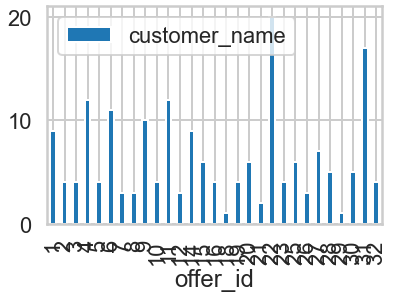

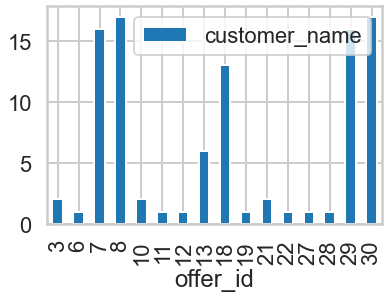

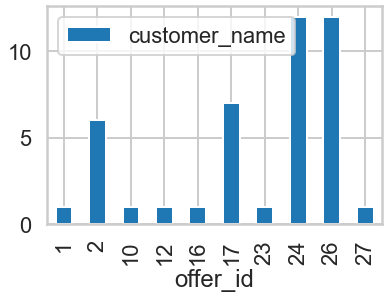

In [276]:
plt.figure(figsize=(20,10))

for i in range(3):
    cluster_pivot_plotter.loc[i].plot(kind='bar')
    plt.show();

In [281]:
#Okay so it seems that there may be a pattern on grouping like offers

#and then we can see if those offers are related like by country or type
#so let's just repeat that process

country_pivot = df_transactions_trim.merge(df_pca1,on='customer_name').drop(['X','y'],axis=1)
country_pivot = country_pivot.merge(df_offers)
country_pivot

customer_name  offer_id  cluster_ID campaign    varietal  min_qty  \
0           Smith         2           2  January  Pinot Noir       72   
1       Rodriguez         2           2  January  Pinot Noir       72   
2          Martin         2           0  January  Pinot Noir       72   
3         Jackson         2           0  January  Pinot Noir       72   
4        Campbell         2           2  January  Pinot Noir       72   
..            ...       ...         ...      ...         ...      ...   
319          Hill        13           1      May      Merlot        6   
320        Carter        13           1      May      Merlot        6   
321         James        13           1      May      Merlot        6   
322        Hughes        13           1      May      Merlot        6   
323      Sullivan        13           1      May      Merlot        6   

     discount  origin  past_peak  
0          17  France      False  
1          17  France      False  
2          17  France      False  
3          17  France      False  
4          17  France      False  
..        ...     ...        ...  
319        43   Chile      False  
320        43   Chile      False  
321        43   Chile      False  
322        43   Chile      False  
323        43   Chile      False  

[324 rows x 9 columns]

In [287]:
country_pivot_plotter = country_pivot.pivot_table(index=['cluster_ID','origin'],aggfunc='count').sort_values(by=['cluster_ID','past_peak'],ascending=False)
country_pivot_plotter = country_pivot_plotter['past_peak']
country_pivot_plotter

cluster_ID  origin      
2           Australia       13
            Italy           12
            France           7
            Germany          7
            California       2
            New Zealand      1
            South Africa     1
1           France          36
            Australia       17
            South Africa    17
            Oregon          15
            Chile            7
            California       4
            Germany          1
            New Zealand      1
0           France          85
            Chile           30
            Italy           12
            New Zealand     11
            Oregon          11
            California      10
            Australia        9
            Germany          8
            South Africa     7
Name: past_peak, dtype: int64

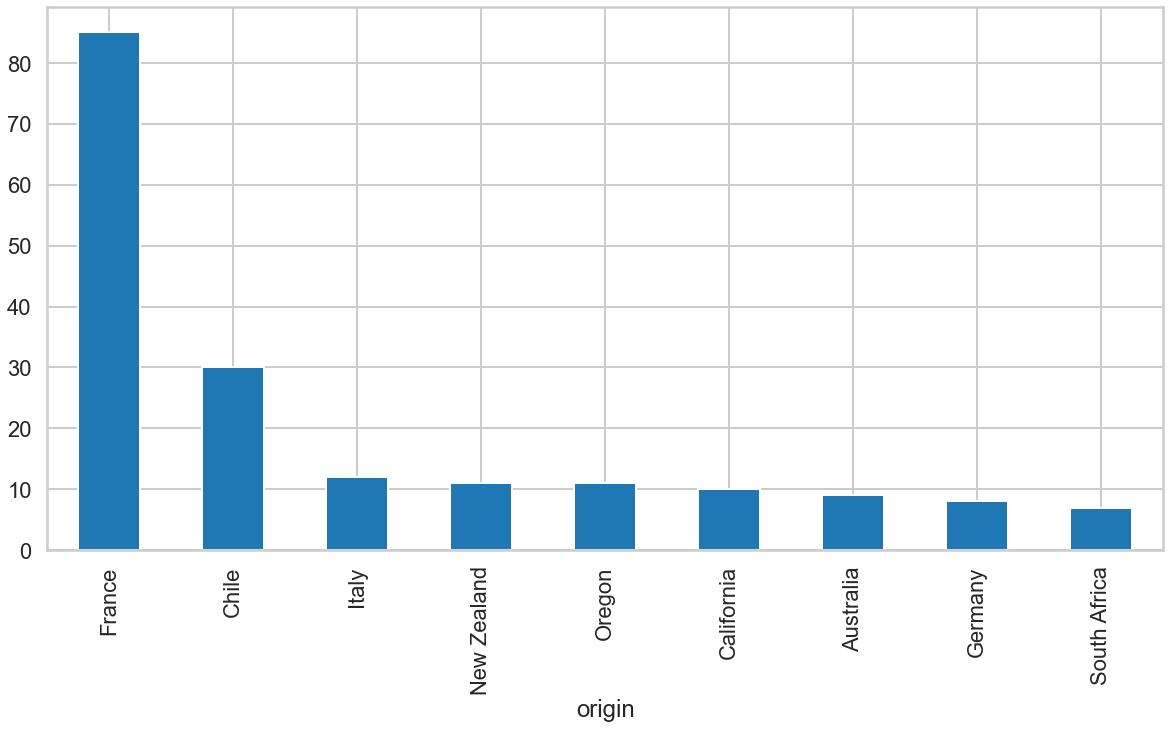

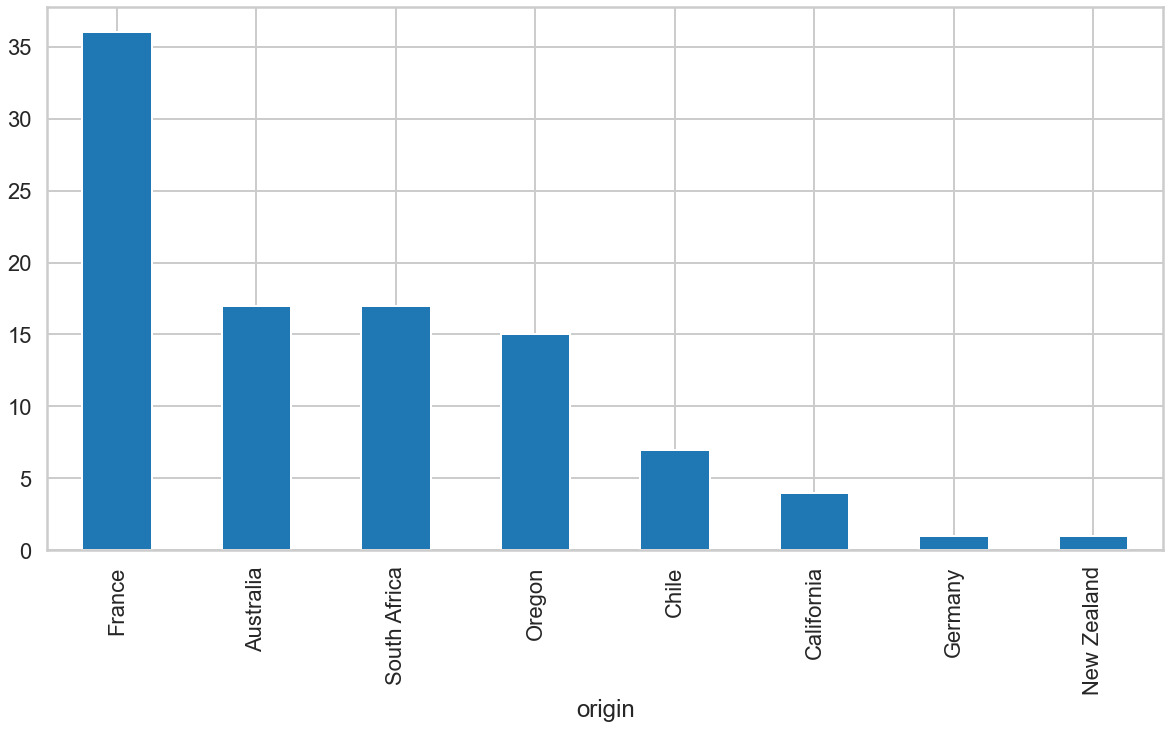

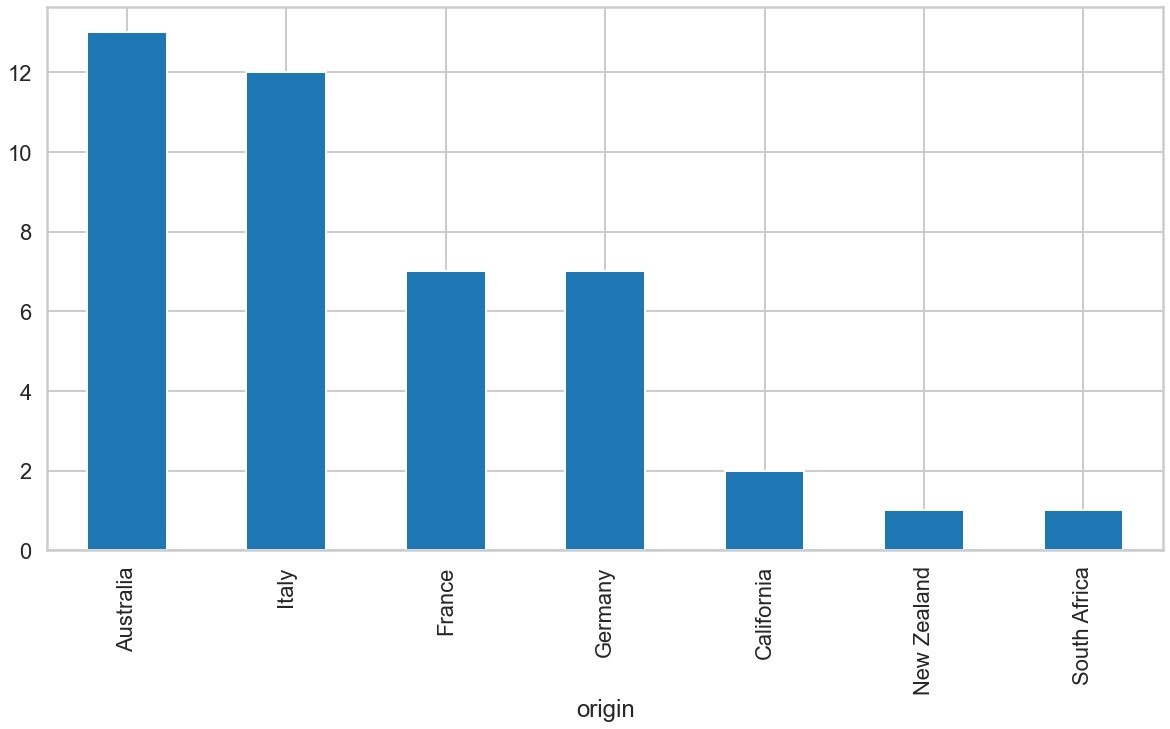

In [291]:
for i in range(3):
    plt.figure(figsize=(20,10))
    country_pivot_plotter.loc[i].plot(kind='bar')
    plt.show();

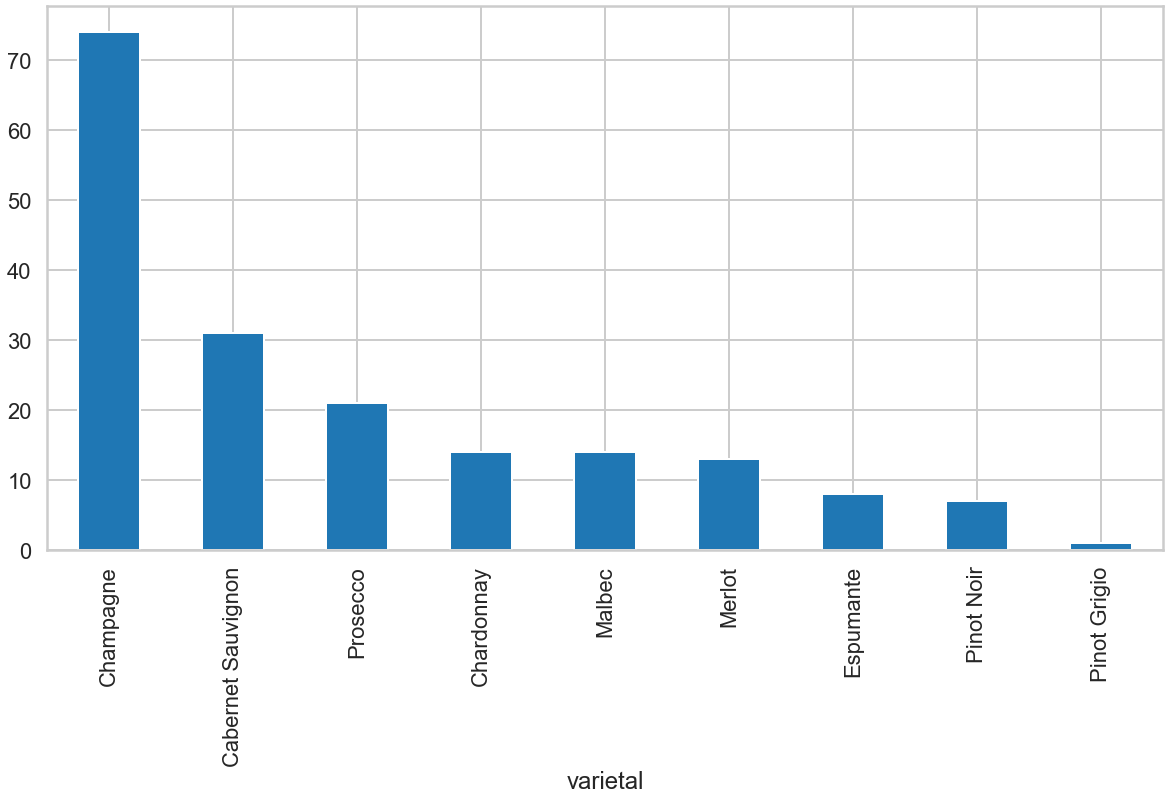

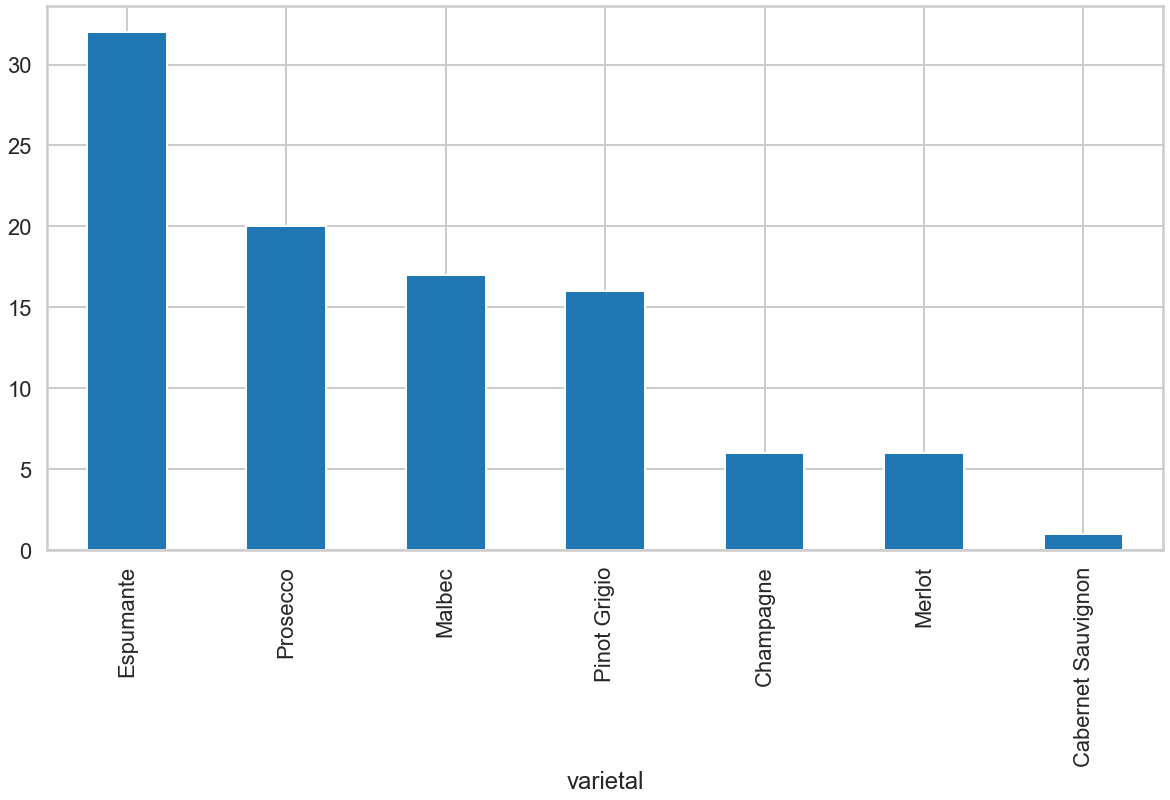

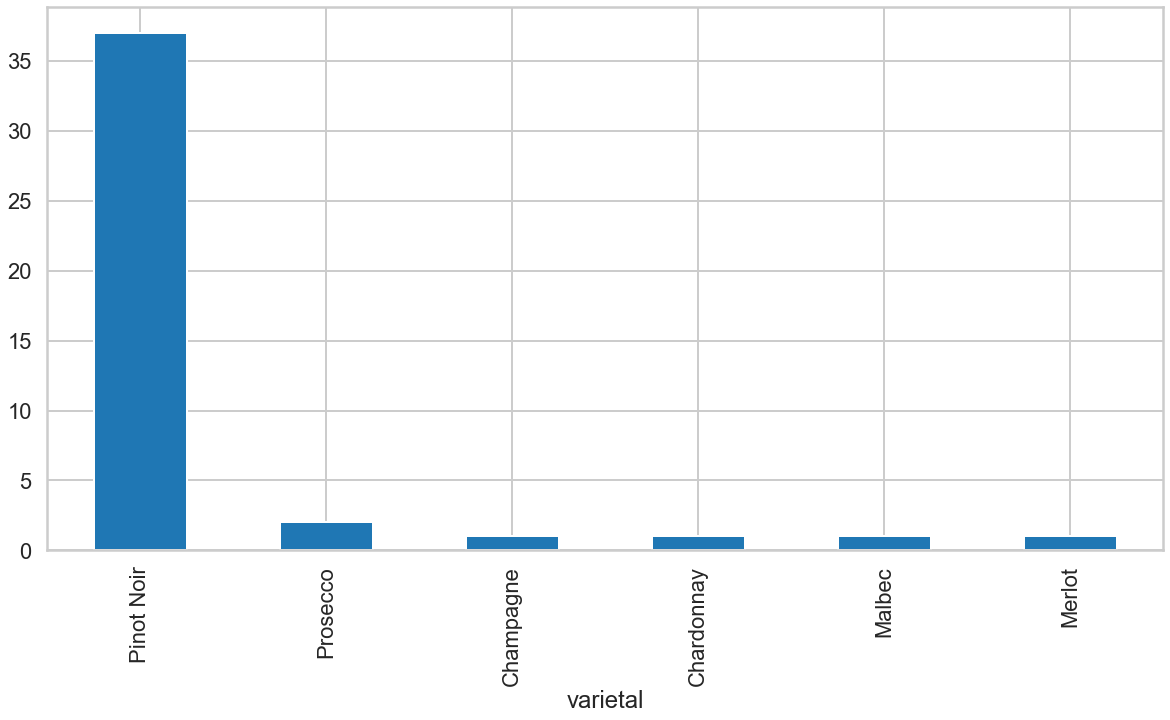

In [292]:
#hard to say if there's pattern here cuz again France is such a big portion
#not alot of clear patterns here

#so finally let's check on the TYPE


type_pivot = df_transactions_trim.merge(df_pca1,on='customer_name').drop(['X','y'],axis=1)
type_pivot = type_pivot.merge(df_offers)
type_pivot_plotter = type_pivot.pivot_table(index=['cluster_ID','varietal'],aggfunc='count').sort_values(by=['cluster_ID','past_peak'],ascending=False)
type_pivot_plotter= type_pivot_plotter['past_peak']


for i in range(3):
    plt.figure(figsize=(20,10))
    type_pivot_plotter.loc[i].plot(kind='bar')
    plt.show();

In [ ]:
#hmm okay! well, i thought maybe they were just SUGGESTING the 'type' thing but yeah -
#seems pretty clear, esp for 2 of the 3. That's significant if they're DOMINANT in one
#Cluster but nearly NON-EXISTENT in the other! That's the case w/ the leads of their Clusters,
#which could be part of their definers: Chmpg, PN & Euphus - although Euphus much moreso shares
#the spotlight in its group than other 2 do in theirs! even tho towers

#but yeah like 2nd group doesn't have *ANY* PN's!!!!
#last group has only *ONE* Chmpg & NO Eupheses!

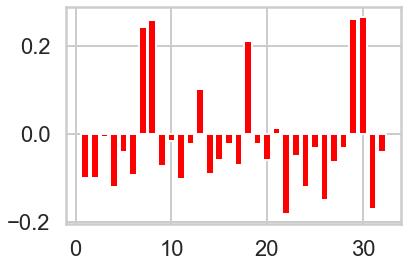

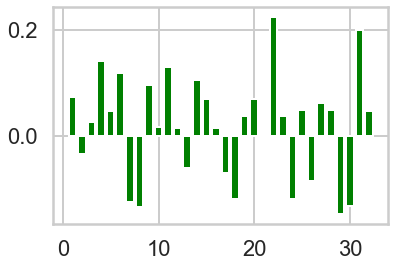

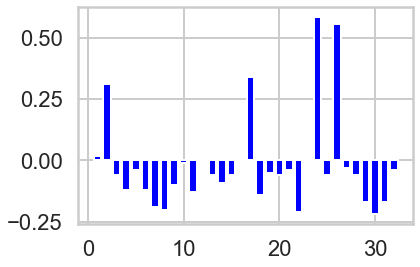

In [294]:
#Here's what they do:

# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.

pivoted = df_transactions.pivot_table(index='customer_name', columns='offer_id', values='n')

model = KMeans(n_clusters=3)
#at least aH i was right about the 3!
clusters = model.fit_predict(dummy_pivot_MASTER_array)

colors = ['red', 'green', 'blue']
offer_proportions = pivoted.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = pivoted[clusters == i] #customers of that cluster
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  #total transactions for each offer in that cluster divided by number of customers in that cluster >> average number of transactions per customer for each offer in cluster
    lift = offer_proportions_cluster - offer_proportions #^^ minus the proportion of transactions on/for this offer for this cluster?
    plt.bar(range(1, 33), lift, color=colors[i])

# so >>average number of transactions per customer for each offer in cluster minus the proportion of transactions on/for this offer for this cluster?
#so the difference between the #transactions per customer and PROPORTION of transactions?
        #for this offer and for this CLUSTER!?

#hmmm so what is this doing?
#ok it's plotting each cluster… some kind of ‘net’ value/difference?
####################################################################################

In [295]:
offer_proportions

offer_id
1     0.10
2     0.10
3     0.06
4     0.12
5     0.04
6     0.12
7     0.19
8     0.20
9     0.10
10    0.07
11    0.13
12    0.05
13    0.06
14    0.09
15    0.06
16    0.05
17    0.07
18    0.14
19    0.05
20    0.06
21    0.04
22    0.21
23    0.05
24    0.12
25    0.06
26    0.15
27    0.09
28    0.06
29    0.17
30    0.22
31    0.17
32    0.04
dtype: float64

In [296]:
offer_proportions.sum()

3.24

In [298]:
pivoted

offer_id        1   2   3    4   5    6    7    8    9    10  ...  23   24  \
customer_name                                                 ...            
Adams          NaN NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ... NaN  NaN   
Allen          NaN NaN NaN  NaN NaN  NaN  NaN  NaN  1.0  NaN  ... NaN  NaN   
Anderson       NaN NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ... NaN  1.0   
Bailey         NaN NaN NaN  NaN NaN  NaN  1.0  NaN  NaN  NaN  ... NaN  NaN   
Baker          NaN NaN NaN  NaN NaN  NaN  1.0  NaN  NaN  1.0  ... NaN  NaN   
...            ...  ..  ..  ...  ..  ...  ...  ...  ...  ...  ...  ..  ...   
Williams       NaN NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ... NaN  NaN   
Wilson         NaN NaN NaN  NaN NaN  NaN  NaN  1.0  NaN  NaN  ... NaN  NaN   
Wood           1.0 NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  1.0  ... NaN  NaN   
Wright         NaN NaN NaN  1.0 NaN  1.0  NaN  NaN  NaN  NaN  ... NaN  NaN   
Young          NaN NaN NaN  NaN NaN  1.0  NaN  NaN  1.0  NaN  ... NaN  NaN   

offer_id       25   26   27  28   29   30   31   32  
customer_name                                        
Adams         NaN  NaN  NaN NaN  1.0  1.0  NaN  NaN  
Allen         NaN  NaN  1.0 NaN  NaN  NaN  NaN  NaN  
Anderson      NaN  1.0  NaN NaN  NaN  NaN  NaN  NaN  
Bailey        NaN  NaN  NaN NaN  NaN  1.0  NaN  NaN  
Baker         NaN  NaN  NaN NaN  NaN  NaN  1.0  NaN  
...            ..  ...  ...  ..  ...  ...  ...  ...  
Williams      NaN  NaN  NaN NaN  NaN  NaN  1.0  NaN  
Wilson        NaN  NaN  NaN NaN  NaN  1.0  NaN  NaN  
Wood          NaN  NaN  NaN NaN  NaN  NaN  1.0  NaN  
Wright        NaN  NaN  1.0 NaN  NaN  NaN  NaN  NaN  
Young         NaN  NaN  NaN NaN  NaN  NaN  1.0  1.0  

[100 rows x 32 columns]

In [300]:
cluster.sum(axis=1)

customer_name
Anderson     2.0
Bell         4.0
Campbell     3.0
Cook         2.0
Cox          4.0
Flores       2.0
Gray         3.0
Jenkins      2.0
Johnson      3.0
Mitchell     2.0
Moore        2.0
Morris       3.0
Peterson     6.0
Phillips     2.0
Rodriguez    2.0
Russell      1.0
Smith        2.0
dtype: float64

In [303]:
cluster.sum(axis=0)

offer_id
1      2.0
2      7.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.0
8      0.0
9      0.0
10     1.0
11     0.0
12     1.0
13     0.0
14     0.0
15     0.0
16     1.0
17     7.0
18     0.0
19     0.0
20     0.0
21     0.0
22     0.0
23     1.0
24    12.0
25     0.0
26    12.0
27     1.0
28     0.0
29     0.0
30     0.0
31     0.0
32     0.0
dtype: float64

In [301]:
cluster.shape[0]

17

In [265]:
cluster_pivot_plotter.unstack()

customer_name                                                    \
offer_id              1    2    3     4    5     6     7     8     9    10   
cluster_ID                                                                   
0                    9.0  4.0  4.0  12.0  4.0  11.0   3.0   3.0  10.0  4.0   
1                    NaN  NaN  2.0   NaN  NaN   1.0  16.0  17.0   NaN  2.0   
2                    1.0  6.0  NaN   NaN  NaN   NaN   NaN   NaN   NaN  1.0   

            ...                                                         
offer_id    ...   23    24   25    26   27   28    29    30    31   32  
cluster_ID  ...                                                         
0           ...  4.0   NaN  6.0   3.0  7.0  5.0   1.0   5.0  17.0  4.0  
1           ...  NaN   NaN  NaN   NaN  1.0  1.0  16.0  17.0   NaN  NaN  
2           ...  1.0  12.0  NaN  12.0  1.0  NaN   NaN   NaN   NaN  NaN  

[3 rows x 32 columns]

In [302]:
offer_proportions_cluster

offer_id
1     0.117647
2     0.411765
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.058824
11    0.000000
12    0.058824
13    0.000000
14    0.000000
15    0.000000
16    0.058824
17    0.411765
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.058824
24    0.705882
25    0.000000
26    0.705882
27    0.058824
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
dtype: float64

In [305]:
pivoted

offer_id        1   2   3    4   5    6    7    8    9    10  ...  23   24  \
customer_name                                                 ...            
Adams          NaN NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ... NaN  NaN   
Allen          NaN NaN NaN  NaN NaN  NaN  NaN  NaN  1.0  NaN  ... NaN  NaN   
Anderson       NaN NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ... NaN  1.0   
Bailey         NaN NaN NaN  NaN NaN  NaN  1.0  NaN  NaN  NaN  ... NaN  NaN   
Baker          NaN NaN NaN  NaN NaN  NaN  1.0  NaN  NaN  1.0  ... NaN  NaN   
...            ...  ..  ..  ...  ..  ...  ...  ...  ...  ...  ...  ..  ...   
Williams       NaN NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ... NaN  NaN   
Wilson         NaN NaN NaN  NaN NaN  NaN  NaN  1.0  NaN  NaN  ... NaN  NaN   
Wood           1.0 NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  1.0  ... NaN  NaN   
Wright         NaN NaN NaN  1.0 NaN  1.0  NaN  NaN  NaN  NaN  ... NaN  NaN   
Young          NaN NaN NaN  NaN NaN  1.0  NaN  NaN  1.0  NaN  ... NaN  NaN   

offer_id       25   26   27  28   29   30   31   32  
customer_name                                        
Adams         NaN  NaN  NaN NaN  1.0  1.0  NaN  NaN  
Allen         NaN  NaN  1.0 NaN  NaN  NaN  NaN  NaN  
Anderson      NaN  1.0  NaN NaN  NaN  NaN  NaN  NaN  
Bailey        NaN  NaN  NaN NaN  NaN  1.0  NaN  NaN  
Baker         NaN  NaN  NaN NaN  NaN  NaN  1.0  NaN  
...            ..  ...  ...  ..  ...  ...  ...  ...  
Williams      NaN  NaN  NaN NaN  NaN  NaN  1.0  NaN  
Wilson        NaN  NaN  NaN NaN  NaN  1.0  NaN  NaN  
Wood          NaN  NaN  NaN NaN  NaN  NaN  1.0  NaN  
Wright        NaN  NaN  1.0 NaN  NaN  NaN  NaN  NaN  
Young         NaN  NaN  NaN NaN  NaN  NaN  1.0  1.0  

[100 rows x 32 columns]

In [ ]:
#how is pivoted.sum() DECIMALS when these are all whole numbers? unless i guess AVERAGED?? default 'mean' +_+

In [304]:
offer_proportions

offer_id
1     0.10
2     0.10
3     0.06
4     0.12
5     0.04
6     0.12
7     0.19
8     0.20
9     0.10
10    0.07
11    0.13
12    0.05
13    0.06
14    0.09
15    0.06
16    0.05
17    0.07
18    0.14
19    0.05
20    0.06
21    0.04
22    0.21
23    0.05
24    0.12
25    0.06
26    0.15
27    0.09
28    0.06
29    0.17
30    0.22
31    0.17
32    0.04
dtype: float64

In [263]:
sns.catplot(data=cluster_pivot_plotter.loc[0],x='offer_id',y='customer_name',kind='bar');

ValueError: Could not interpret input 'offer_id'

In [201]:
dummy_pivot_MASTER;

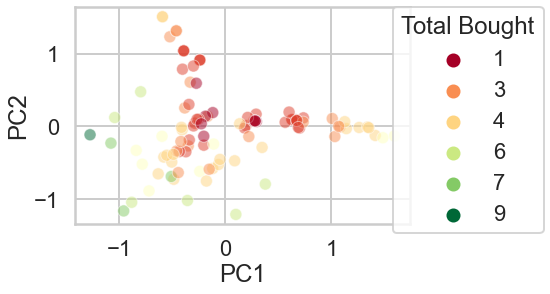

In [189]:
#oh! we should try with 3 colors!


df_pca = pd.DataFrame({'customer_name':customer_name, 'PC1':X, 'PC2':y, 'total_bought':total_bought})

sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,hue='total_bought',palette='RdYlGn')

# plt.colorbar() >> #MAN! wanted a colorbar! lol
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.4, 1),title='Total Bought') #ALHAMDULILLAH!!!!
# plt.grid(False) #if want, maybe good here, though doesn't look as clean
plt.show();




In [ ]:
#Oh nice!!! We get even further evidence it seems of clustering by #purchases! (offers used)
#You see the gradual transition that has good consistency!

In [194]:
#they did this which is simply what i did aH!

# import matplotlib.colors

# cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# plt.scatter(X, y, c=labels, cmap=cmap);

In [317]:
dummy_pivot_MASTER.index

Index(['Adams', 'Allen', 'Anderson', 'Bailey', 'Baker', 'Barnes', 'Bell',
       'Bennett', 'Brooks', 'Brown', 'Butler', 'Campbell', 'Carter', 'Clark',
       'Collins', 'Cook', 'Cooper', 'Cox', 'Cruz', 'Davis', 'Diaz', 'Edwards',
       'Evans', 'Fisher', 'Flores', 'Foster', 'Garcia', 'Gomez', 'Gonzalez',
       'Gray', 'Green', 'Gutierrez', 'Hall', 'Harris', 'Hernandez', 'Hill',
       'Howard', 'Hughes', 'Jackson', 'James', 'Jenkins', 'Johnson', 'Jones',
       'Kelly', 'King', 'Lee', 'Lewis', 'Long', 'Lopez', 'Martin', 'Martinez',
       'Miller', 'Mitchell', 'Moore', 'Morales', 'Morgan', 'Morris', 'Murphy',
       'Myers', 'Nelson', 'Nguyen', 'Ortiz', 'Parker', 'Perez', 'Perry',
       'Peterson', 'Phillips', 'Powell', 'Price', 'Ramirez', 'Reed', 'Reyes',
       'Richardson', 'Rivera', 'Roberts', 'Robinson', 'Rodriguez', 'Rogers',
       'Ross', 'Russell', 'Sanchez', 'Sanders', 'Scott', 'Smith', 'Stewart',
       'Sullivan', 'Taylor', 'Thomas', 'Thompson', 'Torres', 'Turner',
    

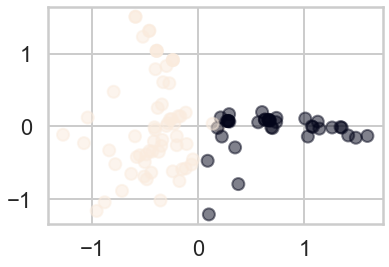

In [52]:
#let's try LOWEST good k of k=2!!!!
from sklearn.decomposition import PCA

kmeans=KMeans(n_clusters=2)
labels=kmeans.fit_predict(dummy_pivot_MASTER_array)

model=PCA()

transformed=model.fit_transform(dummy_pivot_MASTER_array)
X = transformed[:,0]
y = transformed[:,1]
customer_name = dummy_pivot_MASTER.index
df_pca = pd.DataFrame({'customer_name':customer_name, 'X':X, 'y':y, 'cluster_ID':labels})

plt.scatter(X,y,alpha=.5,c=labels);

# plt.grid(False)

#optional reserve lol for the end - gonna be too crowded, unless really size up plot!
# for x, y, customer in zip(X, y, customer_name):
#     plt.annotate(customer, (x, y), fontsize=10, alpha=0.75)

# plt.legend(labels)


In [ ]:
#SUBHANALLAHI WA BI HAMDI, SUBHANALLAHIL 'AUDHEEM!!!!!

#NICEEEEEEEEEE!!!!!!!!!

#AND DIDN'T I SAY GO FOR 2 OR 3 BASED ON THE INITIAL *ELBOW* DIAGRAM?!?

#IN FACT! WE CAN JUST LOOK AT THIS PCA PLOT TO TRY TO GET AN INTUITIVE SENSE OF WHAT
#MAKES SENSE!!!!

#i think homeboy was doing something a little diff in the documentation,
#but if we'd done THIS of comparing these PCA scatts along WITH the Silhouettes,
#WOULDA REALLY HELPED US DECIDE!!!!

#SO IN FACT - LET'S AT LEAST LOOK AT THE SET OF PCA PLOTS @ DIFF kmeans k's!!!!!

#like just looking at the plot, you can see at least probably a fair 3 regions!
#so yeah! let's see what things look like!!!!! will just keep the first few low numbers!!!!



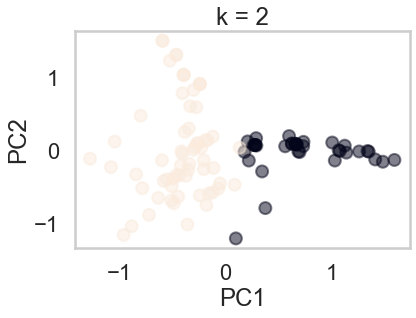

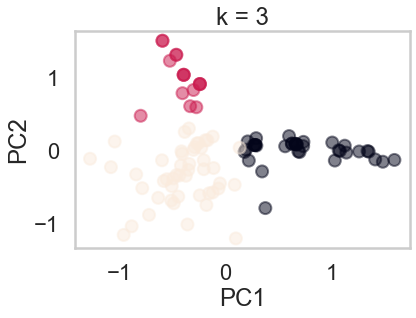

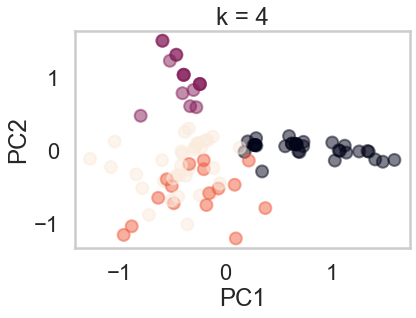

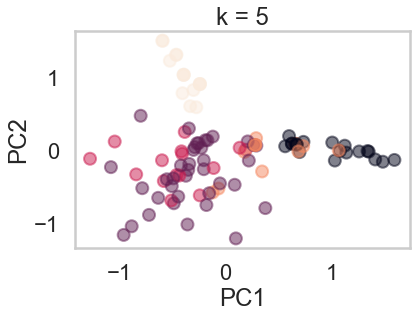

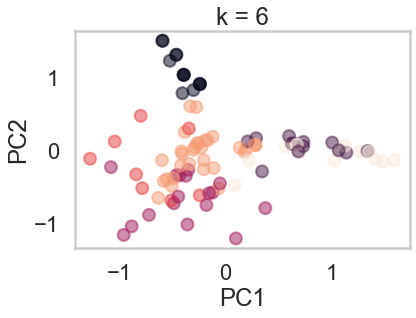

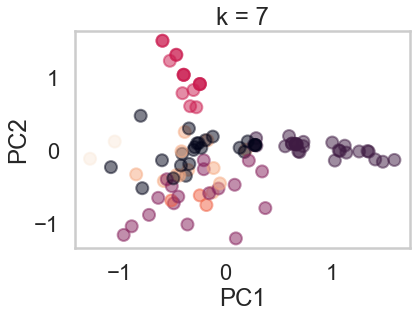

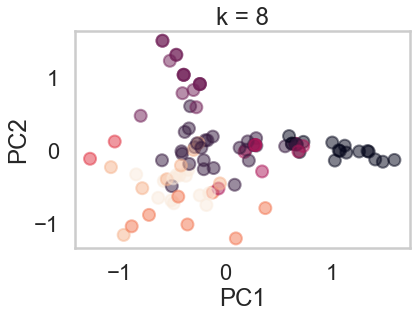

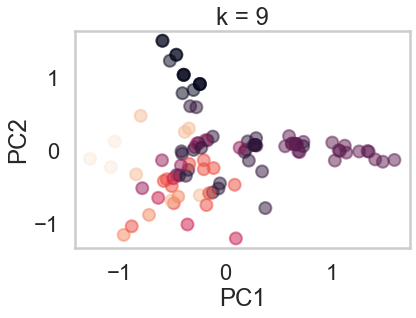

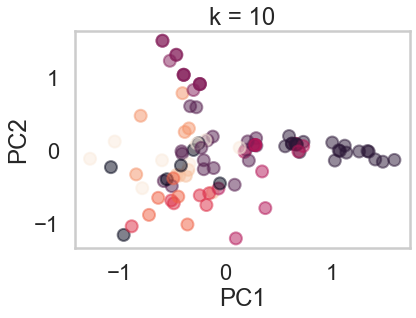

In [53]:
#let's see the full range!

ks = range(2,11)
 
for k in ks:
    kmeans=KMeans(n_clusters=k)
    labels=kmeans.fit_predict(dummy_pivot_MASTER_array)

    model=PCA()
    transformed=model.fit_transform(dummy_pivot_MASTER_array)
    X = transformed[:,0]
    y = transformed[:,1]
    customer_name = dummy_pivot_MASTER.index
    df_pca = pd.DataFrame({'customer_name':customer_name, 'X':X, 'y':y, 'cluster_ID':labels})

    plt.scatter(X,y,alpha=.5,c=labels)

    plt.title('k = %d' %k)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(False)
    plt.show();

In [ ]:
#gonna be way to much work to customize a palette for these bigger guys lol - no discernable
#cluster out there anyway!

In [ ]:
#SUBHANALLAH SO W/ THIS HONESTLY *k=3* *DOES* LOOK THE BEST/REALLY GOOD!!!!!!

#AND IF YOU REMEMBER - *THAT WAS OUR CHOICE EXACTLY BASED ON THE ELBOW PLOT!!!!! w/ kmeans

#SO YEAH!!!!! WHY DIDN'T WE JUST USE THIS IN THE BEGINNING IF WE COULDN'T TELL!?!?!?!?
####################################################################################

#silhouette is much harder to judge than elbow!!!! alot more criteria/subjective perception
#seems to me!!! unless just going off of HIGHEST VALUE!!!!

#BUT THIS VISUALIZATION IS JUST *SOOO INTUITIVE*!!!!!

#CAN TELL / MAKE DETERMINATION LITERALLY WITHIN SECONDS!!!!!

#so yeah great combo / dynamic duo of kmeans + PCA!

#i think t-SNE would also be/do similarly right??
####################################################################################

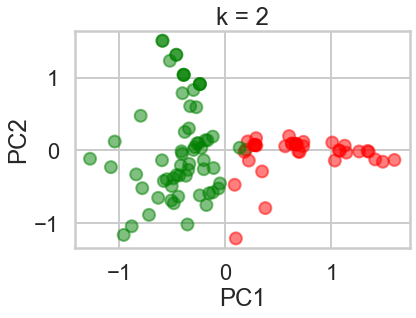

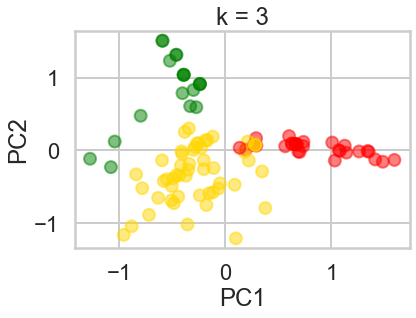

In [417]:
#THE TOPPERS!

ks = [2,3]

model=PCA()
transformed=model.fit_transform(dummy_pivot_MASTER_array)
X = transformed[:,0]
y = transformed[:,1]
customer_name = dummy_pivot_MASTER.index

 
for k in ks:
    kmeans=KMeans(n_clusters=k)
    labels=kmeans.fit_predict(dummy_pivot_MASTER_array)

    df_pca = pd.DataFrame({'customer_name':customer_name, 'X':X, 'y':y, 'cluster_ID':labels})
    
    colors =  df_pca.cluster_ID.map({0:'g',1:'r',2:'gold'})
    # markers = df_pca.cluster_ID.map({0:'o',1:'x',2:'^'})
    
    # plt.scatter(X,y,alpha=.5,c=colors,s=10)#,marker=markers)

    plt.scatter(X,y,alpha=.5,c=colors)

    plt.title('k = %d' %k)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    # plt.legend()
    plt.show();

In [ ]:
#let's try seaborn instead!

import seaborn as sns

In [403]:
df_pca

customer_name         X         y  cluster_ID
0          Adams  1.007580  0.108215           1
1          Allen -0.287539  0.044715           0
2       Anderson -0.392032  1.038391           2
3         Bailey  0.699477 -0.022542           1
4          Baker  0.088183 -0.471695           0
..           ...       ...       ...         ...
95      Williams -0.151666 -0.587844           0
96        Wilson  0.688224 -0.013688           1
97          Wood -0.551215 -0.395670           0
98        Wright -0.489805 -0.383307           0
99         Young -0.881994 -1.041788           0

[100 rows x 4 columns]

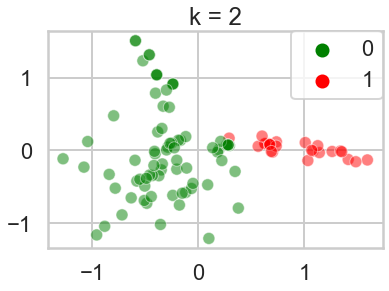

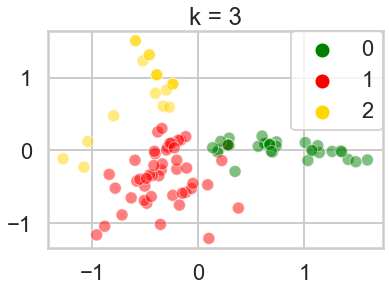

In [90]:
ks = [2,3]

model=PCA()
transformed=model.fit_transform(dummy_pivot_MASTER_array)
X = transformed[:,0]
y = transformed[:,1]
customer_name = dummy_pivot_MASTER.index

for k in ks:
    kmeans=KMeans(n_clusters=k)
    labels=kmeans.fit_predict(dummy_pivot_MASTER_array)

    df_pca = pd.DataFrame({'customer_name':customer_name, 'PC1':X, 'PC2':y, 'cluster_ID':labels})
    #REALLY DIDN'T WANNA HAVE TO PUT 'x'&'y' BUT IT'S ANNOYING NOW AND WANTS US TO SPECIFY
    #OTHERWISE IT GIVES AN ANNOYING MESSAGE! so, just to shut it up lol
    colors =  {0:'g',1:'r',2:'gold'}

    sns.scatterplot(x=X,y=y,data=df_pca,alpha=.5,hue='cluster_ID',palette=colors)

    plt.title('k = %d' %k)
    # plt.xlabel("PC1")
    # plt.ylabel("PC2") ####DON'T NEED THESE ANYMORE W/ SEABORN!!!!! now that we changed our 'X'/'y' labels!!!!
    plt.legend(loc='upper right',borderaxespad=0)
    plt.show();

In [ ]:
################################################################

#ALHAMDULILLAHI RABBIL 'AALAMEEN!!!!!! HERE IT FINALLY IS!!!!!

In [ ]:
#another option for legend!

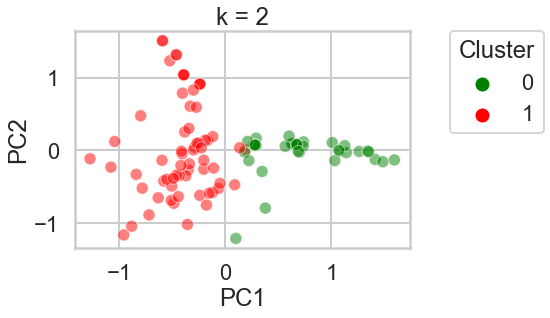

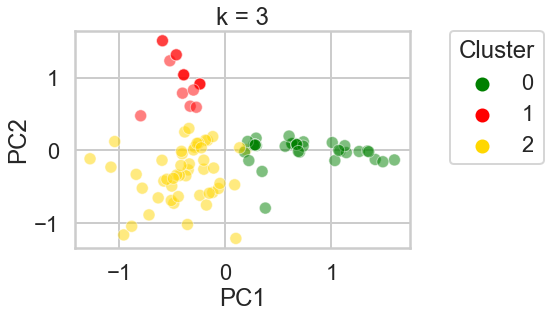

In [530]:
ks = [2,3]

model=PCA()
transformed=model.fit_transform(dummy_pivot_MASTER_array)
X = transformed[:,0]
y = transformed[:,1]
customer_name = dummy_pivot_MASTER.index

for k in ks:
    kmeans=KMeans(n_clusters=k)
    labels=kmeans.fit_predict(dummy_pivot_MASTER_array)

    df_pca = pd.DataFrame({'customer_name':customer_name, 'PC1':X, 'PC2':y, 'cluster_ID':labels})
    
    colors =  {0:'g',1:'r',2:'gold'}

    sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,hue='cluster_ID',palette=colors)
    #REALLY DIDN'T WANNA HAVE TO PUT 'x'&'y' BUT IT'S ANNOYING NOW AND WANTS US TO SPECIFY
    #OTHERWISE IT GIVES AN ANNOYING MESSAGE! so, just to shut it up lol

    plt.title('k = %d' %k)
    plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.4, 1),title='Cluster') #ALHAMDULILLAH!!!!
    # plt.grid(False) #if want, maybe good here, though doesn't look as clean
    plt.show();



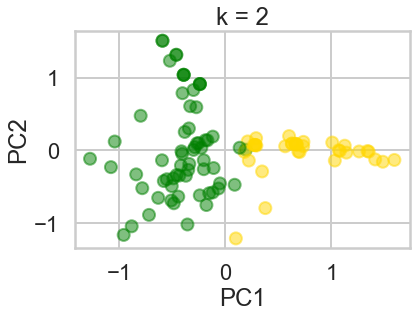

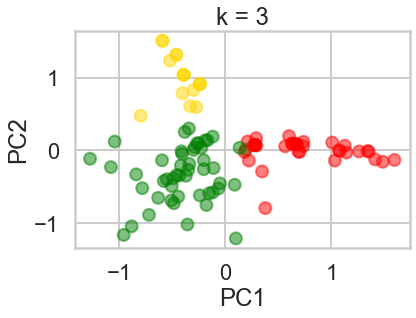

In [470]:
#####################################################################################

#NOTE! you could do plt.scatter() w/ c=labels, then customize colors this way w/ custom color map
#forget about the legend tho lol not even going there!

ks = [2,3]

model=PCA()
transformed=model.fit_transform(dummy_pivot_MASTER_array)
X = transformed[:,0]
y = transformed[:,1]
customer_name = dummy_pivot_MASTER.index

 
for k in ks:
    kmeans=KMeans(n_clusters=k)
    labels=kmeans.fit_predict(dummy_pivot_MASTER_array)

    df_pca = pd.DataFrame({'customer_name':customer_name, 'X':X, 'y':y, 'cluster_ID':labels})
    
    # colors = ['g','r','gold']
    # colors =  df_pca.cluster_ID.map({0:'g',1:'r',2:'gold'})
    # colors = {0:'g',1:'r',2:'gold'}
    from matplotlib import colors
    colors = colors.ListedColormap(['g','r','gold'])
    # markers = df_pca.cluster_ID.map({0:'o',1:'x',2:'^'})
    
    # plt.scatter(X,y,alpha=.5,c=colors,s=10)#,marker=markers)
    #was tryna do a markers dictionary but didn't spend too much time
    ###############################################################

    plt.scatter(X,y,alpha=.5,c=labels,cmap=colors)

    plt.title('k = %d' %k)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    # plt.legend(labels)
    plt.show();

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [64]:
[n + 1 for n in range(31)]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [66]:
[n + 1 for n in range(pca.n_components_)]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

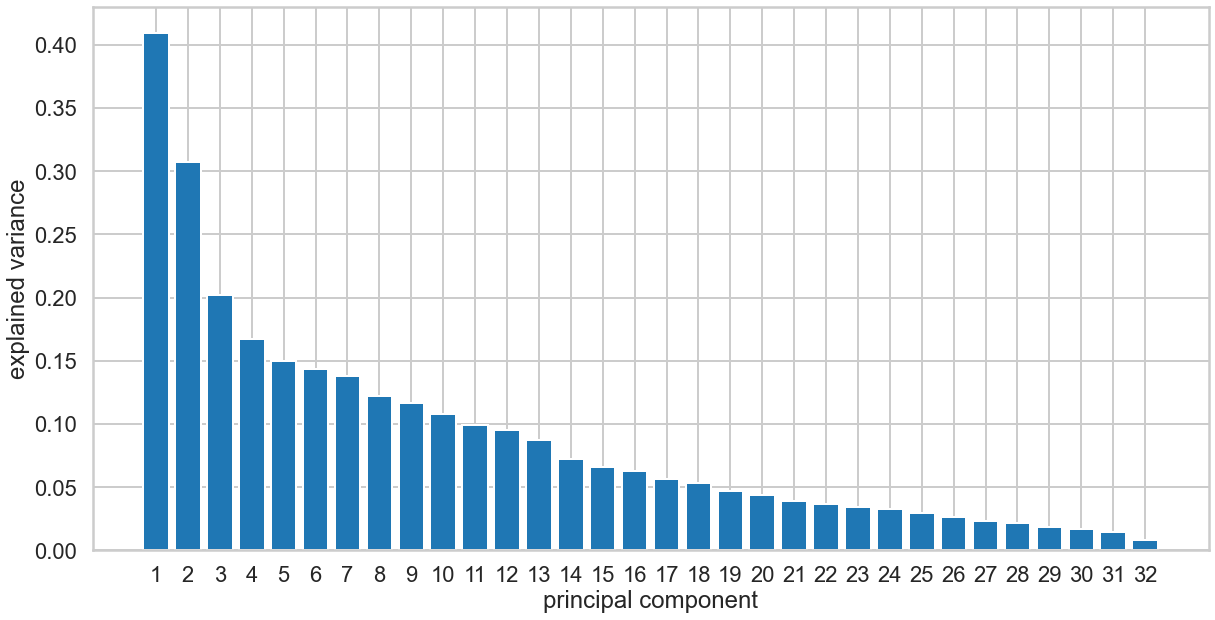

In [67]:
###############################################################################################
#so remem - what we were doing for our PCA visualization had nothing to do w/ the OPTIMAL
#number of Principal Components to choose!!!!! - cuz again we were only using 2 to view anyway
#so as far as VIEWING is concerned - the number we choose doesn't matter/doesn't make a difference
#But now it's getting into the optimal - by looking at explained variance!
###############################################################################################
#but now i'm forgetting - once we pick the ideal amount.... like what do we do with that?
#cuz can only visualize up to 3 anyway...
#like we're doing dimension reduction / getting intrinsic dimension
###############################################################################################

# Initialize a new PCA model with a default number of components
pca = PCA()
pca.fit(dummy_pivot_MASTER_array)
features = [n + 1 for n in range(pca.n_components_)]
#THIS IS SO WE CAN GET IT TO PLOT RIGHT/MORE INTUITIVELY BY STARTING AT 1
#SO LINES UP W/ 'PC1' ETC!!!!! rather than/to avoid 0-indexing!!!!!confusion!
########################################################################

# sns.barplot(x=features,y=pca.explained_variance_)
# sns.catplot(x=features,y=pca.explained_variance_,kind='bar')

plt.figure(figsize=(20,10))

plt.bar(features,pca.explained_variance_)
plt.xticks(features) #setting up features as we did^, don't have to mess w/ this then!
plt.ylabel('explained variance')
plt.xlabel('principal component');


#so it seems like problem w/ seaborn options is they're only for when you have a *DF*
#you're taking x/y from as columns?
#plt.bar is shorter for that part itself tho lol but then gotta spend more time/room
#annotating etc


In [68]:
len(dummy_pivot_MASTER_array)

100

In [ ]:
###REMEMBER ONCE AGAIN THIS IS *NOT* ABOUT PICKING k FOR kmeans BUT RATHER THE
#***NUMBER OF PRINCIPAL COMPONENTS***#!!!!!!

#but interestingly here looks like here too the SWEETSPOT WOULD BE 3 PRINCIPAL COMPONENTS!
#ie that it's primarily 3 principal components explaining a big chunk of the TOTAL variance
#in fact, *THESE 3 ALONE EXPLAIN --- calculated below lol --- *1/3* OF ALL VARIANCE!!!!

#cuz after that point variance drop / decay slows down alot.... but similar to Elbow
#w/ kmeans we saw in that it still climbs down a good bit thru end
#BUT - is that what we're looking for here??
#cuz here, explained variance is GOOD - so we wanna see what's giving us
#significant ADDITIONAL explained variance...
#CUZ AFTER THAT THE DECREASE LEVELS OFF!
#diminishing returns
#but first 3 only give us 33% of total... so clearly ALOT LEFT TO GO / ALOT OF VALUE!
#so then, if PC=3 isn't the sweet spot / if Intrinsic Dimension DOESN'T=/ISN'T 3 - THEN
#WHAT IS?!? cuz nothing else here jumps out then cuz it's all STEADY/GRADUAL!!!!

#but also - and this explains the confusion - note what it's about actually ISN'T necessarily
#purely looking for a steep drop-off like we do in elbow, but rather, THE POINT FROM WHICH
#ONWARD THE EXPLAINED VARIANCE *ISN'T SIGNINFICANT*!!!!!! so yes, that means/INCLUDES a
#steep drop usually, however, a steep drop *DOESN'T GUARANTEE* that from that landing
#point on the explained variance is gonna be *INSIGNIFICANT*!!!!!!!!!!!!!!!!!!!! as this shows!

#so what do we do in this case??
#pick the # of PC's that give us like a certain THRESHOLD total percentage/share of the
#total variance?!!??!?! or could make the threshold a percent amount of the INDIVIDUAL
#PRINCIPAL COMPONENT that like it has to be at least THIS MUCH in order for us to accept it!
#like in this case might say like at least 3% or 4%!!!! MUST BE A "SIGNIFICANT" CONTRIBUTOR!!!
#substantial part of the team! essential! un-do-without-able!!!!!
#LOL! *MUST BE AT LEAST THIS TALL TO RIDE!*
########################################################################################

In [70]:
pca.explained_variance_

array([0.4096489 , 0.30753551, 0.2022926 , 0.16703717, 0.15015248,
       0.1434373 , 0.13818887, 0.12192294, 0.11636172, 0.10804271,
       0.09937813, 0.09495961, 0.08690352, 0.07256738, 0.0660996 ,
       0.06245473, 0.05634388, 0.05327395, 0.04728801, 0.04393911,
       0.03900424, 0.03625783, 0.03455714, 0.03235091, 0.02940632,
       0.02618221, 0.02308167, 0.02142632, 0.018814  , 0.0165252 ,
       0.01426187, 0.0077789 ])

In [77]:
pca.explained_variance_ratio_

array([0.14386393, 0.10800289, 0.07104281, 0.05866151, 0.05273181,
       0.05037351, 0.04853032, 0.04281792, 0.04086488, 0.03794334,
       0.03490044, 0.03334871, 0.03051951, 0.02548482, 0.02321341,
       0.02193338, 0.01978732, 0.01870919, 0.016607  , 0.0154309 ,
       0.01369783, 0.01273333, 0.01213607, 0.01136126, 0.01032716,
       0.00919489, 0.00810601, 0.00752468, 0.00660726, 0.00580346,
       0.0050086 , 0.00273186])

In [79]:
pca.explained_variance_ratio_[:3]

array([0.14386393, 0.10800289, 0.07104281])

In [78]:
pca.explained_variance_ratio_[:3].sum()

0.32290962687115754

In [81]:
pca.explained_variance_ratio_[:13].sum()

0.7536015766458634

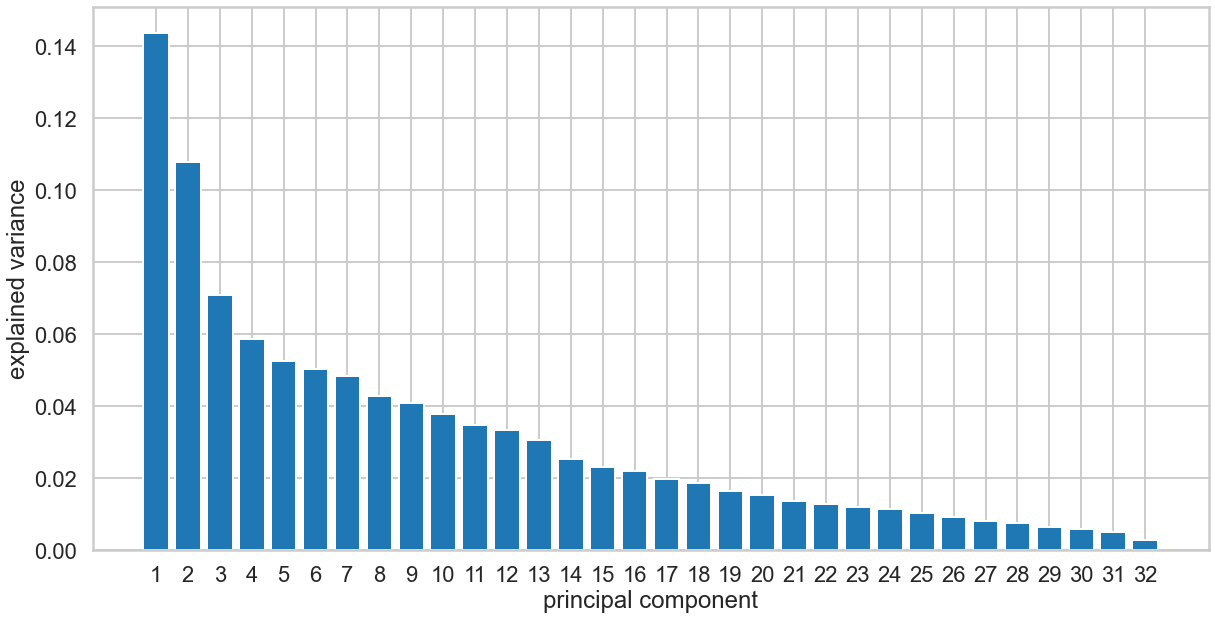

In [76]:
#lets get in terms of PROPORTION

plt.figure(figsize=(20,10))

plt.bar(features,pca.explained_variance_ratio_)
plt.xticks(features)
plt.ylabel('explained variance')
plt.xlabel('principal component');

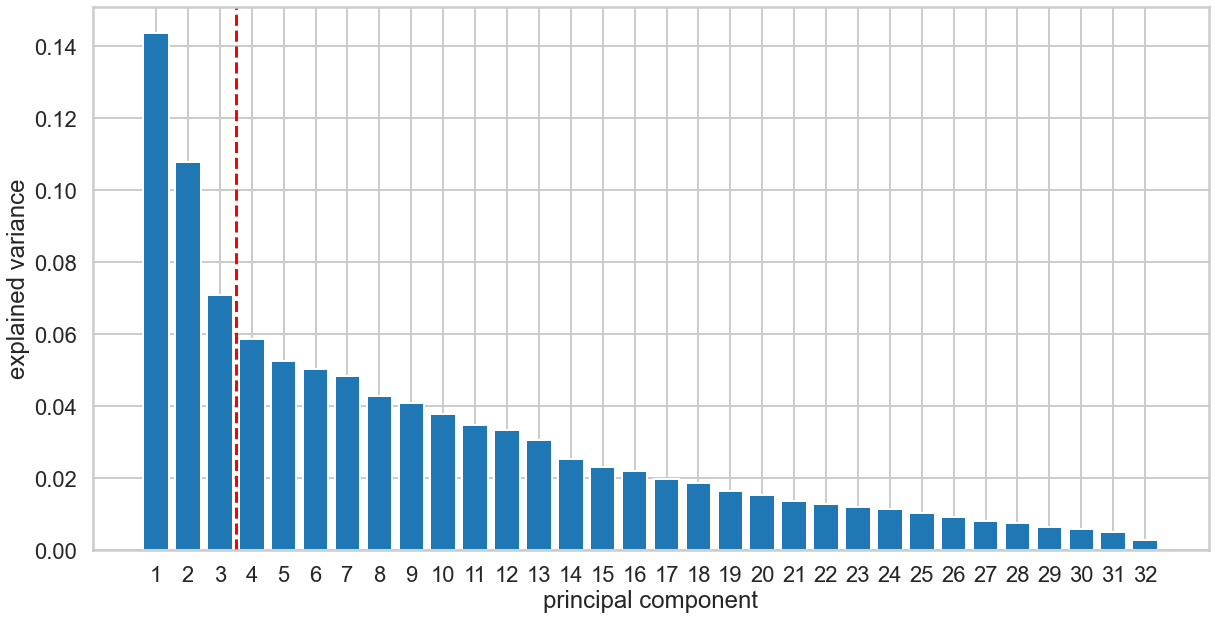

In [88]:
plt.figure(figsize=(20,10))

plt.bar(features,pca.explained_variance_ratio_)
plt.axvline(3.5,c='r',linestyle='--')
plt.xticks(features)
plt.ylabel('explained variance')
plt.xlabel('principal component');

In [474]:
range(pca.n_components_)

range(0, 32)

In [475]:
pca.explained_variance_

array([0.4096489 , 0.30753551, 0.2022926 , 0.16703717, 0.15015248,
       0.1434373 , 0.13818887, 0.12192294, 0.11636172, 0.10804271,
       0.09937813, 0.09495961, 0.08690352, 0.07256738, 0.0660996 ,
       0.06245473, 0.05634388, 0.05327395, 0.04728801, 0.04393911,
       0.03900424, 0.03625783, 0.03455714, 0.03235091, 0.02940632,
       0.02618221, 0.02308167, 0.02142632, 0.018814  , 0.0165252 ,
       0.01426187, 0.0077789 ])

In [480]:
len(pca.explained_variance_)

32

In [483]:
features

range(0, 32)

In [ ]:
#wait can you have ONE PRINCIPAL COMPONENT??
#############################################

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

In [ ]:
#The most convincing way to judge the correct number of clusters was through simply looking
#at the PCA! And THEN playing with/toggling the number of clusters there! The intuition
#on PCA  visuals is far more powerful and nearer to objective than elbow or silhouette
#diagrams, at least/especially in this case!

#As far as the ideal number of principal components, the explained variance diagram
#made it similarly difficult to make a confident call, however, there was no other
#easy way to make the call. Obviously plotting the PCA itself, as said, helps with
#determining the number of k CLUSTERS, but with this many features, it doesn't help us
#to find the ideal number of Principal Components! (if we only had 2 or 3 features,
#it could work, and in fact, we may not even need PCA - we would probably be able to make
#that determination simply using a 3D plot!)

##########################################################################################

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [ ]:
#how do we decide which performs best?

#i guess just look at their CLUSTERING using PCA for visualizing! just like we did w/ kmeans

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

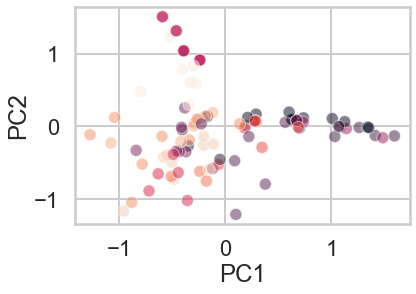

In [507]:
#THIS IS NICE CUZ YOU DON'T NEED TO SPECIFY THE NUMBER OF CLUSTERS!

from sklearn.cluster import AffinityPropagation

model = AffinityPropagation()
model.fit(dummy_pivot_MASTER_array)
labels=model.predict(dummy_pivot_MASTER_array)

sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,c=labels)
np.unique(labels)




In [ ]:
#hmmm - doesn't look too good
#how to measure?
#any hypers to tweak/cross-validate?

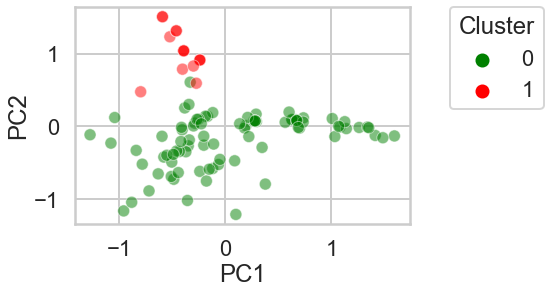

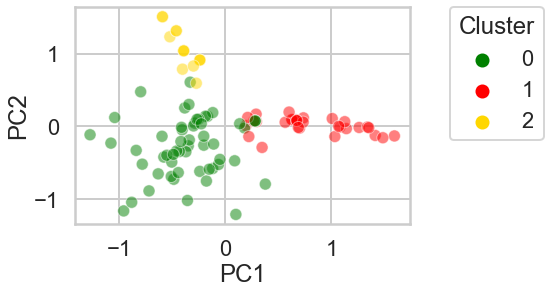

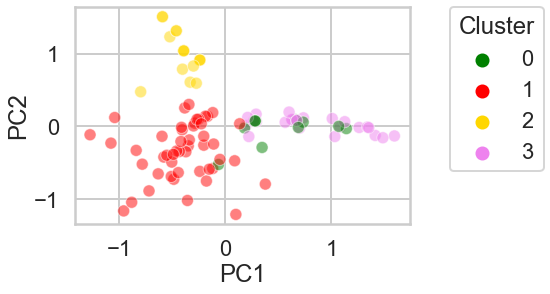

In [96]:
#FOR THE ONES THAT *DO* TAKE CLUSTER SPECIFICATION LIKE THIS - WE SHOULD JUST USE OUR
#ALREADY KNOWN TOP CHOICES! but can explore a couple extra to see how they do
from sklearn.cluster import SpectralClustering

ks = [2,3,4]

colors =  {0:'g',1:'r',2:'gold',3:'violet'}

for k in ks:
    model = SpectralClustering(n_clusters=k)
    labels=model.fit_predict(dummy_pivot_MASTER_array)
    sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,hue=labels,palette=colors)
    plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.4, 1),title='Cluster')
    plt.show();
    #.legend() has to go BEFORE .show() apparently! weird how somet things do,
    #some things don't?!?!?
    ##########################################################################################

In [ ]:
#okay so 4 clusters is no good here either! thought would be better! lol

In [ ]:
#dang i just realized that maybe i shoulda changed the labels to start at 1 too!
####################################################################

In [ ]:
#okaiy okaiy! i see you! def better!!!
#VERY GOOD / VERY SIMILAR TO KMEANS!!!!

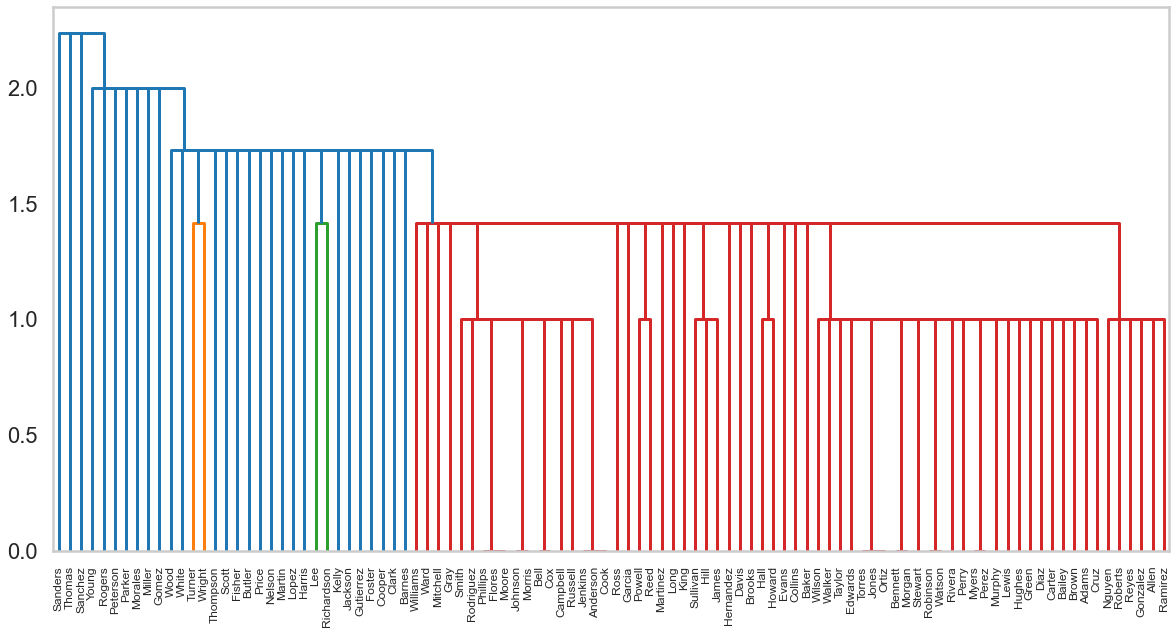

In [548]:
#this one we gotta break up into a couple steps cuz FIRST gotta see
#what the overall hierarchy looks like AND see the HEIGHTS/LEVELS & then
#based on that, we gotta pick the level that'll give us the clusters we want?

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

plt.figure(figsize=(20,10))
#OHHHHHHHHHHHHHHHHHHHHHH!
#THE REASON THE WHOLE RESIZE THING WASN'T WORKING THIS WHOLE TIME WAS
#CUZ YOU HAVE TO PUT IT *BEFORE* NOT ONLY PLT.SHOW() BUT *BEFORE* EVEN THE PLOT CODE!!!!
####################################################################################

mergings = linkage(dummy_pivot_MASTER_array)

dendrogram(mergings,labels=customer_name,leaf_rotation=90,leaf_font_size=12)

plt.grid(False)
#FINALLY GOT RID OF THOSE UGLY GRIDLINES!!!
#HOW TO MAKE IT PERMANENT?!?
##########################################################################################
plt.show()



In [ ]:
#hmmm, interesting... okay so this must be SINGLE, that it defaulted to, cuz of the
#'staircasing' pattern, and so here it seems really hard to get *3* clusters!!!
#WELL LIKE BASICALLY IT'LL INCLUDE *EVERYTHING* IN ONE CLUSTER EXCEPT *2* - AND THEN
#LITERALLY EACH OF THOSE 2 WILL BE EACH THEIR OWN OTHER CLUSTERS!!!!!!
#so let's go to COMPLETE!!!!

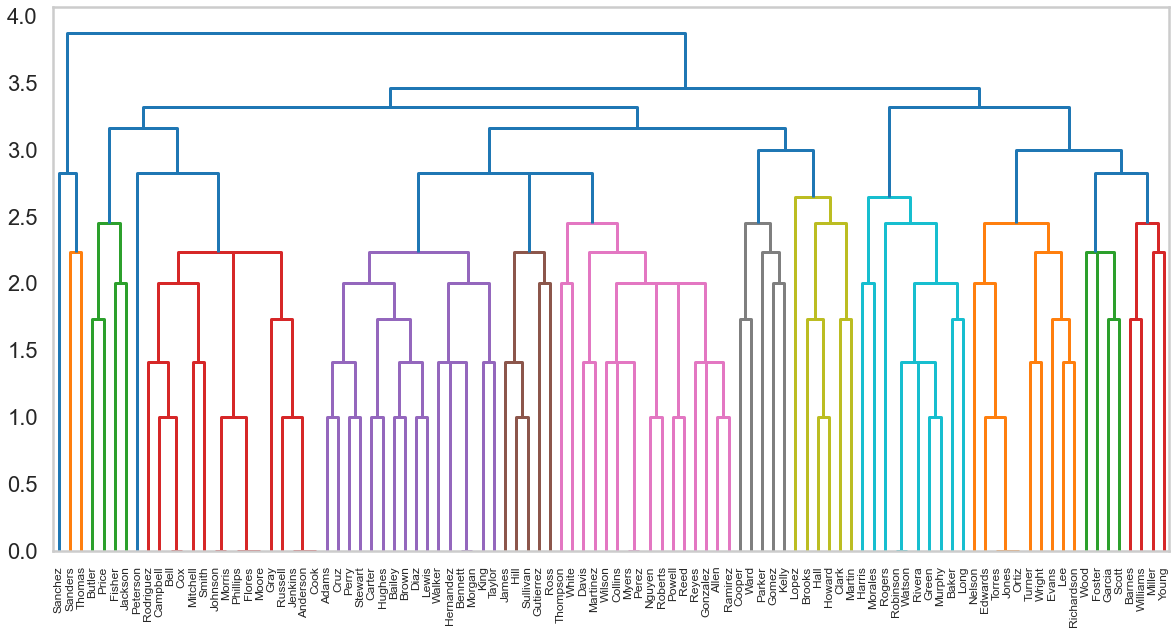

In [554]:
#ok let's try COMPLETE
#this one we gotta break up into a couple steps cuz FIRST gotta see
#what the overall hierarchy looks like AND see the HEIGHTS/LEVELS & then
#based on that, we gotta pick the level that'll give us the clusters we want?

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

plt.figure(figsize=(20,10))

mergings = linkage(dummy_pivot_MASTER_array,method='complete')

dendrogram(mergings,labels=customer_name,leaf_rotation=90,leaf_font_size=12)

plt.grid(False)

plt.show()


In [ ]:
#okay! so this def makes it much more balanced out - here we'd take it down to
#height/level like 3.5/3.6, and then we get those two BIG hanger/balances, but then one
#inny liddoo one all the way on left...
# 
# hmm, so i think we might need to go for more clusters here
# it looks like *5* will be a good bet - hard to say - WISH WE HAD A ####SLIDER#### LOL!
#NOW I SEE THE WISDOM!!!!! HOW DO WE DO THAT?!?!
#but looks like about 3.25?? will have to experiment!
########################################################################

[1 2 3 4 5]


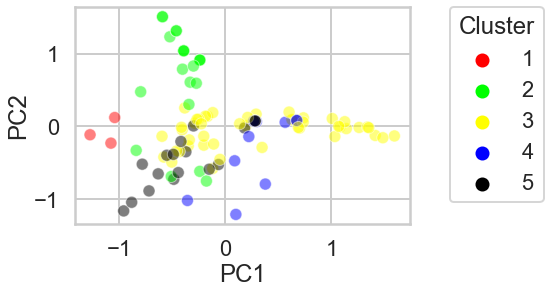

In [579]:
labels = fcluster(mergings,3.25,criterion='distance')

colors =  {1:'r',2:'lime',3:'yellow',4:'b',5:'black'}
#LOL - really hadda try to EXAGGERATE the colors more - even w//@ just 5! wanna
#see how to do it EXACTLY lol like MAXIMAL even spacing on color wheel!!!
#####################################################################################

sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,hue=labels,palette=colors)
print(np.unique(labels))
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.4, 1),title='Cluster');


In [ ]:
#LOL switched the coloring order to make the small LEFT group OUTLIERS >> *RED*
#lol instead of green to show that they're the problem outliers!

[1 2 3]


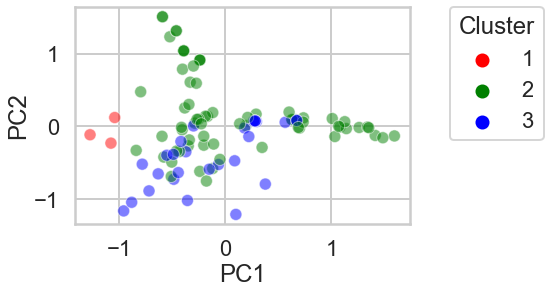

In [585]:
#NICE WELL ALHAMDULILLAH THAT DID MAKE FOR 5 GROUPS!!!!
#but yeah def not as good as others!

#can try for less groups

labels = fcluster(mergings,3.35,criterion='distance')

colors =  {1:'r',2:'g',3:'blue',4:'b',5:'black'}

sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,hue=labels,palette=colors)
print(np.unique(labels))
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.4, 1),title='Cluster');


In [ ]:
##########################################
#SUBHANALLAH!!!! CHANGES SO QUICK!!! SO SENSITIVE!!! CUZ WE ARE NEAR THE VERY TOP!!!
#SO THIS IS WHERE THE *FINAL* *BIG* MERGINGS HAPPPEN!
#so yeah things change very quickly!
#and you see those lone 3 off to the side, that i guess in both single AND complete,
#basically got saved for very last lol

##########################################
#LLOL: CHICAGO: ****
##########################################

[1 2]


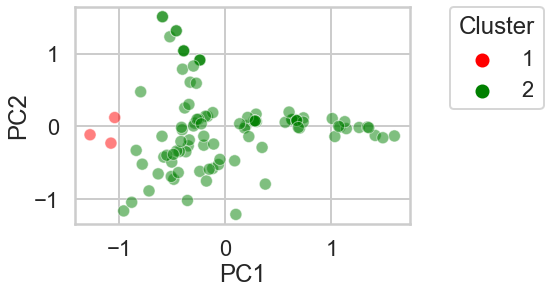

In [584]:
#2 groups

labels = fcluster(mergings,3.5,criterion='distance')

colors =  {1:'r',2:'g',3:'yellow',4:'b',5:'black'}

sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,hue=labels,palette=colors)
print(np.unique(labels))
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.4, 1),title='Cluster');


In [ ]:
#lol so yeah, we don't really like this cuz just doesn't divide nicely
#based on the PCA plot...

In [ ]:
#btw, remem, the way hue is working to color these guys is,
#pc1 & pc2 come from pca transform; then labels are numbers 1 thru 5
#and the list of them is the same length as pc1 & pc2
#so it's like we're telling it just go down the line - the set of labels is
#tacked onto the pc1/pc2 / attached!
#so each of them is given a CLUSTER LABEL and then that corresponds to a COLOR!!!
#so like it's coloring each pc1,pc2 pair of points IN ORDER based on the set of LABELS
#we got, 1->5, that's of the SAME LENGTH, so it's like their lined up,
#and then the COLORS of those labels are customized according to our color map/dict!!!!!!
####################################################################################

In [ ]:
#and last but not least

[-1  0  1  2]


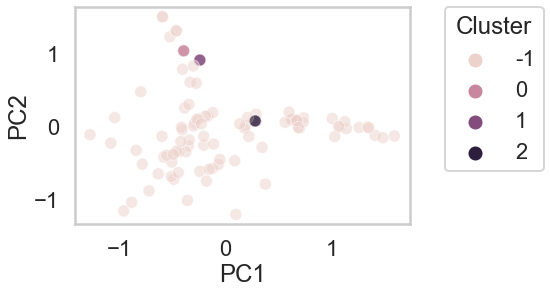

In [607]:
from sklearn.cluster import DBSCAN

#so w/ this one we DO needa specify something - the neighborhood size - like kNN?
#min_samplesint, default=5
# The number of samples (or total weight) in a neighborhood for a point to be considered
#as a core point. This includes the point itself

model = DBSCAN(min_samples=3)
labels=model.fit_predict(dummy_pivot_MASTER_array)

sns.scatterplot(x='PC1',y='PC2',data=df_pca,alpha=.5,hue=labels)
print(np.unique(labels))
plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.4, 1),title='Cluster')

plt.grid(False);

In [608]:
#This prob doesn't work well cuz this says it's more for data with HIGH DENSITY CLUSTERS!

#but we might needa do more research into how to find optimal 'eps' param and also
#min points / min samples etc

In [ ]:
#So the best are definitely kmeans & Spectral, and they're very similar @ 3 clusters! Too close
#to say which is better - the border regions have points that can fairly be argued either
#way. More data, if available, would have to be seen. It makes sense that these 2
#perform similarly since they're RELATED!